# import libs

In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Palatino Linotype'] + plt.rcParams['font.serif']

plt.rcParams['font.size'] = 25
plt.rcParams['lines.linewidth'] = 3

# data to run the model

In [2]:
min_time_ADP = 0
max_time_ADP = 120
step_ADP = 25 # 25
min_ADP = 0.0
max_ADP = 5000
ilo_ADP = 0
data_ADP = []

min_time_ilo = 0
max_time_ilo = 120
step_ilo = 0.025 # 0.025
min_ilo = 0.0
max_ilo = 2
ADP_ilo = 5000
data_ilo = []

ilo_range = [0, 0.001, 0.01, 0.2, 0.5, 1]

ADP_range = [0, 10, 20, 50, 100, 300, 500, 800, 1000, 5000]

# Общее время проведения эксперимента в секундах
max_time_1 = 500

# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points_1 = [
    [0, 5000, 0]
]

# k_max, IC50, h, EC50

In [3]:
k1_max = 0.090
EC50_k1 = 46.8
h_k1 = 1.27

IC50_k1_ilo = 0.048
h_k1_ilo = 1.52

k2_max = 0.016
EC50_k2 = 589.8
h_k2 = 3.92

IC50_k2_ilo = 0.21
h_k2_ilo = 2.14

k3_max = 0.032 * 2
EC50_k3 = 589.8
h_k3 = 3.92

IC50_k3_ilo = 0.21
h_k3_ilo = 2.14

k12_max = 0.49 # 0.31
EC50_k12 = 0.4
h_k12 = 1

k21_max = 0.06
EC50_k21 = 10000
h_k21 = 1

#k5_max = 0.0028 # из статьи
IC50_k5 = 1840
h_k5 = 1.4

#k6_max = 0.055 # из статьи
IC50_k6 = 990
h_k6 = 1.9

#k7_max = 0.055 # то же самое, что для k6
IC50_k7 = 990
h_k7 = 1.9

k11_max = 0.0005
k11 = k11_max

k5_max = 0.0028
EC50_k5_ilo = 0.047
h_k5_ilo = 1.52
IC50_k5_ADP = 1840
h_k5_ADP = 1.4

k6_max = 0.055
EC50_k6_ilo = 0.21
h_k6_ilo = 2.14
IC50_k6_ADP = 990
h_k6_ADP = 1.9

k7_max = 0.055
EC50_k7_ilo = 0.21
h_k7_ilo = 2.14
IC50_k7_ADP = 990
h_k7_ADP = 1.9

# Supplementary Functions

In [4]:
def find_speed(df, col, t):

    values = df[col]

    # Вычисляем производную dy/dt с использованием метода конечных разностей
    df['dy_dt'] = np.gradient(values, df['Time'])

    # Находим скорость в момент времени t
    t_target = t
    speed = df.loc[df['Time'] == t_target, 'dy_dt'].values[0]
    return speed


def auc(min_time, max_time, step, min_grad, max_grad, conc, u_t1, u_t2, num_ph=6, conc_type='ADP'):

    df_area = pd.DataFrame(columns=[conc_type, 'auc_gp', 'u_gp', 'auc_aggr', 'u_aggr', 'auc_a2b3', 'u_a2b3', 'u_sph'])

    for i in np.arange(min_grad, max_grad + step, step):
        y0 = [100.0]
        counter = 1
        while counter < num_ph:
            y0.append(0.0)
            counter += 1

        if conc_type == 'ADP':
            points = [
                [min_time, i, conc]
                ]
        elif conc_type == 'ilo':
            points = [
                [min_time, conc, i]
                ]


        df = calculate_concetrations(points, max_time, y0)

        auc_gp = np.trapz(df['N_gp'], x=df['Time'])
        u_gp = find_speed(df, 'N_gp', u_t1)

        auc_aggr = np.trapz(df['N_aggr'], x=df['Time'])
        u_aggr = find_speed(df, 'N_aggr', u_t1)

        sqrt_N_aggr = np.sqrt(df['N_aggr'])
        # df['N_a2b3'] = sqrt_N_aggr + df['N_gp']
        df['N_a2b3'] = sqrt_N_aggr
        auc_a2b3 = np.trapz(df['N_a2b3'], x=df['Time'])
        u_a2b3 = find_speed(df, 'N_a2b3', u_t1)

        u_sph = find_speed(df, 'N_sph', u_t2)

        df_area.loc[len(df_area)] = [i, auc_gp, u_gp, auc_aggr, u_aggr, auc_a2b3, u_a2b3, u_sph]

    return [df_area, conc]

In [5]:
# Функция для построения графика на заданной оси
def plot_graph(ax, data, data_ex, data_ex_range, x_col, y_col_teor, y_col_exp, yerr_col_exp, label, color_teor, color_exp, legend_pos='upper right'):
    """
    Универсальная функция для построения графика с теоретическими и экспериментальными данными.
    """
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position(('data', 0))  # Перемещение нижней оси
    ax.spines['left'].set_position(('data', 0))  # Перемещение левой оси для симметрии
    max_value_x = data_ex_range[x_col].max()
    max_value_x_corrected = max_value_x * 1.01
    xticks = [x for x in range(0, int(max_value_x_corrected), int(max_value_x / 5)) if x != 0]
    ax.set_xticks(xticks)  # Деления для оси X
    ax.set_yticks(range(0, 102, 20))  # Деления для оси Y
    ax.set_xlim([0, max_value_x_corrected])  # Лимиты для оси X
    ax.set_ylim([0, 102])  # Лимиты для оси Y

    mask_teor = data[[x_col, y_col_teor]].notna().all(axis=1)  # Фильтр для 'Teor'
    mask_exp = data_ex[[x_col, y_col_exp]].notna().all(axis=1)  # Фильтр для 'Exp'

    ax.plot(data[x_col][mask_teor], data[y_col_teor][mask_teor], label='Teor', color=color_teor, alpha=0.5)
    ax.errorbar(data_ex[x_col][mask_exp], data_ex[y_col_exp][mask_exp],
                yerr=data_ex[yerr_col_exp][mask_exp], label='Exp', fmt='s', capsize=5, alpha=0.5, color=color_exp)
    ax.plot(data_ex_range[x_col], data_ex_range[y_col_exp], linestyle='-', color=color_exp, alpha=0.5)

    #ax.set_xlabel(x_col)
    #ax.set_ylabel(label)
    #ax.legend(loc=legend_pos)
    #ax.grid()
    # Убираем правую и верхнюю рамки
    # xticks = [x for x in range(0, max_time+1, xtick) if x != 0]
    # ax.set_xticks(xticks)  # Деления для оси X
    # ax.set_yticks(range(0, 101, 20))  # Деления для оси Y
    # ax.spines['bottom'].set_position(('data', 0))  # Перемещение нижней оси
    # ax.spines['left'].set_position(('data', 0))  # Перемещение левой оси для симметрии
    # Установка одинаковых пределов для осей
    #ax.set_xlim([0, max_time+1])  # Лимиты для оси X
    #ax.set_ylim([0, 102])  # Лимиты для оси Y


# Функция для построения графика на заданной оси
def plot_graph(ax, data, data_ex, data_ex_range, x_col, y_col_teor, y_col_exp, yerr_col_exp, label, color_teor, color_exp, legend_pos='upper right'):
    """
    Универсальная функция для построения графика с теоретическими и экспериментальными данными.
    """
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position(('data', 0))  # Перемещение нижней оси
    ax.spines['left'].set_position(('data', 0))  # Перемещение левой оси для симметрии
    max_value_x = data_ex_range[x_col].max()
    max_value_x_corrected = max_value_x * 1.01
    xticks = [x for x in np.arange(0, max_value_x_corrected, max_value_x / 5) if x != 0]
    ax.set_xticks(xticks)  # Деления для оси X
    ax.set_yticks(range(0, 102, 20))  # Деления для оси Y
    ax.set_xlim([0, max_value_x_corrected])  # Лимиты для оси X
    ax.set_ylim([0, 102])  # Лимиты для оси Y

    mask_teor = data[[x_col, y_col_teor]].notna().all(axis=1)  # Фильтр для 'Teor'
    mask_exp = data_ex[[x_col, y_col_exp]].notna().all(axis=1)  # Фильтр для 'Exp'

    ax.plot(data[x_col][mask_teor], data[y_col_teor][mask_teor], label='Teor', color=color_teor, alpha=0.5)
    ax.errorbar(data_ex[x_col][mask_exp], data_ex[y_col_exp][mask_exp],
                yerr=data_ex[yerr_col_exp][mask_exp], label='Exp', fmt='s', capsize=5, alpha=0.5, color=color_exp)
    ax.plot(data_ex_range[x_col], data_ex_range[y_col_exp], linestyle='-', color=color_exp, alpha=0.5)

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Функция для изменения подписей оси x
def scale_x_to_mm(x, pos):
    return f"{int(x / 1000)}"  # Делим значения на 10

# Функция для построения графика на заданной оси
def plot_graph(ax, data, data_ex, data_ex_range, x_col, y_col_teor, y_col_exp, yerr_col_exp, label, color_teor, color_exp, legend_pos='upper right'):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position(('data', 0))  # Перемещение нижней оси
    ax.spines['left'].set_position(('data', 0))  # Перемещение левой оси для симметрии
    max_value_x = data_ex_range[x_col].max()
    max_value_x_corrected = max_value_x * 1.01
    xticks = [x for x in range(0, int(max_value_x_corrected), int(max_value_x / 5)) if x != 0]
    ax.set_xticks(xticks)  # Деления для оси X
    ax.set_yticks(range(0, 102, 20))  # Деления для оси Y
    ax.set_xlim([0, max_value_x_corrected])  # Лимиты для оси X
    ax.set_ylim([0, 102])  # Лимиты для оси Y

    # Применяем фильтры данных
    mask_teor = data[[x_col, y_col_teor]].notna().all(axis=1)  # Фильтр для 'Teor'
    mask_exp = data_ex[[x_col, y_col_exp]].notna().all(axis=1)  # Фильтр для 'Exp'

    # Построение графиков
    ax.plot(data[x_col][mask_teor], data[y_col_teor][mask_teor], label='Teor', color=color_teor, alpha=0.5)
    ax.errorbar(data_ex[x_col][mask_exp], data_ex[y_col_exp][mask_exp],
                yerr=data_ex[yerr_col_exp][mask_exp], label='Exp', fmt='s', capsize=5, alpha=0.5, color=color_exp)
    ax.plot(data_ex_range[x_col], data_ex_range[y_col_exp], linestyle='-', color=color_exp, alpha=0.5)

    # Применяем пользовательский формат для оси x
    ax.xaxis.set_major_formatter(FuncFormatter(scale_x_to_mm))

# Функция для построения графика на заданной оси
def plot_graph(ax, data, data_ex, data_ex_range, x_col, y_col_teor, y_col_exp, yerr_col_exp, label, color_teor, color_exp, legend_pos='upper right'):
    """
    Универсальная функция для построения графика с теоретическими и экспериментальными данными.
    """
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position(('data', 0))  # Перемещение нижней оси
    ax.spines['left'].set_position(('data', 0))  # Перемещение левой оси для симметрии
    max_value_x = data_ex_range[x_col].max()
    max_value_x_corrected = max_value_x * 1.01
    xticks = [x for x in np.arange(0, max_value_x_corrected, max_value_x / 5) if x != 0]
    ax.set_xticks(xticks)  # Деления для оси X
    ax.set_yticks(range(0, 102, 20))  # Деления для оси Y
    ax.set_xlim([0, max_value_x_corrected])  # Лимиты для оси X
    ax.set_ylim([0, 102])  # Лимиты для оси Y

    mask_teor = data[[x_col, y_col_teor]].notna().all(axis=1)  # Фильтр для 'Teor'
    mask_exp = data_ex[[x_col, y_col_exp]].notna().all(axis=1)  # Фильтр для 'Exp'

    ax.plot(data[x_col][mask_teor], data[y_col_teor][mask_teor], label='Teor', color=color_teor, alpha=0.5)
    ax.errorbar(data_ex[x_col][mask_exp], data_ex[y_col_exp][mask_exp],
                yerr=data_ex[yerr_col_exp][mask_exp], label='Exp', fmt='s', capsize=5, alpha=0.5, color=color_exp)
    ax.plot(data_ex_range[x_col], data_ex_range[y_col_exp], linestyle='-', color=color_exp, alpha=0.5)

# Функция для создания графиков на общих осях для сабплотов
def create_plots_on_subplots(data, data_ex, data_ex_range, axs, conc_type, phenotypes_list, legend_pos='upper right'):
    """
    Функция для построения графиков tb_auc, tb_u и sh_u в зависимости от ADP.
    """

    for i in range(len(phenotypes_list)):

        plot_graph(axs[i], data, data_ex, data_ex_range, conc_type, f'{phenotypes_list[i]}_r', f'{phenotypes_list[i]}', f'{phenotypes_list[i]}_sd',
               label=phenotypes_list[i], color_teor='r', color_exp='b', legend_pos=legend_pos)

In [6]:
def relative_responce(data, conc_type, min_max, phenotypes_list):
    if conc_type == 'ADP':
        for ph in phenotypes_list:
            area_adp_0 = data.loc[data['ADP'] == min_max, ph].values[0]
            data[f'{ph}_r'] = (data[ph] / area_adp_0) * 100
    if conc_type == 'ilo':
        for ph in phenotypes_list:
            area_ilo_0 = data.loc[data['ilo'] == min_max, ph].values[0]
            data[f'{ph}_r'] = (data[ph] / area_ilo_0) * 100

In [7]:
def relative_responce(data, conc_type, min_max, phenotypes_list):
    if conc_type == 'ADP':
        for ph in phenotypes_list:
            area_adp_0 = data[f'{ph}'].max()
            data[f'{ph}_r'] = (data[ph] / area_adp_0) * 100
    if conc_type == 'ilo':
        for ph in phenotypes_list:
            area_ilo_0 = data[f'{ph}'].max()
            data[f'{ph}_r'] = (data[ph] / area_ilo_0) * 100

In [8]:
# Функция для построения графика на заданной оси
def plot_graph_2(ax, data, x_col, y_col, label, legend_pos='upper right'):
    """
    Строит график на заданной оси.
    """
    ax.plot(data[x_col], data[y_col], label=label)
    #ax.set_xlabel(x_col)
    #ax.set_ylabel(y_col)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Функция для вычисления всех auc один раз
def calculate_all_auc(conc_grad, min_time, max_time, step, min_ADP, max_ADP, conc_type, num_ph):
    """
    Вычисляет данные auc для всех концентраций и возвращает их в виде словаря.
    """
    data_dict = {}
    for conc in conc_grad:
        data_raw = auc(min_time, max_time, step, min_ADP, max_ADP, conc, 20, 5, num_ph=num_ph, conc_type=conc_type)
        data_dict[conc] = data_raw[0]
    return data_dict

# Функция для создания графиков на общих осях для сабплотов
def create_plots_on_subplots_2(axs, conc_type, phenotypes_list, data_dict, conc_grad, legend_pos='upper right'):
    """
    Строит графики для заданных фенотипов по всем концентрациям вещества conc_type.
    """
    for i, phenotype in enumerate(phenotypes_list):
        for conc in conc_grad:
            data = data_dict[conc]
            if conc_type == 'ADP':
                label = f"{conc} nM ilo"
            elif conc_type == 'ilo':
                label = f"{conc} nM ADP"
            plot_graph_2(axs[i], data, conc_type, phenotype, label=label, legend_pos=legend_pos)


In [9]:
# Ограничения по отрицательным значениям
def trim_negative_values(t, y):
    return np.minimum(y, 0)

# Настройка событий для остановки интеграции при достижении отрицательных значений
def event_negative(t, y):
    return np.min(y) - 1e-6  # Остановка при достижении значения ниже 1e-6

event_negative.terminal = True
event_negative.direction = -1

In [10]:
def plot_selected_columns(df, allowed_columns, max_time, xtick, save_path='plot.png', figsize=(8, 8)):
    """
    Построение графика для столбцов из allowed_columns.

    Args:
        df (pd.DataFrame): DataFrame с данными.
        allowed_columns (list): Список допустимых названий столбцов.
        save_path (str): Путь для сохранения графика.
        figsize (tuple): Размер графика (ширина, высота).
    """
    plt.figure(figsize=figsize)

    for col in df.columns[1:]:  # Пропускаем первый столбец, предполагая, что это 'Time'
        if col in allowed_columns:
            plt.plot(df['Time'], df[col], label=col)

    #plt.legend(loc='upper right')
    #plt.grid()

    # Убираем правую и верхнюю рамки
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    xticks = [x for x in range(0, max_time+1, xtick) if x != 0]
    ax.set_xticks(xticks)  # Деления для оси X
    ax.set_yticks(range(0, 101, 20))  # Деления для оси Y
    ax.spines['bottom'].set_position(('data', 0))  # Перемещение нижней оси
    ax.spines['left'].set_position(('data', 0))  # Перемещение левой оси для симметрии
    # Установка одинаковых пределов для осей
    ax.set_xlim([0, max_time+1])  # Лимиты для оси X
    ax.set_ylim([0, 102])  # Лимиты для оси Y

    plt.savefig(save_path)
    plt.show()

# Non-Competitive

## Basic formulas for calculating constants

In [11]:
# Общие формулы для нахождения констант

def calculate_k_inh(IC50_ilo, h_ilo, ADP, EC50):
    return IC50_ilo

def calculate_k_with_inh(k_max, ADP, h_k, EC50, ilo, ki):
    return k_max * (1 / ((1 + (ilo / ki)))) * (ADP ** h_k) / (ADP ** h_k + EC50 ** h_k) # k с учетом ki

def calculate_k_simple(k_max, concentration, h_k, EC50):
    return k_max * (concentration ** h_k) / (concentration ** h_k + EC50 ** h_k) # k без учета ki (concentration - ADP или Ilo)

def calculete_reverse(k_max, IC50, h_k, ADP):
    return k_max * (IC50 ** h_k) / (IC50 ** h_k + ADP ** h_k) # k из IC50

## **Без обратных, без ki для прямых, без ki для обратных**

In [1010]:
# Система дифференциальных уравнений
def system(t, y):
    N_rest, N_sph, N_inh, N_gp, N_aggr = y
    dN_rest_dt = k21 * N_inh - k12 * N_rest - k1 * N_rest
    dN_sph_dt = k1 * N_rest - k2 * N_sph
    dN_inh_dt = k12 * N_rest - k21 * N_inh
    dN_gp_dt = k2 * N_sph - k3 * (N_gp ** 2)
    dN_aggr_dt = k3 * (N_gp ** 2)

    return [dN_rest_dt, dN_sph_dt, dN_inh_dt, dN_gp_dt, dN_aggr_dt]

In [1011]:
# Решение системы дифф. уравнений
def calculate_concetrations(points, max_time, y0):

    y0 = y0

    for i in range(len(points)):

        ADP = points[i][1]
        ilo = points[i][2]

        global ki_1, ki_3, k1, k12, k21, km_2, ki_2, k2, km_3, ki_3, k3

        k1 = calculate_k_simple(k1_max, ADP, h_k1, EC50_k1)

        k2 = calculate_k_simple(k2_max, ADP, h_k2, EC50_k2)

        k3 = calculate_k_simple(k3_max, ADP, h_k3, EC50_k3)

        k12 = calculate_k_simple(k12_max, ilo, h_k12, EC50_k12)
        k21 = calculate_k_simple(k21_max, ADP, h_k21, EC50_k21)


        # Начальные условия

        start = points[i][0]

        if i < len(points) - 1:
            end = points[i + 1][0]
        else:
            end = max_time
        step = end - start + 1

        # Временной интервал
        t_span = (start, end)
        t_eval = np.linspace(*t_span, step)

        sol = solve_ivp(system, t_span, y0, t_eval=t_eval, method='BDF', events=event_negative)

        df = pd.DataFrame(sol.y.T, columns=['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr'])
        df['Time'] = sol.t

        # Сумма
        df['Summ'] = df[['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr']].sum(axis=1)

        # Перестановка столбцов для удобства
        df = df[['Time', 'Summ', 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr']]

        if i > 0:
            results = pd.concat([results, df.iloc[1:]], axis=0)
        else:
            results = df

        y0 = sol.y.T[-1]


    return results


In [1012]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0]
]

In [1013]:
plt.rcParams['font.size'] = 25
plt.rcParams['lines.linewidth'] = 3

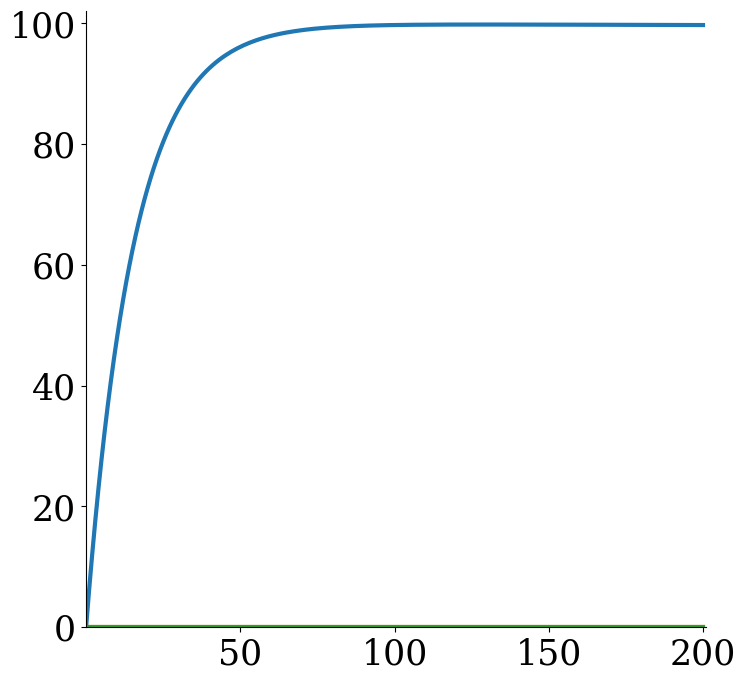

In [782]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [1014]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0]
]

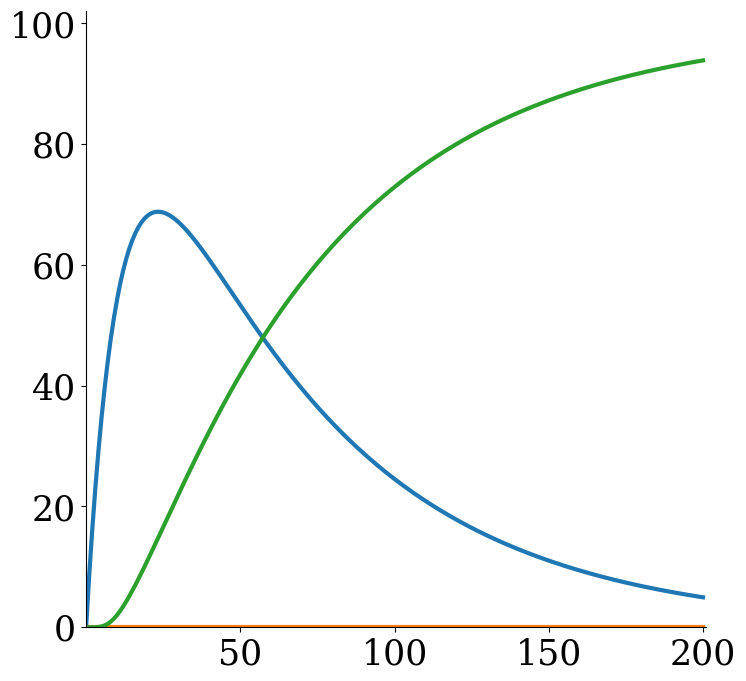

In [784]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [1015]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.05]
]

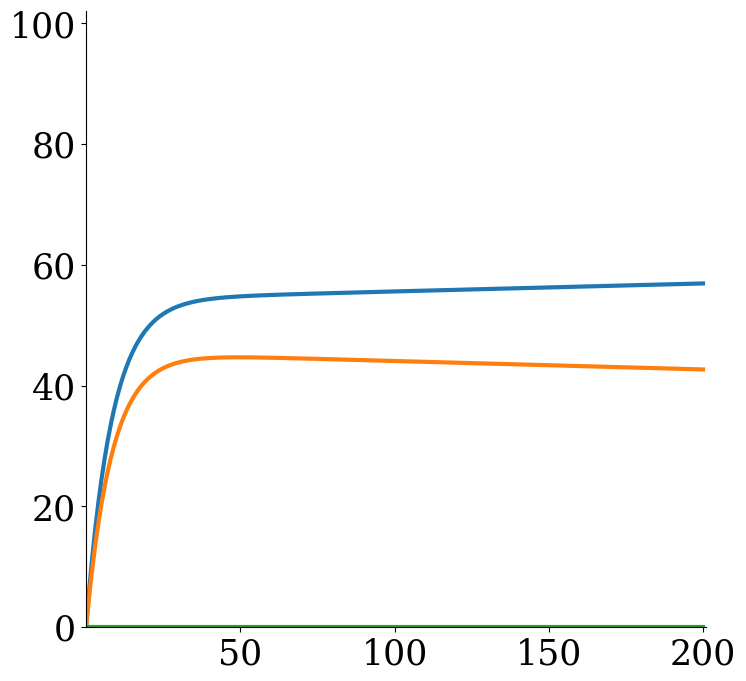

In [786]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [1016]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.5]
]

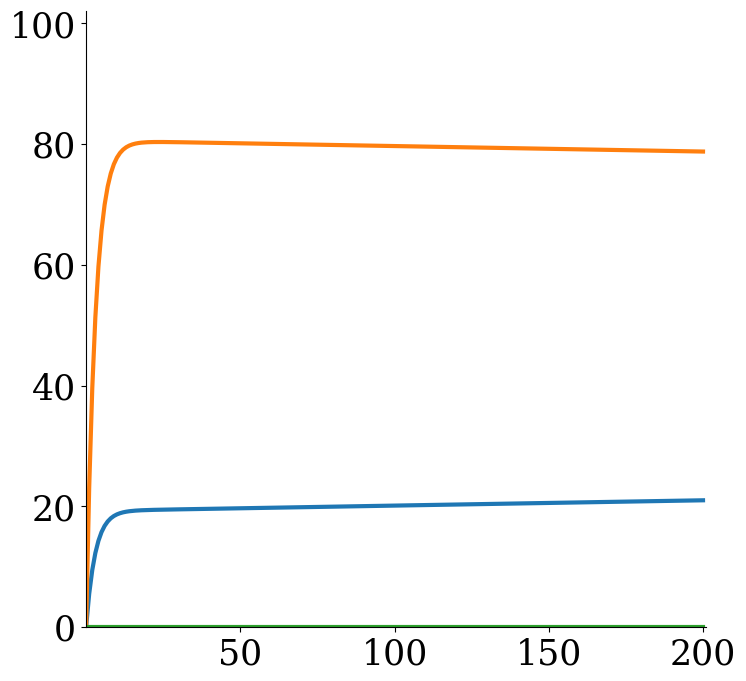

In [788]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [1017]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.05]
]

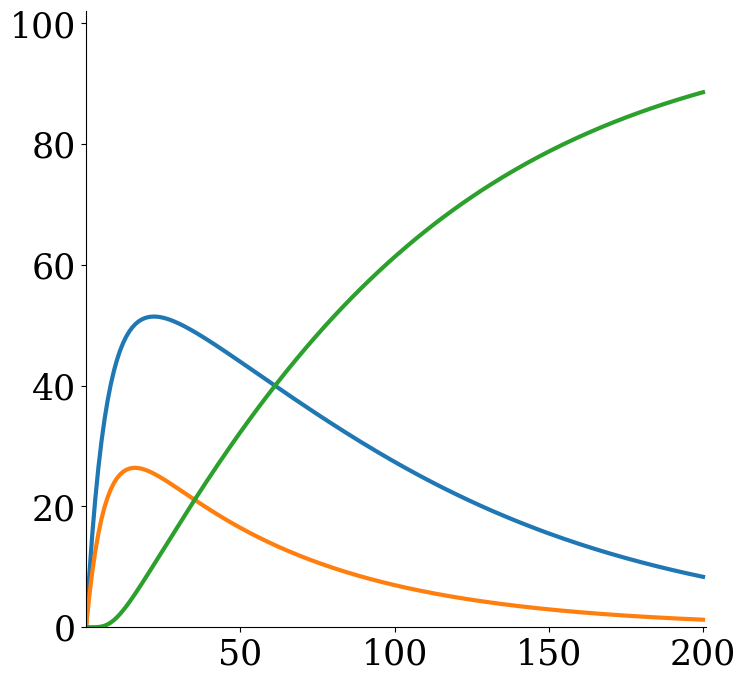

In [790]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [1018]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.5]
]

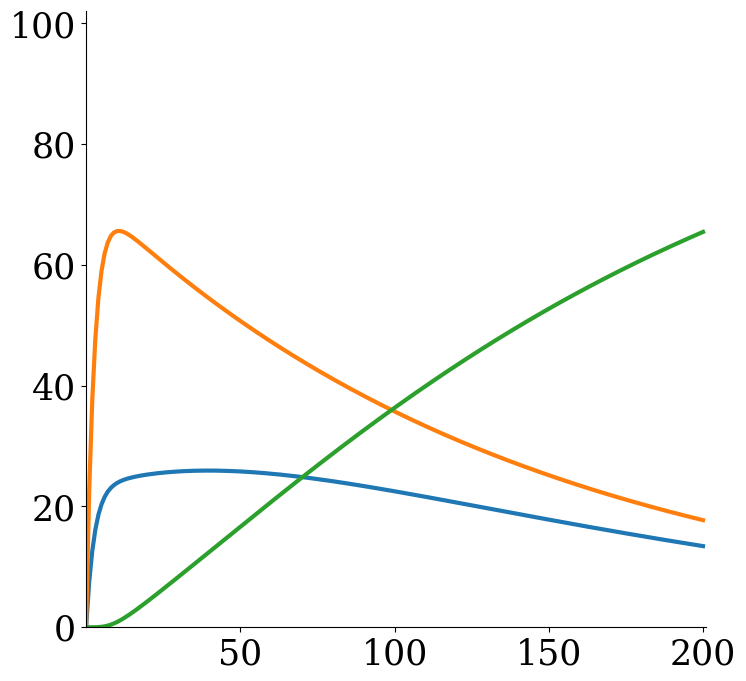

In [792]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [793]:
# Расчет данных AUC и Umax для диапазона ADP
data_raw = auc(min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, ilo_ADP, 20, 5, num_ph=5, conc_type='ADP')
data_ADP = data_raw[0]
relative_responce(data=data_ADP, conc_type='ADP', min_max=max_ADP, phenotypes_list=['auc_a2b3', 'u_a2b3'])

# Загрузка экспериментальных данных
file_path = '/content/ADP_grad.xlsx'
data_ex_ADP = pd.read_excel(file_path)
file_path = '/content/ADP_grad_calculated_range.xlsx'
data_ex_ADP_range = pd.read_excel(file_path)

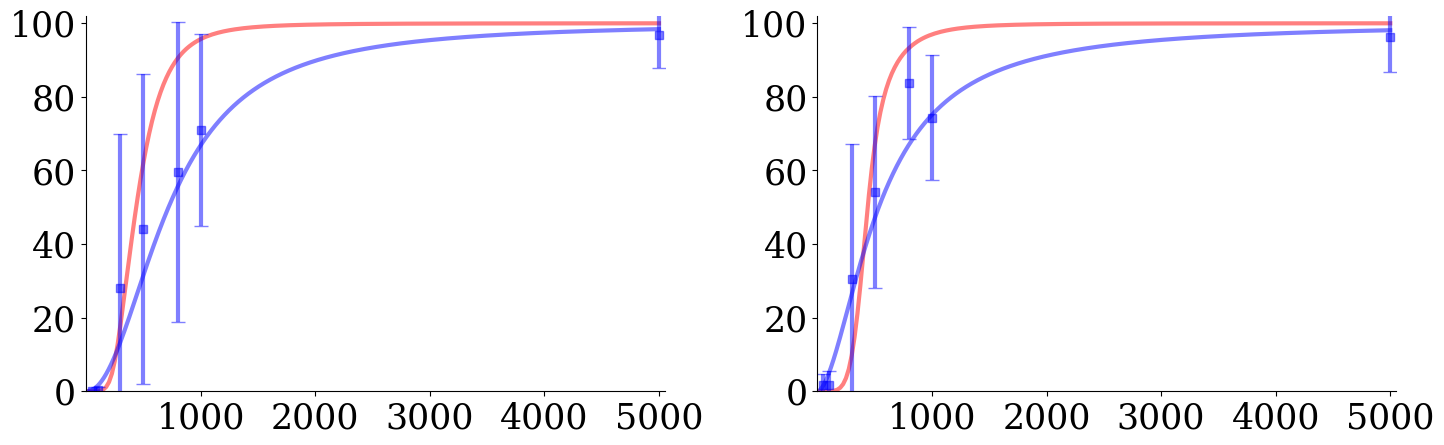

In [794]:
# Пример использования
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ADP, data_ex_ADP, data_ex_ADP_range, axs, 'ADP', phenotypes_list=['auc_a2b3', 'u_a2b3'], legend_pos='lower right')

plt.tight_layout()
plt.show()

In [795]:
# Нахождение AUC и Umax
data_raw = auc(min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, ADP_ilo, 20, 5, num_ph=5, conc_type='ilo')
data_ilo = data_raw[0]
relative_responce(data=data_ilo, conc_type='ilo', min_max=min_ilo, phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

file_path = '/content/1000_ADP_ilo_grad.xlsx'
data_ex_ilo = pd.read_excel(file_path)
file_path = '/content/Ilo_grad_calculated_range.xlsx'
data_ex_Ilo_range = pd.read_excel(file_path)

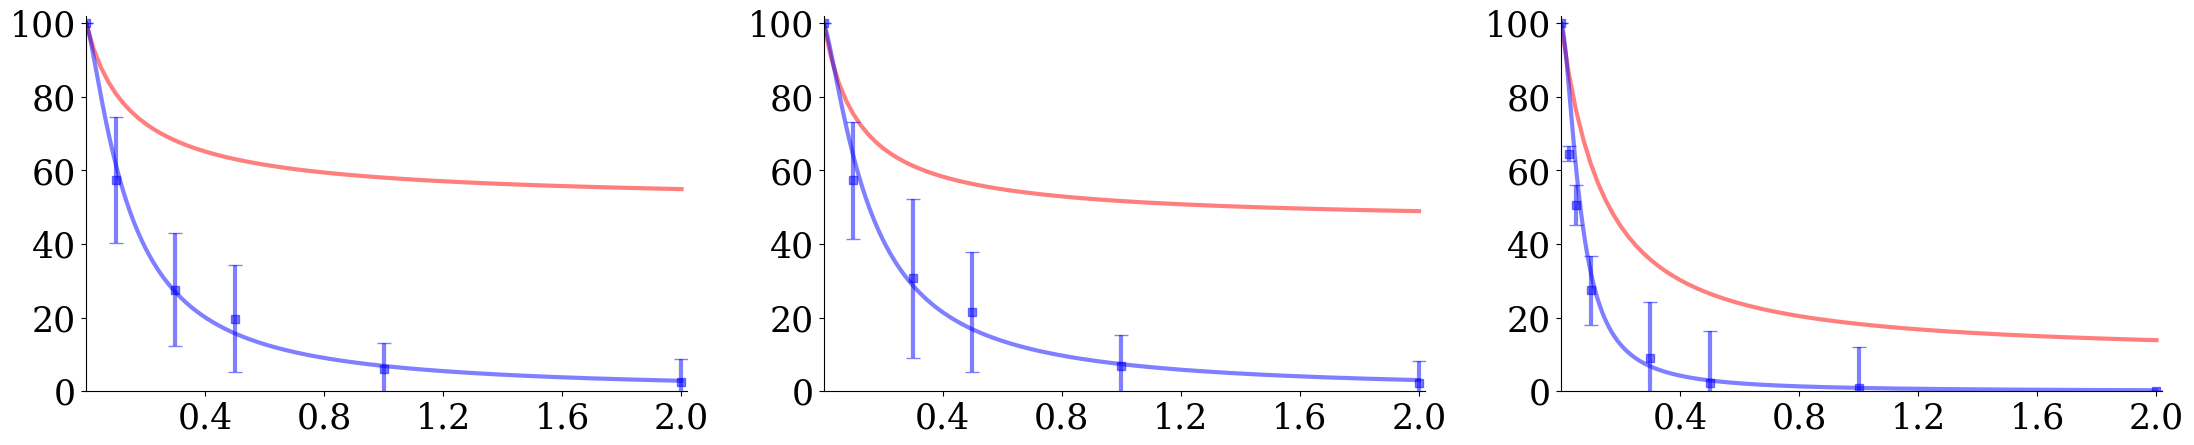

In [796]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=((15 * 1.5), 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ilo, data_ex_ilo, data_ex_Ilo_range, axs, 'ilo', phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

plt.tight_layout()
plt.show()

In [797]:
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 3

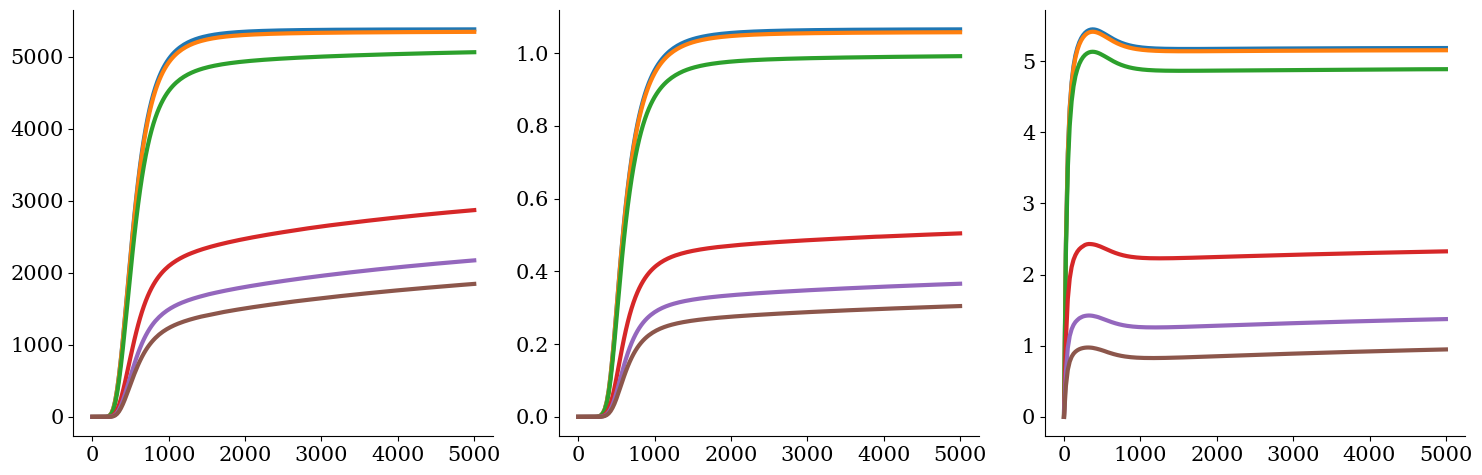

In [798]:

# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ilo_range, min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, num_ph=5, conc_type='ADP')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ADP', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ilo_range)

plt.tight_layout()
plt.show()


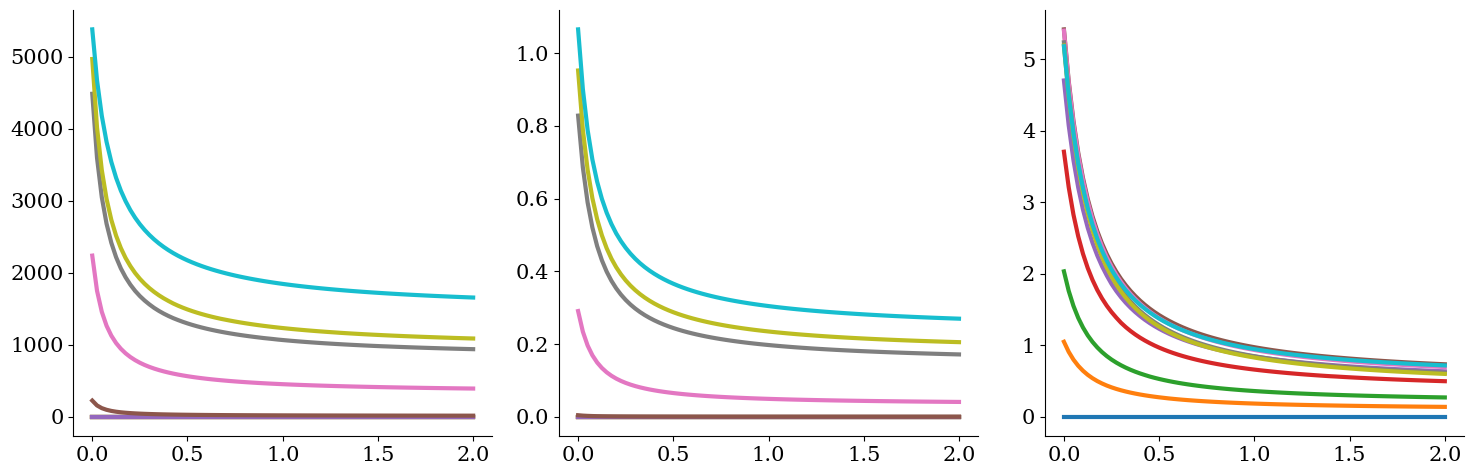

In [799]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ADP_range, min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, num_ph=5, conc_type='ilo')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ilo', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ADP_range)

plt.tight_layout()
plt.show()

##С обратными, без ki для прямых, без ki для обратных

In [800]:
# Система дифференциальных уравнений
def system(t, y):
    N_rest, N_sph, N_inh, N_gp, N_aggr, N_dsen = y
    dN_rest_dt = k21 * N_inh + k11 * N_dsen - k12 * N_rest - k1 * N_rest
    dN_sph_dt = k1 * N_rest - k2 * N_sph - k5 * N_sph
    dN_inh_dt = k12 * N_rest - k21 * N_inh
    dN_gp_dt = k2 * N_sph - k3 * (N_gp ** 2) - k6 * N_gp
    dN_aggr_dt = k3 * (N_gp ** 2) - k7 * N_aggr
    dN_dsen_dt = k5 * N_sph + k6 * N_gp + k7 * N_aggr - k11 * N_dsen

    return [dN_rest_dt, dN_sph_dt, dN_inh_dt, dN_gp_dt, dN_aggr_dt, dN_dsen_dt]

In [801]:
# Решение системы дифф. уравнений
def calculate_concetrations(points, max_time, y0):

    y0 = y0

    for i in range(len(points)):

        ADP = points[i][1]
        ilo = points[i][2]

        global ki_1, ki_3, k1, k12, k21, km_2, ki_2, k2, k5, km_3, ki_3, k3, k6, k7

        k1 = calculate_k_simple(k1_max, ADP, h_k1, EC50_k1)

        k2 = calculate_k_simple(k2_max, ADP, h_k2, EC50_k2)

        k3 = calculate_k_simple(k3_max, ADP, h_k3, EC50_k3)

        k12 = calculate_k_simple(k12_max, ilo, h_k12, EC50_k12)
        k21 = calculate_k_simple(k21_max, ADP, h_k21, EC50_k21)

        k5 = calculete_reverse(k5_max, IC50_k5, h_k5, ADP)
        k6 = calculete_reverse(k6_max, IC50_k6, h_k6, ADP)
        k7 = calculete_reverse(k7_max, IC50_k7, h_k7, ADP)


        # Начальные условия

        start = points[i][0]

        if i < len(points) - 1:
            end = points[i + 1][0]
        else:
            end = max_time
        step = end - start + 1

        # Временной интервал
        t_span = (start, end)
        t_eval = np.linspace(*t_span, step)

        sol = solve_ivp(system, t_span, y0, t_eval=t_eval, method='BDF', events=event_negative)

        df = pd.DataFrame(sol.y.T, columns=['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen'])
        df['Time'] = sol.t

        # Сумма
        df['Summ'] = df[['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen']].sum(axis=1)

        # Перестановка столбцов для удобства
        df = df[['Time', 'Summ', 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen']]

        if i > 0:
            results = pd.concat([results, df.iloc[1:]], axis=0)
        else:
            results = df

        y0 = sol.y.T[-1]

    return results

In [802]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0]
]

In [803]:
plt.rcParams['font.size'] = 25
plt.rcParams['lines.linewidth'] = 3

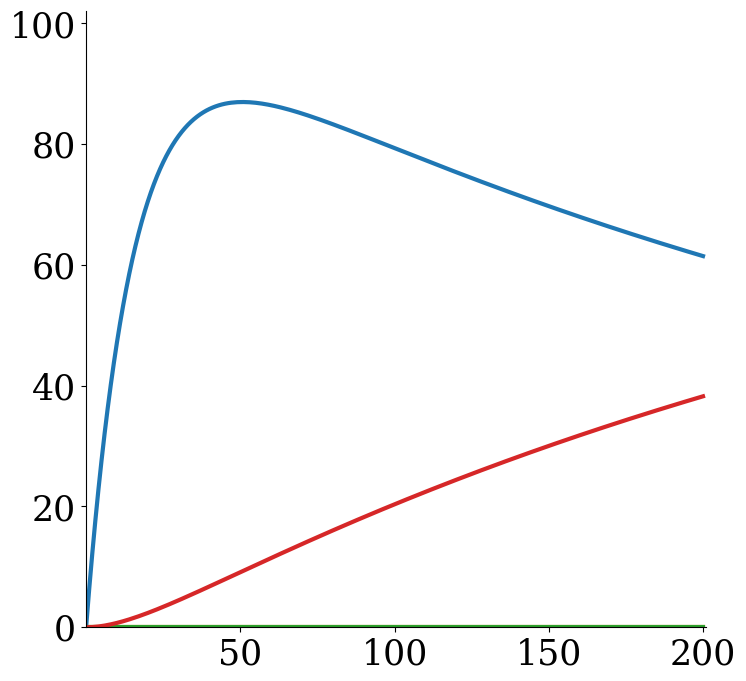

In [804]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [805]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0]
]

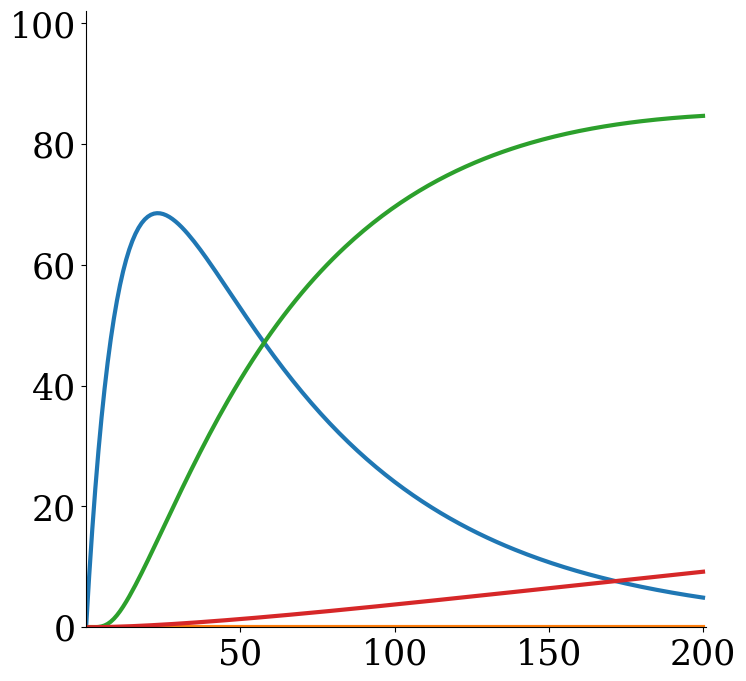

In [806]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [807]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.05]
]

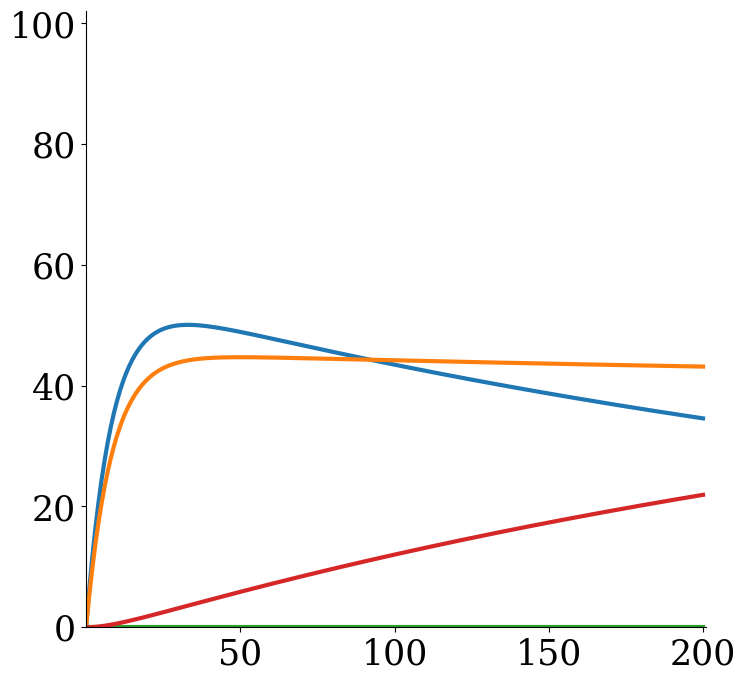

In [808]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [809]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.5]
]

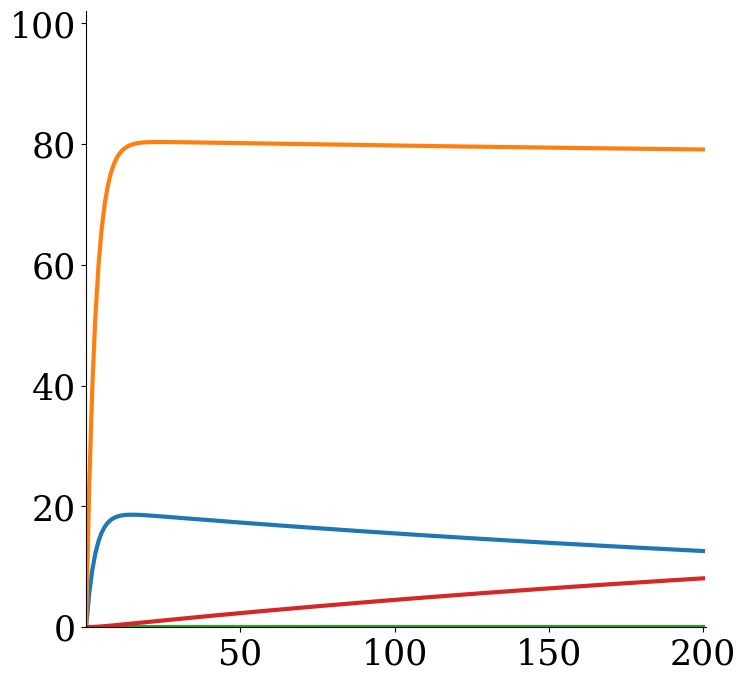

In [810]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [811]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.05]
]

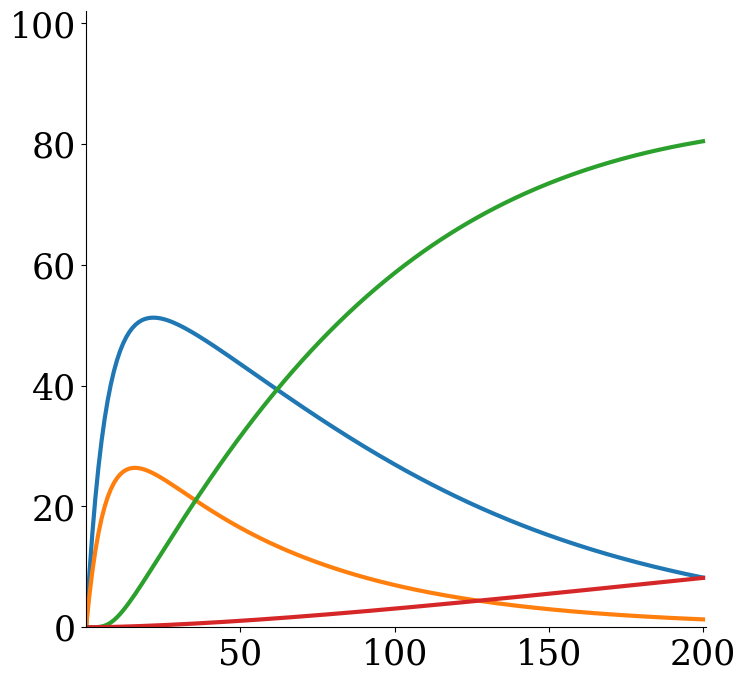

In [812]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [813]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.5]
]

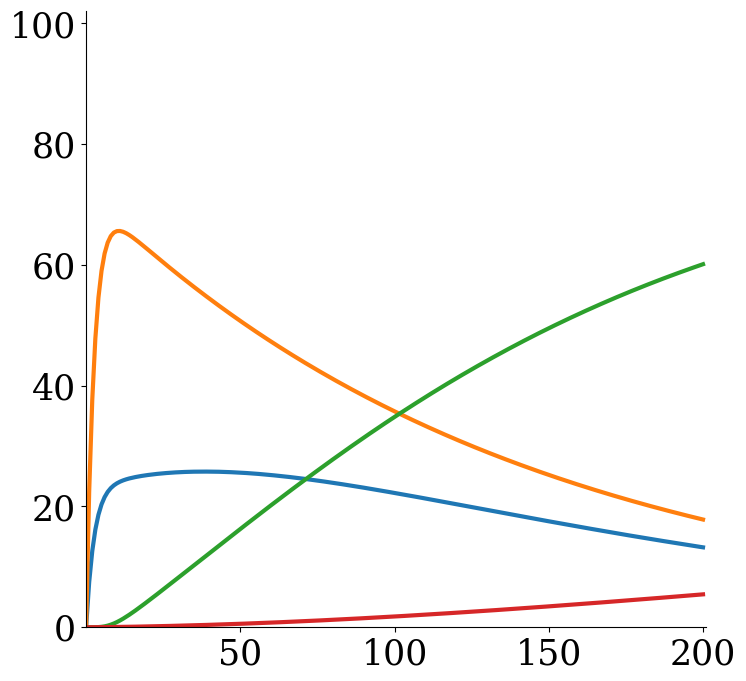

In [814]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [815]:
# Расчет данных AUC и Umax для диапазона ADP
data_raw = auc(min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, ilo_ADP, 20, 5, num_ph=6, conc_type='ADP')
data_ADP = data_raw[0]
relative_responce(data=data_ADP, conc_type='ADP', min_max=max_ADP, phenotypes_list=['auc_a2b3', 'u_a2b3'])

# Загрузка экспериментальных данных
file_path = '/content/ADP_grad.xlsx'
data_ex_ADP = pd.read_excel(file_path)
file_path = '/content/ADP_grad_calculated_range.xlsx'
data_ex_ADP_range = pd.read_excel(file_path)

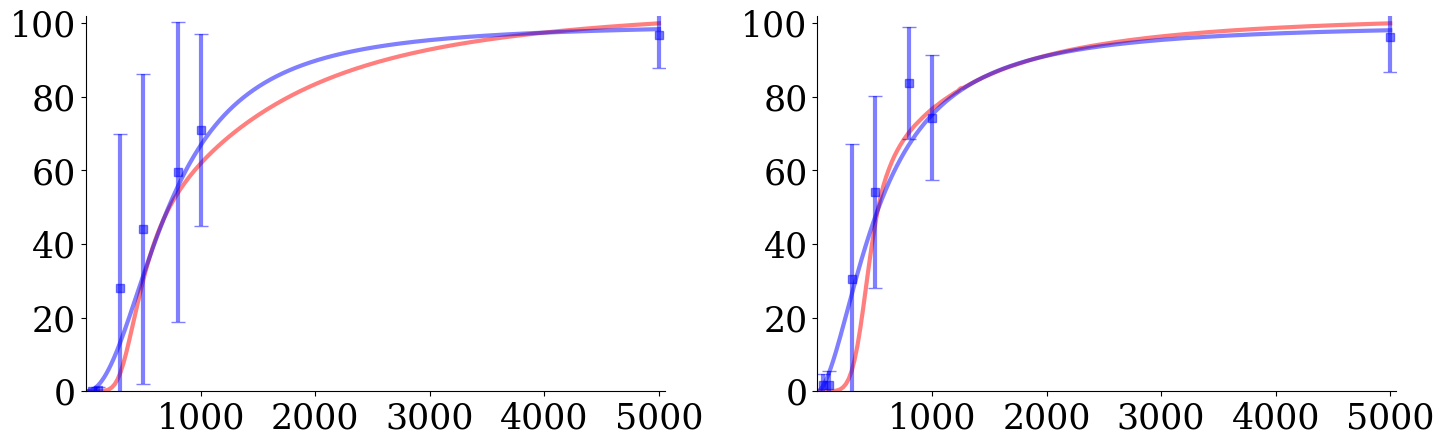

In [816]:
# Пример использования
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ADP, data_ex_ADP, data_ex_ADP_range, axs, 'ADP', phenotypes_list=['auc_a2b3', 'u_a2b3'], legend_pos='lower right')

plt.tight_layout()
plt.show()

In [817]:
# Нахождение AUC и Umax
data_raw = auc(min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, ADP_ilo, 20, 5, num_ph=6, conc_type='ilo')
data_ilo = data_raw[0]
relative_responce(data=data_ilo, conc_type='ilo', min_max=min_ilo, phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

file_path = '/content/1000_ADP_ilo_grad.xlsx'
data_ex_ilo = pd.read_excel(file_path)
file_path = '/content/Ilo_grad_calculated_range.xlsx'
data_ex_Ilo_range = pd.read_excel(file_path)

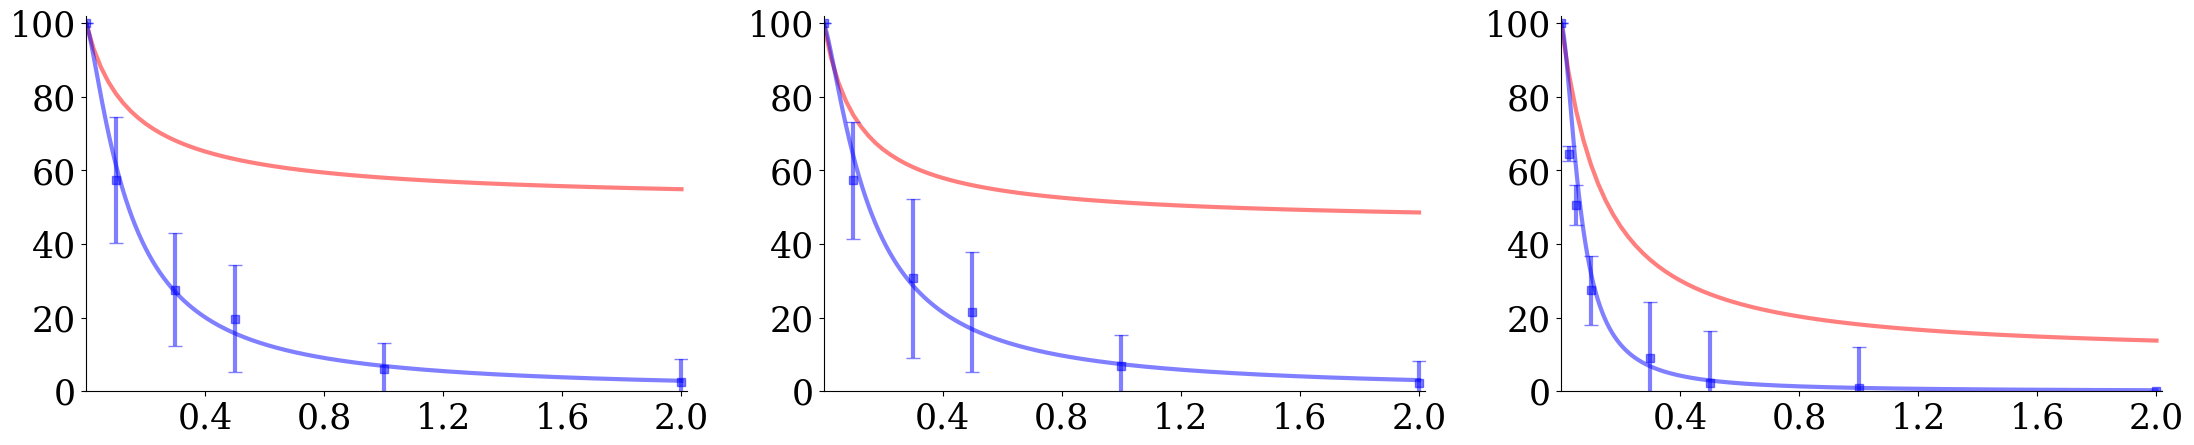

In [818]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=((15 * 1.5), 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ilo, data_ex_ilo, data_ex_Ilo_range, axs, 'ilo', phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

plt.tight_layout()
plt.show()

In [819]:
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 3

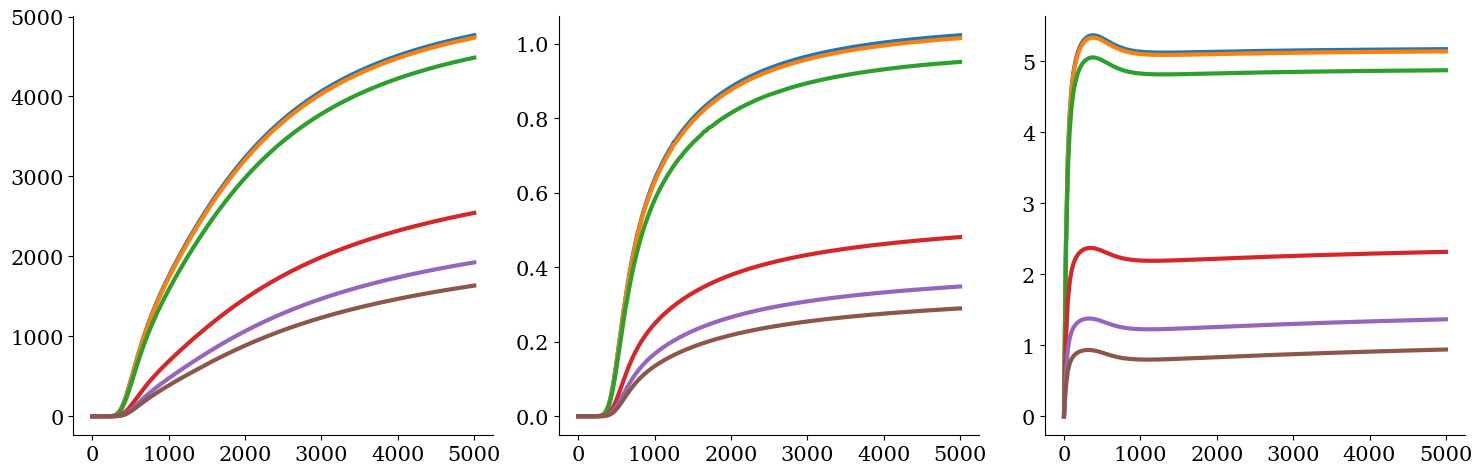

In [820]:

# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ilo_range, min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, num_ph=6, conc_type='ADP')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ADP', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ilo_range)

plt.tight_layout()
plt.show()


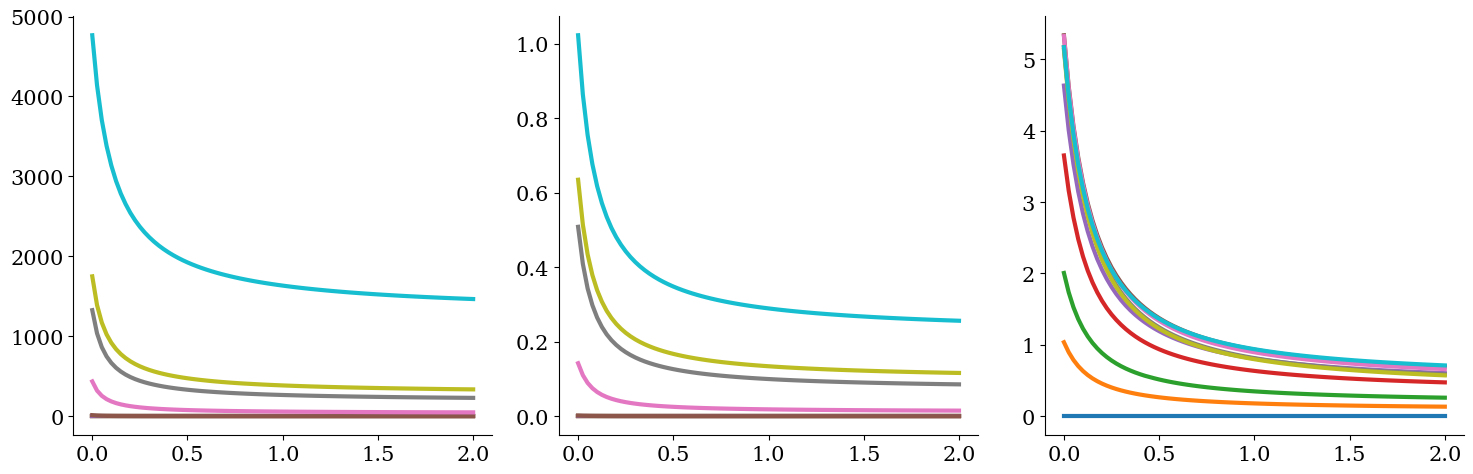

In [821]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ADP_range, min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, num_ph=6, conc_type='ilo')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ilo', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ADP_range)

plt.tight_layout()
plt.show()

## Без обратных, с ki для прямых, без ki для обратных

In [822]:
# Система дифференциальных уравнений
def system(t, y):
    N_rest, N_sph, N_inh, N_gp, N_aggr = y
    dN_rest_dt = k21 * N_inh - k12 * N_rest - k1 * N_rest
    dN_sph_dt = k1 * N_rest - k2 * N_sph
    dN_inh_dt = k12 * N_rest - k21 * N_inh
    dN_gp_dt = k2 * N_sph - k3 * (N_gp ** 2)
    dN_aggr_dt = k3 * (N_gp ** 2)

    return [dN_rest_dt, dN_sph_dt, dN_inh_dt, dN_gp_dt, dN_aggr_dt]

In [823]:
k1_list = []
ki_1_list = []
k2_list = []
ki_2_list = []
k3_list = []
k12_list = []
k21_list = []

# Решение системы дифф. уравнений
def calculate_concetrations(points, max_time, y0):

    y0 = y0

    for i in range(len(points)):

        ADP = points[i][1]
        ilo = points[i][2]

        global ki_1, ki_3, k1, k12, k21, km_2, ki_2, k2, km_3, ki_3, k3

        ki_1 = calculate_k_inh(IC50_k1_ilo, h_k1_ilo, ADP, EC50_k1)
        k1 = calculate_k_with_inh(k1_max, ADP, h_k1, EC50_k1, ilo, ki_1)

        ki_2 = calculate_k_inh(IC50_k2_ilo, h_k2_ilo, ADP, EC50_k2)
        k2 = calculate_k_with_inh(k2_max, ADP, h_k2, EC50_k2, ilo, ki_2)

        ki_3 = calculate_k_inh(IC50_k3_ilo, h_k3_ilo, ADP, EC50_k3)
        k3 = calculate_k_with_inh(k3_max, ADP, h_k3, EC50_k3, ilo, ki_3)

        k12 = calculate_k_simple(k12_max, ilo, h_k12, EC50_k12)
        k21 = calculate_k_simple(k21_max, ADP, h_k21, EC50_k21)

        ki_1_list.append(calculate_k_inh(IC50_k1_ilo, h_k1_ilo, ADP, EC50_k1))
        k1_list.append(calculate_k_with_inh(k1_max, ADP, h_k1, EC50_k1, ilo, ki_1))
        ki_2_list.append(calculate_k_inh(IC50_k2_ilo, h_k2_ilo, ADP, EC50_k2))
        k2_list.append(calculate_k_with_inh(k2_max, ADP, h_k2, EC50_k2, ilo, ki_2))
        k3_list.append(calculate_k_simple(k3_max, ADP, h_k3, EC50_k3))
        k12_list.append(calculate_k_simple(k12_max, ilo, h_k12, EC50_k12))
        k21_list.append(calculate_k_simple(k21_max, ADP, h_k21, EC50_k21))


        # Начальные условия

        start = points[i][0]

        if i < len(points) - 1:
            end = points[i + 1][0]
        else:
            end = max_time
        step = end - start + 1

        # Временной интервал
        t_span = (start, end)
        t_eval = np.linspace(*t_span, step)

        sol = solve_ivp(system, t_span, y0, t_eval=t_eval, method='BDF', events=event_negative)

        df = pd.DataFrame(sol.y.T, columns=['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr'])
        df['Time'] = sol.t

        # Сумма
        df['Summ'] = df[['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr']].sum(axis=1)

        # Перестановка столбцов для удобства
        df = df[['Time', 'Summ', 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr']]

        if i > 0:
            results = pd.concat([results, df.iloc[1:]], axis=0)
        else:
            results = df

        y0 = sol.y.T[-1]

    return results

In [824]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0]
]

In [825]:
plt.rcParams['font.size'] = 25
plt.rcParams['lines.linewidth'] = 3

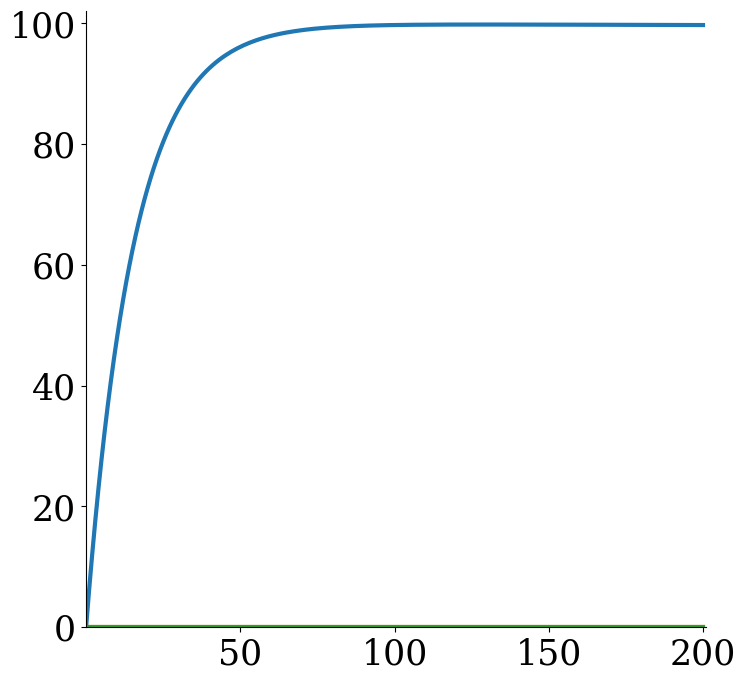

In [826]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [827]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0]
]

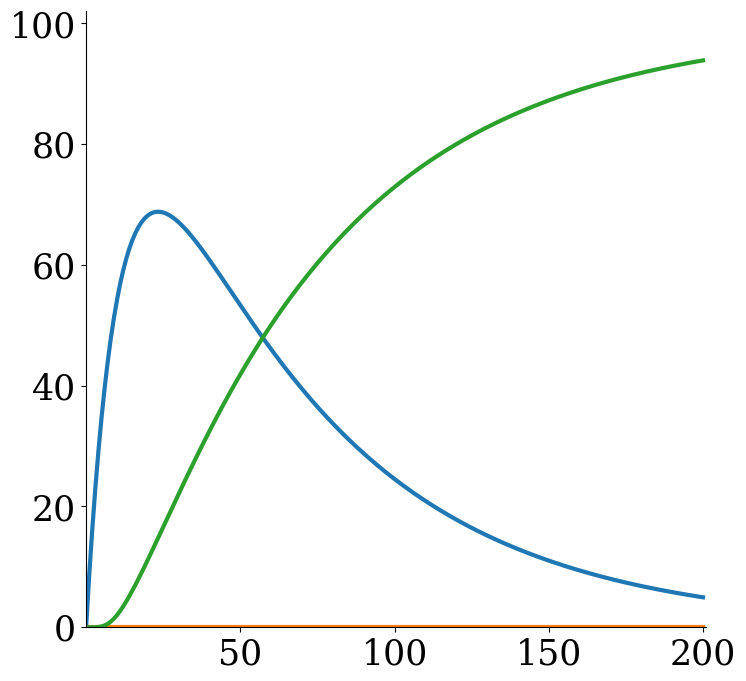

In [828]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [829]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.05]
]

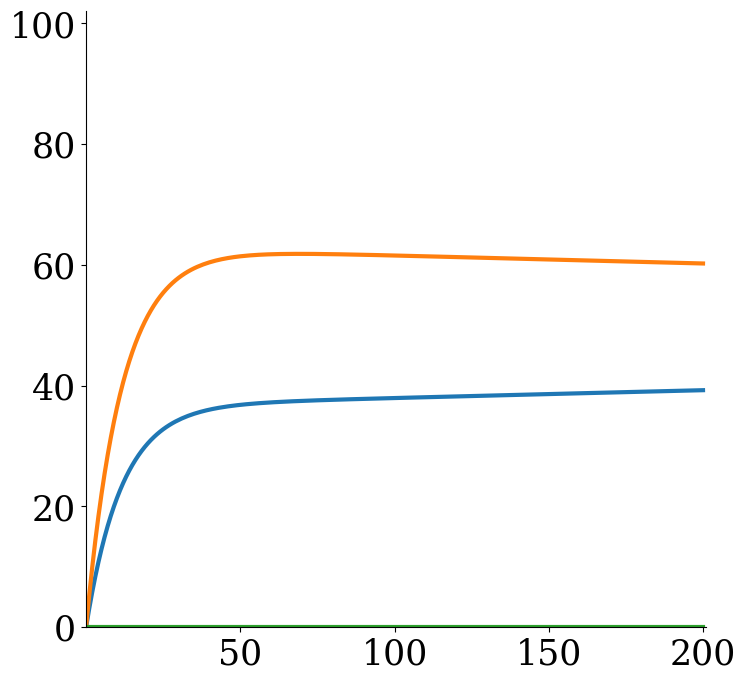

In [830]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [831]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.5]
]

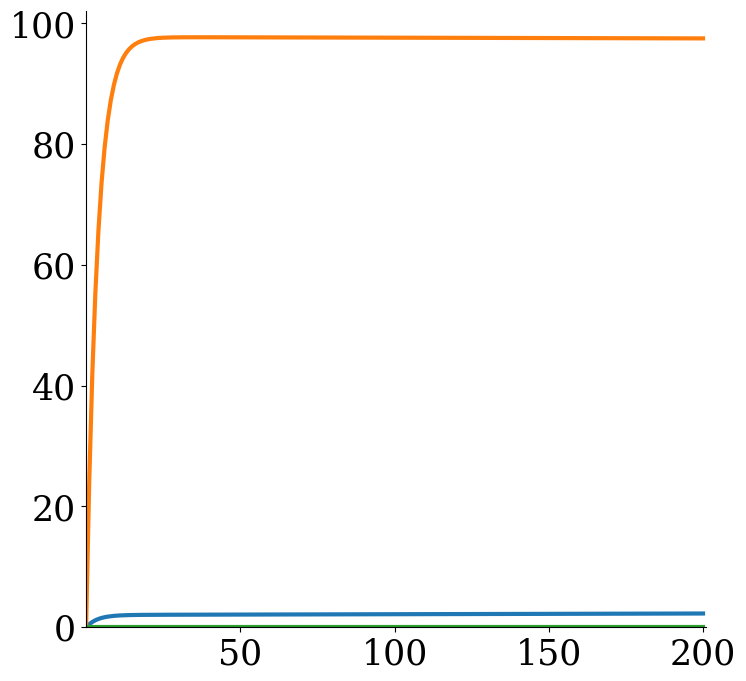

In [832]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [833]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.05]
]

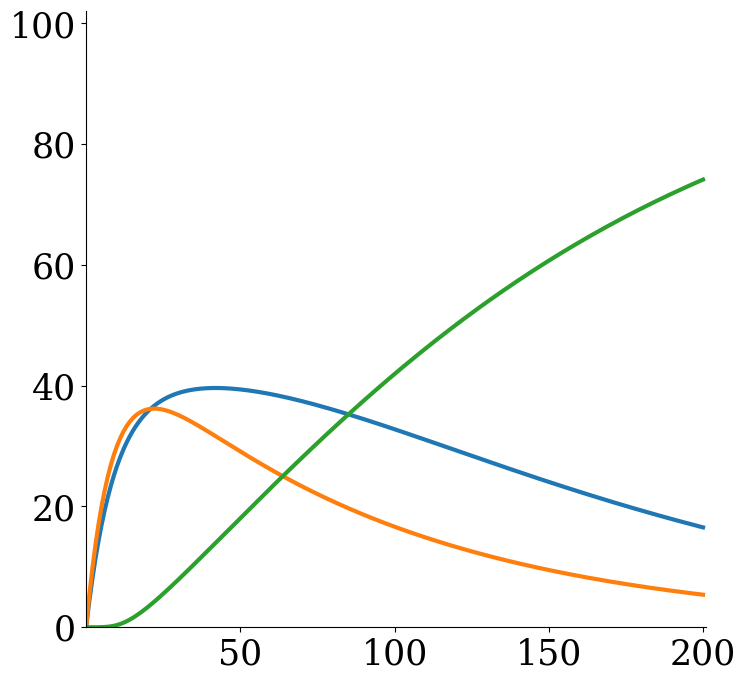

In [834]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [835]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.5]
]

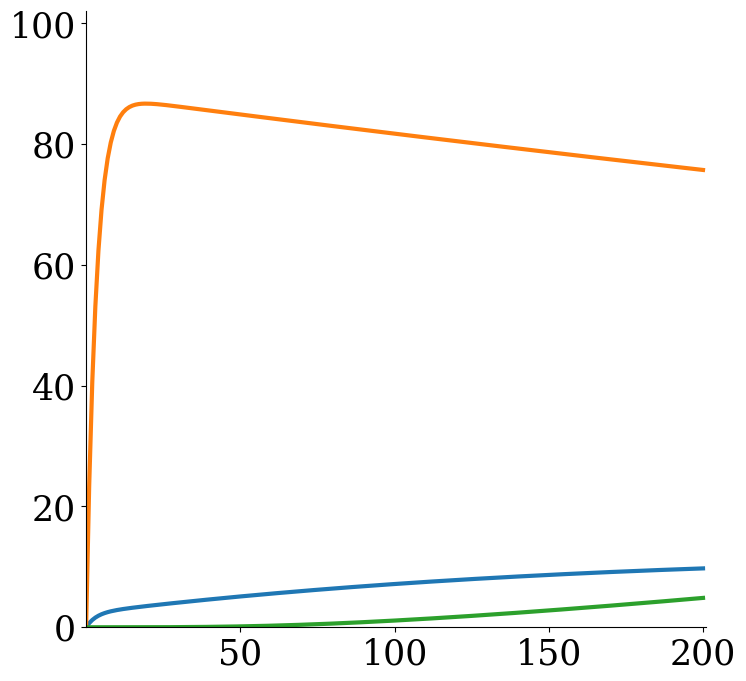

In [836]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [837]:
# Расчет данных AUC и Umax для диапазона ADP
data_raw = auc(min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, ilo_ADP, 20, 5, num_ph=5, conc_type='ADP')
data_ADP = data_raw[0]
relative_responce(data=data_ADP, conc_type='ADP', min_max=max_ADP, phenotypes_list=['auc_a2b3', 'u_a2b3'])

# Загрузка экспериментальных данных
file_path = '/content/ADP_grad.xlsx'
data_ex_ADP = pd.read_excel(file_path)
file_path = '/content/ADP_grad_calculated_range.xlsx'
data_ex_ADP_range = pd.read_excel(file_path)

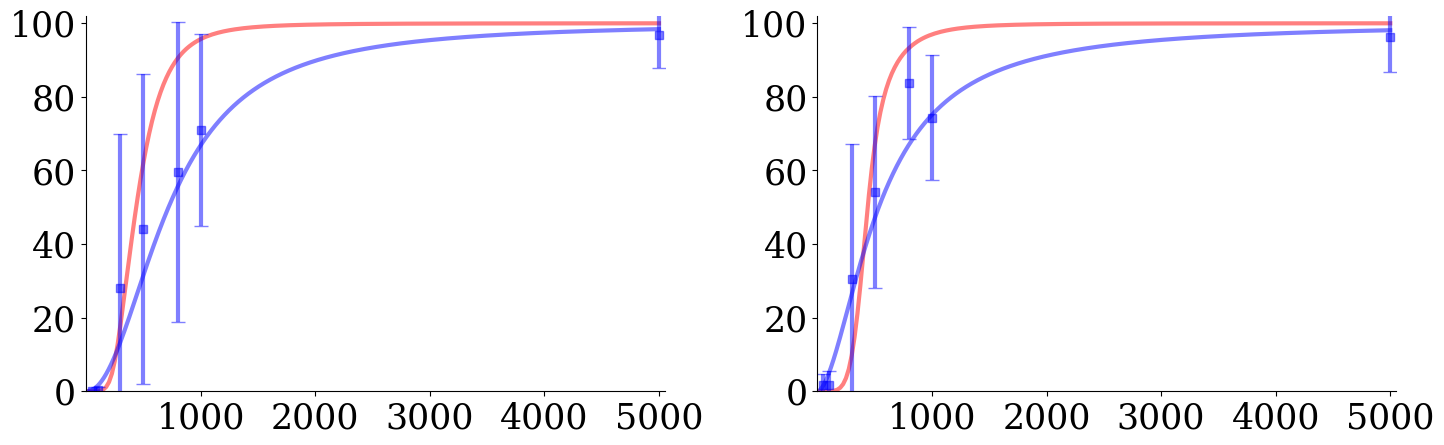

In [838]:
# Пример использования
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ADP, data_ex_ADP, data_ex_ADP_range, axs, 'ADP', phenotypes_list=['auc_a2b3', 'u_a2b3'], legend_pos='lower right')

plt.tight_layout()
plt.show()

In [839]:
# Нахождение AUC и Umax
data_raw = auc(min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, ADP_ilo, 20, 5, num_ph=5, conc_type='ilo')
data_ilo = data_raw[0]
relative_responce(data=data_ilo, conc_type='ilo', min_max=min_ilo, phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

file_path = '/content/1000_ADP_ilo_grad.xlsx'
data_ex_ilo = pd.read_excel(file_path)
file_path = '/content/Ilo_grad_calculated_range.xlsx'
data_ex_Ilo_range = pd.read_excel(file_path)

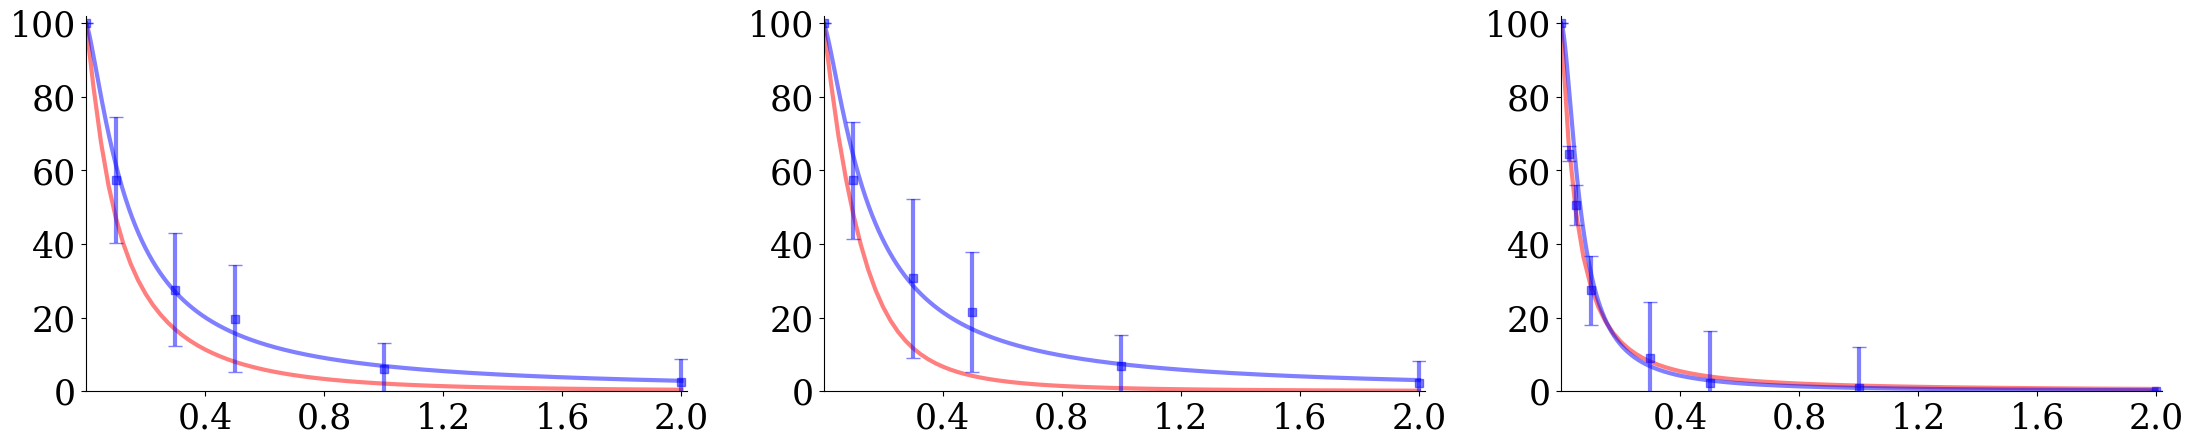

In [840]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=((15 * 1.5), 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ilo, data_ex_ilo, data_ex_Ilo_range, axs, 'ilo', phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

plt.tight_layout()
plt.show()

In [841]:
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 3

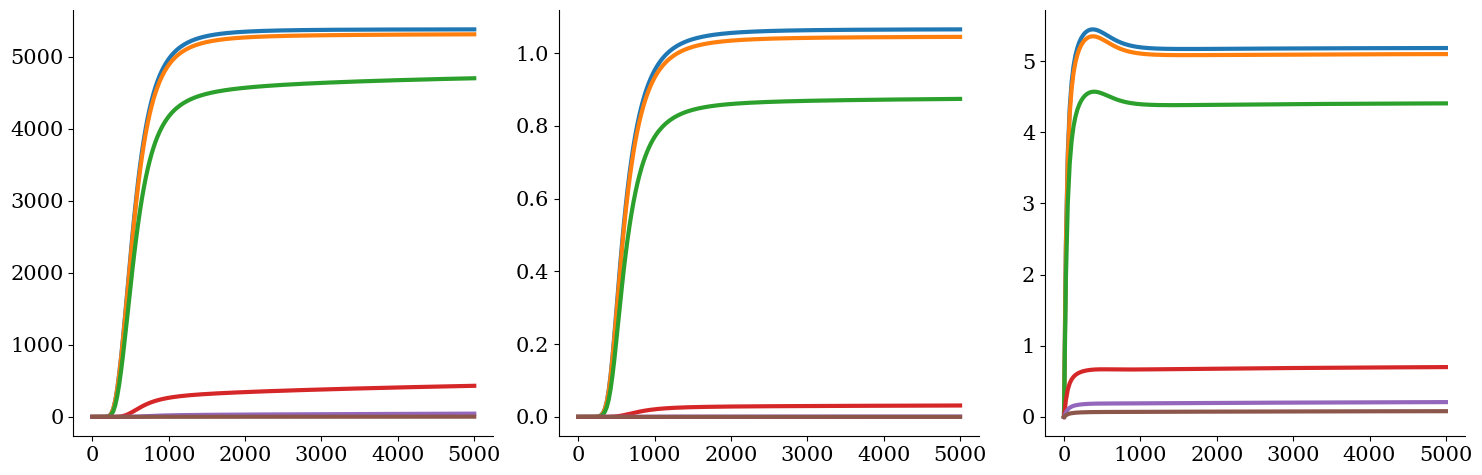

In [842]:

# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ilo_range, min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, num_ph=5, conc_type='ADP')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ADP', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ilo_range)

plt.tight_layout()
plt.show()


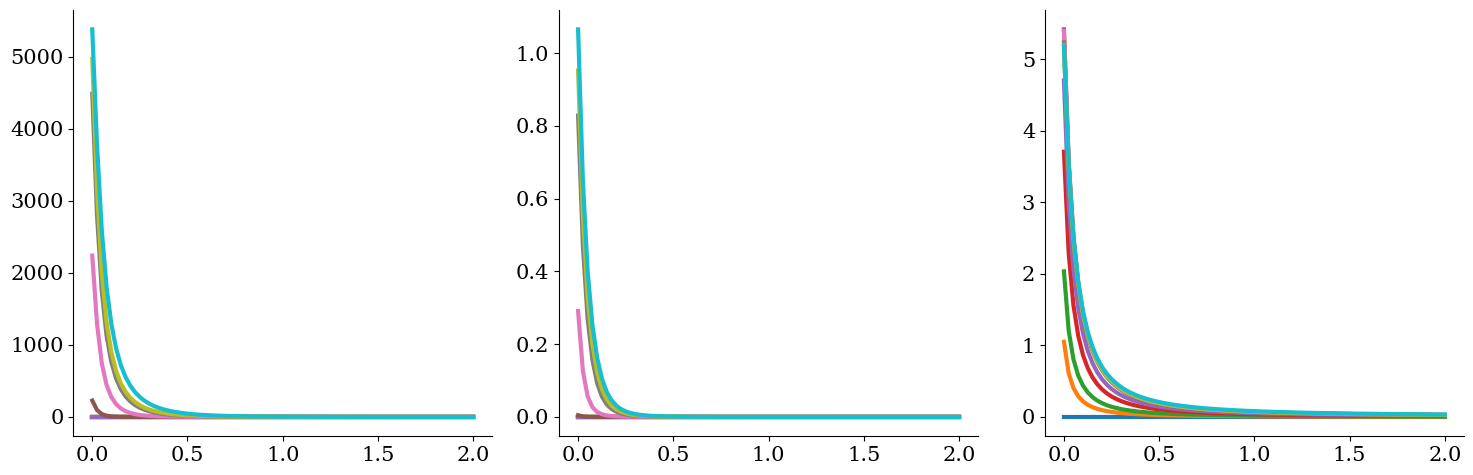

In [843]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ADP_range, min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, num_ph=5, conc_type='ilo')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ilo', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ADP_range)

plt.tight_layout()
plt.show()

##C обратными, с ki для прямых, без ki для обратных

In [844]:
# Система дифференциальных уравнений
def system(t, y):
    N_rest, N_sph, N_inh, N_gp, N_aggr, N_dsen, = y
    dN_rest_dt = k21 * N_inh + k11 * N_dsen - k12 * N_rest - k1 * N_rest
    dN_sph_dt = k1 * N_rest - k2 * N_sph - k5 * N_sph
    dN_inh_dt = k12 * N_rest - k21 * N_inh
    dN_gp_dt = k2 * N_sph - k3 * (N_gp ** 2) - k6 * N_gp
    dN_aggr_dt = k3 * (N_gp ** 2) - k7 * N_aggr
    dN_dsen_dt = k5 * N_sph + k6 * N_gp + k7 * N_aggr - k11 * N_dsen

    return [dN_rest_dt, dN_sph_dt, dN_inh_dt, dN_gp_dt, dN_aggr_dt, dN_dsen_dt]

In [845]:
k1_list = []
ki_1_list = []
k2_list = []
ki_2_list = []
k3_list = []
k5_list = []
k6_list = []
k7_list = []
k12_list = []
k21_list = []



# Решение системы дифф. уравнений
def calculate_concetrations(points, max_time, y0):

    y0 = y0

    for i in range(len(points)):

        ADP = points[i][1]
        ilo = points[i][2]

        global ki_1, ki_3, k1, k12, k21, km_2, ki_2, k2, k5, km_3, ki_3, k3, k6, k7 # при добавлении новых реакций, все константы должны быть перечислены здесь

        # нахождение констант (по формулам выше)

        ki_1 = calculate_k_inh(IC50_k1_ilo, h_k1_ilo, ADP, EC50_k1)
        k1 = calculate_k_with_inh(k1_max, ADP, h_k1, EC50_k1, ilo, ki_1)

        ki_2 = calculate_k_inh(IC50_k2_ilo, h_k2_ilo, ADP, EC50_k2)
        k2 = calculate_k_with_inh(k2_max, ADP, h_k2, EC50_k2, ilo, ki_2)

        k3 = calculate_k_simple(k3_max, ADP, h_k3, EC50_k3)

        k12 = calculate_k_simple(k12_max, ilo, h_k12, EC50_k12)
        k21 = calculate_k_simple(k21_max, ADP, h_k21, EC50_k21)

        k5 = calculete_reverse(k5_max, IC50_k5, h_k5, ADP)
        k6 = calculete_reverse(k6_max, IC50_k6, h_k6, ADP)
        k7 = calculete_reverse(k7_max, IC50_k7, h_k7, ADP)


        ki_1_list.append(calculate_k_inh(IC50_k1_ilo, h_k1_ilo, ADP, EC50_k1))
        k1_list.append(calculate_k_with_inh(k1_max, ADP, h_k1, EC50_k1, ilo, ki_1))
        ki_2_list.append(calculate_k_inh(IC50_k2_ilo, h_k2_ilo, ADP, EC50_k2))
        k2_list.append(calculate_k_with_inh(k2_max, ADP, h_k2, EC50_k2, ilo, ki_2))
        k3_list.append(calculate_k_simple(k3_max, ADP, h_k3, EC50_k3))
        k5_list.append(calculete_reverse(k5_max, IC50_k5, h_k5, ADP))
        k6_list.append(calculete_reverse(k6_max, IC50_k6, h_k6, ADP))
        k7_list.append(calculete_reverse(k7_max, IC50_k7, h_k7, ADP))
        k12_list.append(calculate_k_simple(k12_max, ilo, h_k12, EC50_k12))
        k21_list.append(calculate_k_simple(k21_max, ADP, h_k21, EC50_k21))

        # Начальные условия

        start = points[i][0]

        if i < len(points) - 1:
            end = points[i + 1][0]
        else:
            end = max_time
        step = end - start + 1

        # Временной интервал
        t_span = (start, end)
        t_eval = np.linspace(*t_span, step)

        sol = solve_ivp(system, t_span, y0, t_eval=t_eval, method='BDF', events=event_negative)

        df = pd.DataFrame(np.array(sol.y).T, columns=['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen'])
        df['Time'] = sol.t

        # Сумма
        df['Summ'] = df[['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen']].sum(axis=1)

        # Перестановка столбцов для удобства
        df = df[['Time', 'Summ', 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen']]

        if i > 0:
            results = pd.concat([results, df.iloc[1:]], axis=0)
        else:
            results = df

        y0 = sol.y.T[-1]

    return results

In [846]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0]
]

In [847]:
plt.rcParams['font.size'] = 25
plt.rcParams['lines.linewidth'] = 3

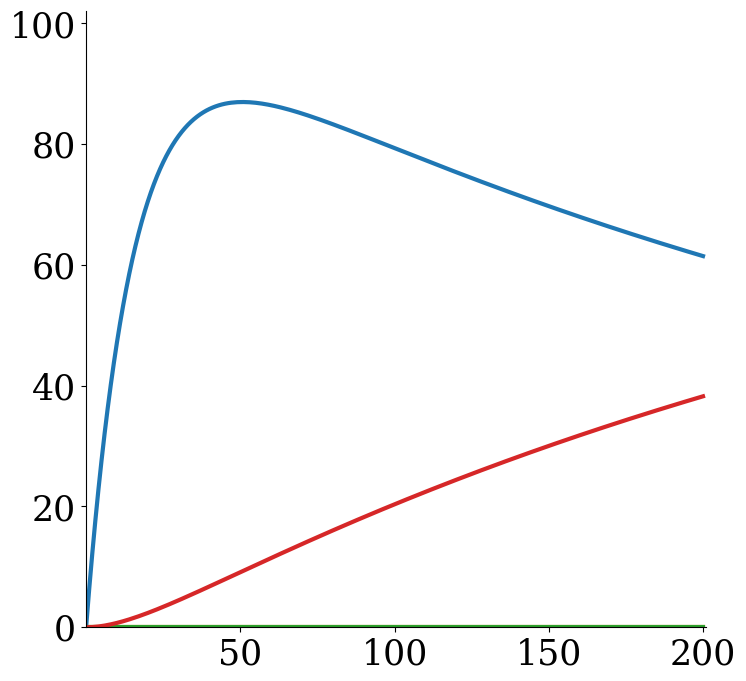

In [848]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [849]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0]
]

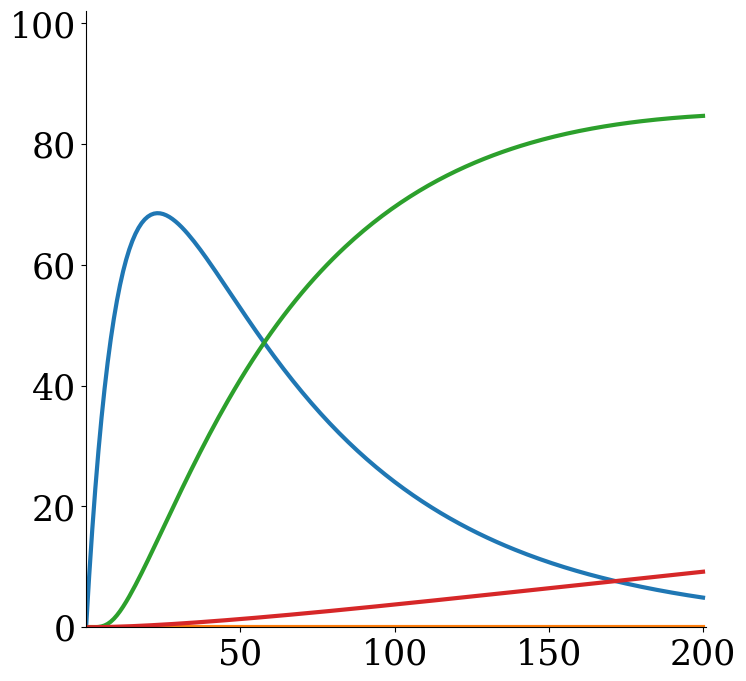

In [850]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [851]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.05]
]

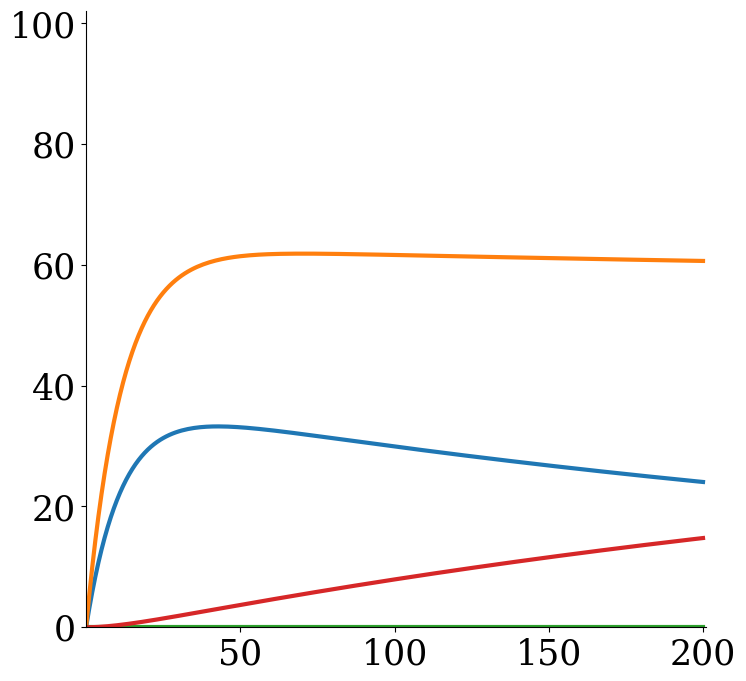

In [852]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [853]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.5]
]

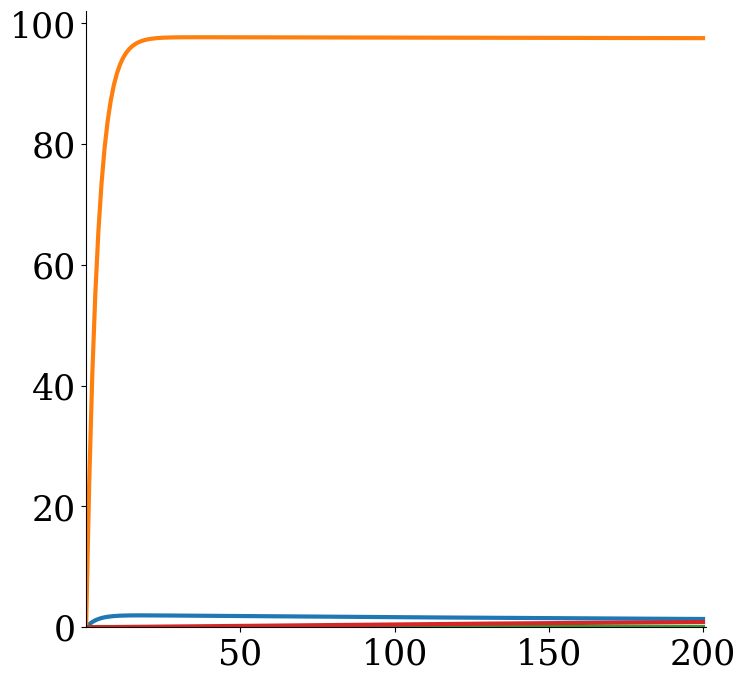

In [854]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [855]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.05]
]

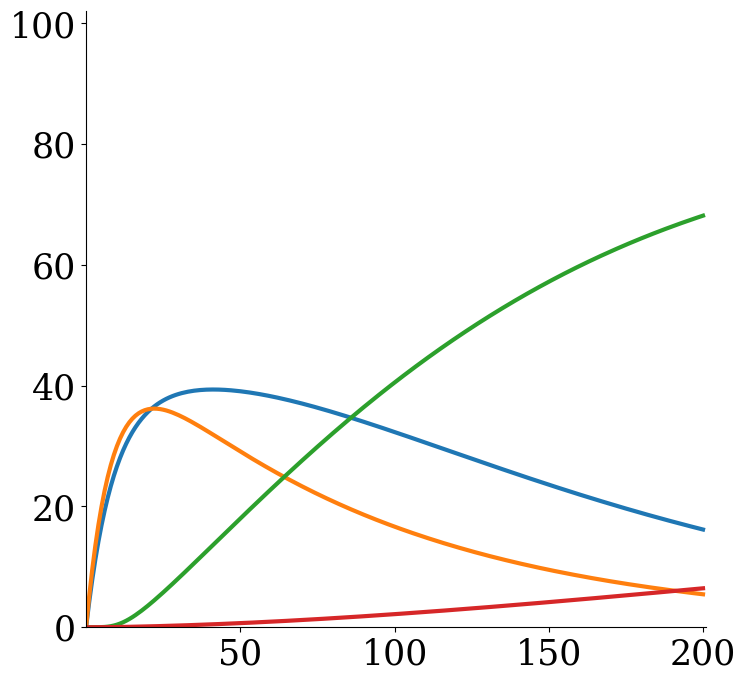

In [856]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [857]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.5]
]

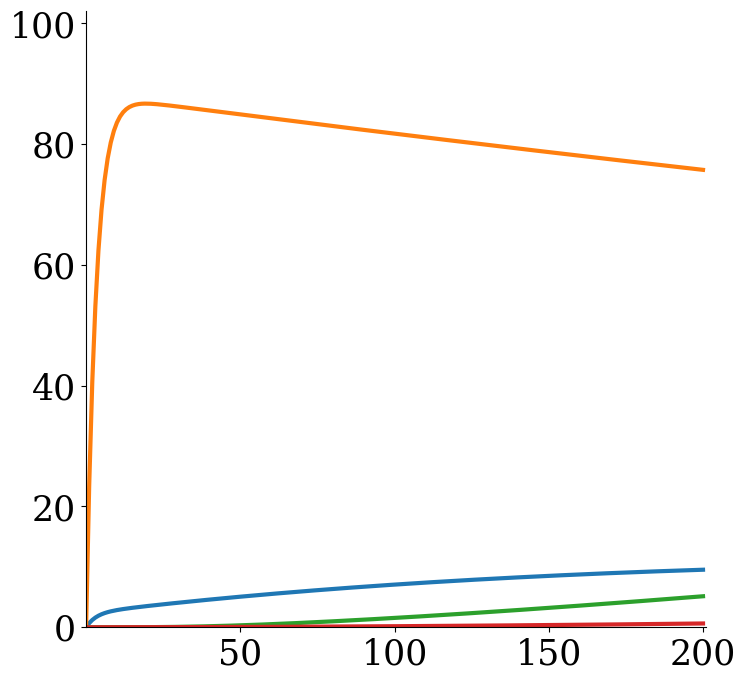

In [858]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [859]:
# Расчет данных AUC и Umax для диапазона ADP
data_raw = auc(min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, ilo_ADP, 20, 5, num_ph=6, conc_type='ADP')
data_ADP = data_raw[0]
relative_responce(data=data_ADP, conc_type='ADP', min_max=max_ADP, phenotypes_list=['auc_a2b3', 'u_a2b3'])

# Загрузка экспериментальных данных
file_path = '/content/ADP_grad.xlsx'
data_ex_ADP = pd.read_excel(file_path)
file_path = '/content/ADP_grad_calculated_range.xlsx'
data_ex_ADP_range = pd.read_excel(file_path)

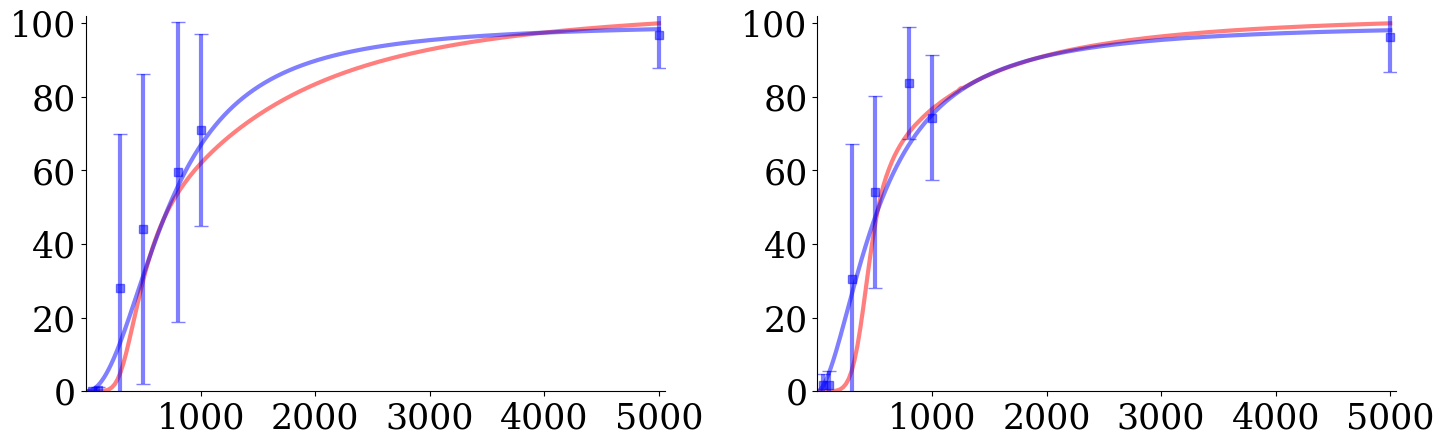

In [860]:
# Пример использования
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ADP, data_ex_ADP, data_ex_ADP_range, axs, 'ADP', phenotypes_list=['auc_a2b3', 'u_a2b3'], legend_pos='lower right')

plt.tight_layout()
plt.show()

In [861]:
# Нахождение AUC и Umax
data_raw = auc(min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, ADP_ilo, 20, 5, num_ph=6, conc_type='ilo')
data_ilo = data_raw[0]
relative_responce(data=data_ilo, conc_type='ilo', min_max=min_ilo, phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

file_path = '/content/1000_ADP_ilo_grad.xlsx'
data_ex_ilo = pd.read_excel(file_path)
file_path = '/content/Ilo_grad_calculated_range.xlsx'
data_ex_Ilo_range = pd.read_excel(file_path)

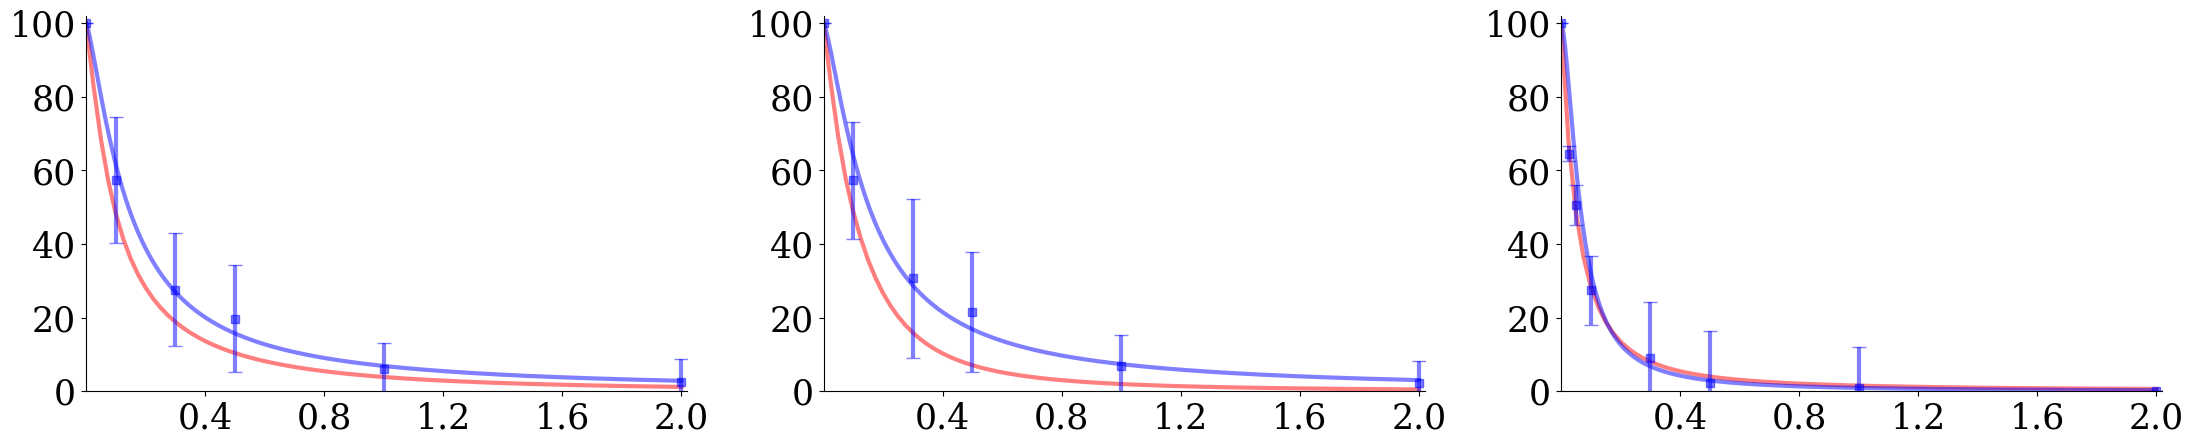

In [862]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=((15 * 1.5), 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ilo, data_ex_ilo, data_ex_Ilo_range, axs, 'ilo', phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

plt.tight_layout()
plt.show()

In [863]:
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 3

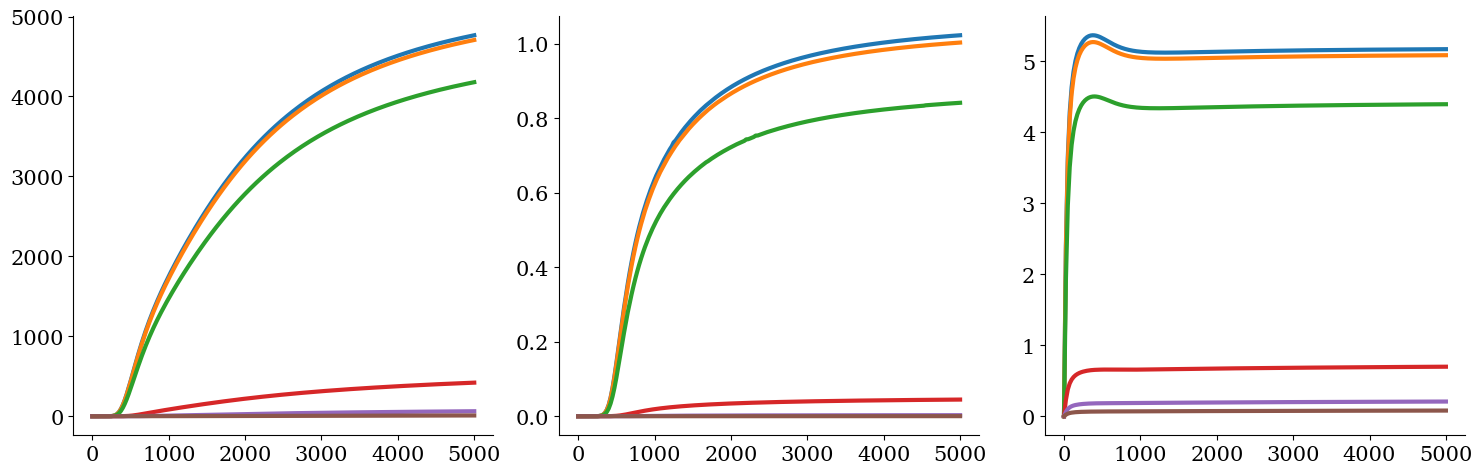

In [864]:

# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ilo_range, min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, num_ph=6, conc_type='ADP')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ADP', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ilo_range)

plt.tight_layout()
plt.show()


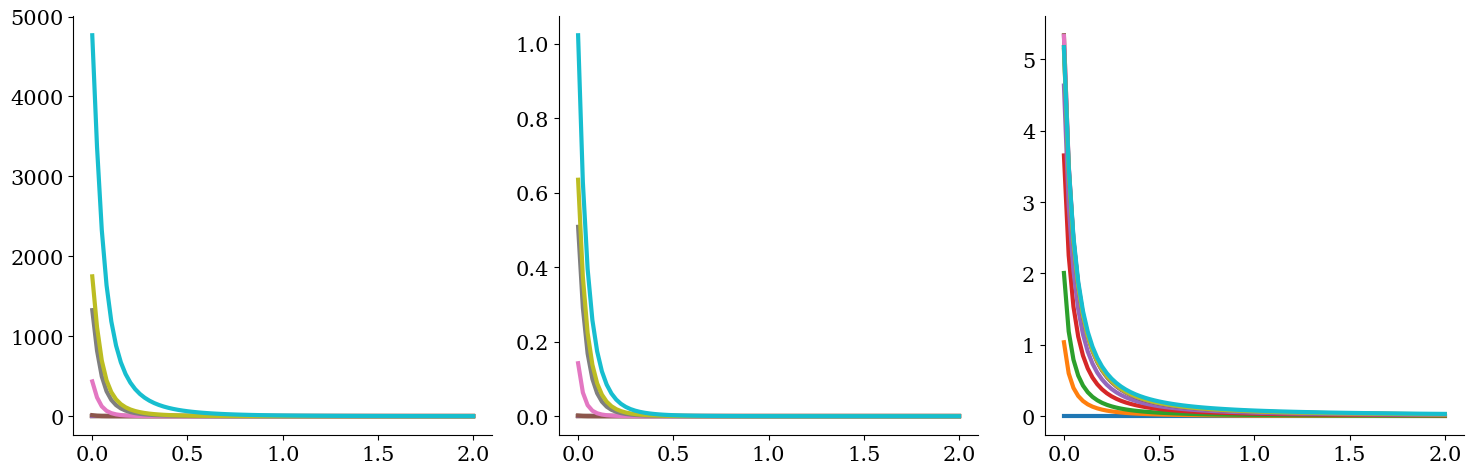

In [865]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ADP_range, min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, num_ph=6, conc_type='ilo')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ilo', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ADP_range)

plt.tight_layout()
plt.show()

##С обратными, с ki для прямых, c ki для обратных

In [866]:
# Система дифференциальных уравнений
def system(t, y):
    N_rest, N_sph, N_inh, N_gp, N_aggr, N_dsen, = y
    dN_rest_dt = k21 * N_inh + k11 * N_dsen - k12 * N_rest - k1 * N_rest
    dN_sph_dt = k1 * N_rest - k2 * N_sph - k5 * N_sph
    dN_inh_dt = k12 * N_rest - k21 * N_inh
    dN_gp_dt = k2 * N_sph - k3 * (N_gp ** 2) - k6 * N_gp
    dN_aggr_dt = k3 * (N_gp ** 2) - k7 * N_aggr
    dN_dsen_dt = k5 * N_sph + k6 * N_gp + k7 * N_aggr - k11 * N_dsen

    return [dN_rest_dt, dN_sph_dt, dN_inh_dt, dN_gp_dt, dN_aggr_dt, dN_dsen_dt]

In [867]:
ki_list = []

# Решение системы дифф. уравнений
def calculate_concetrations(points, max_time, y0):

    y0 = y0

    for i in range(len(points)):

        ADP = points[i][1]
        ilo = points[i][2]

        global ki_1, ki_3, k1, k12, k21, km_2, ki_2, k2, k5, km_3, ki_3, k3, k6, k7 # при добавлении новых реакций, все константы должны быть перечислены здесь

        # нахождение констант (по формулам выше)

        ki_1 = calculate_k_inh(IC50_k1_ilo, h_k1_ilo, ADP, EC50_k1)
        k1 = calculate_k_with_inh(k1_max, ADP, h_k1, EC50_k1, ilo, ki_1)

        ki_2 = calculate_k_inh(IC50_k2_ilo, h_k2_ilo, ADP, EC50_k2)
        k2 = calculate_k_with_inh(k2_max, ADP, h_k2, EC50_k2, ilo, ki_2)

        k3 = calculate_k_simple(k3_max, ADP, h_k3, EC50_k3)

        k12 = calculate_k_simple(k12_max, ilo, h_k12, EC50_k12)
        k21 = calculate_k_simple(k21_max, ADP, h_k21, EC50_k21)

        ki_5 = calculate_k_inh(IC50_k5_ADP, h_k5_ADP, ilo, EC50_k5_ilo)
        k5 = calculate_k_with_inh(k5_max, ilo, h_k5_ilo, EC50_k5_ilo, ADP, ki_5) + calculete_reverse(k5_max, IC50_k5, h_k5, ADP)

        ki_6 = calculate_k_inh(IC50_k6_ADP, h_k6_ADP, ilo, EC50_k6_ilo)
        k6 = calculate_k_with_inh(k6_max, ilo, h_k6_ilo, EC50_k6_ilo, ADP, ki_6) + calculete_reverse(k6_max, IC50_k6, h_k6, ADP)

        ki_7 = calculate_k_inh(IC50_k5_ADP, h_k5_ADP, ilo, EC50_k5_ilo)
        k7 = calculate_k_with_inh(k7_max, ilo, h_k7_ilo, EC50_k7_ilo, ADP, ki_7) + calculete_reverse(k7_max, IC50_k7, h_k7, ADP)

        #print(ki_1)
        #print(ki_2)

        # Начальные условия

        start = points[i][0]

        if i < len(points) - 1:
            end = points[i + 1][0]
        else:
            end = max_time
        step = end - start + 1

        # Временной интервал
        t_span = (start, end)
        t_eval = np.linspace(*t_span, step)

        sol = solve_ivp(system, t_span, y0, t_eval=t_eval, method='BDF', events=event_negative)

        df = pd.DataFrame(sol.y.T, columns=['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen'])
        df['Time'] = sol.t

        # Сумма
        df['Summ'] = df[['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen']].sum(axis=1)

        # Перестановка столбцов для удобства
        df = df[['Time', 'Summ', 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen']]

        if i > 0:
            results = pd.concat([results, df.iloc[1:]], axis=0)
        else:
            results = df

        y0 = sol.y.T[-1]

    return results

In [868]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0]
]

In [869]:
plt.rcParams['font.size'] = 25
plt.rcParams['lines.linewidth'] = 3

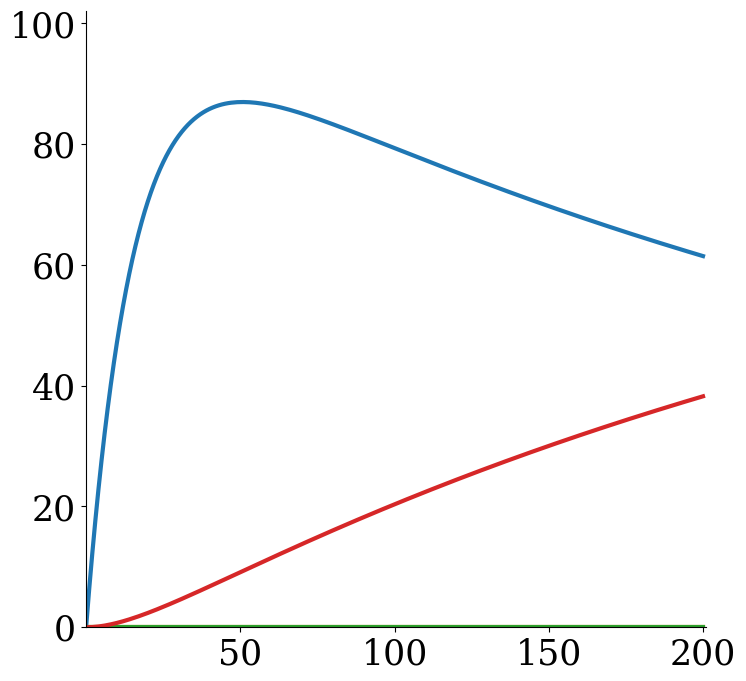

In [870]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [871]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0]
]

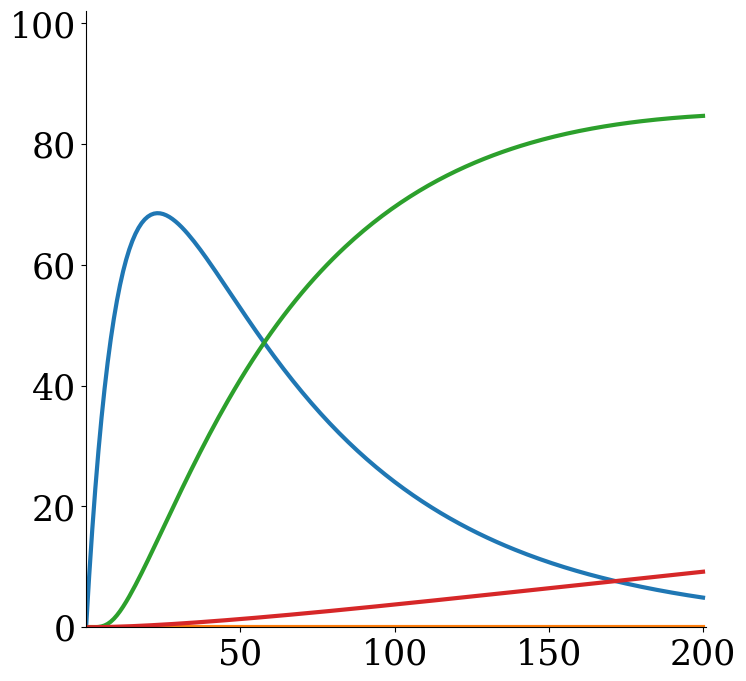

In [872]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [873]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.05]
]

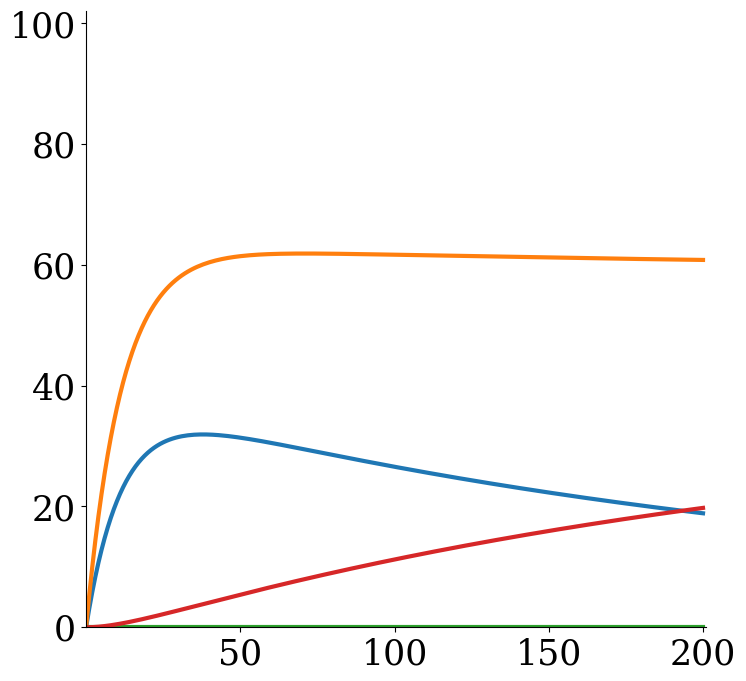

In [874]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [875]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.5]
]

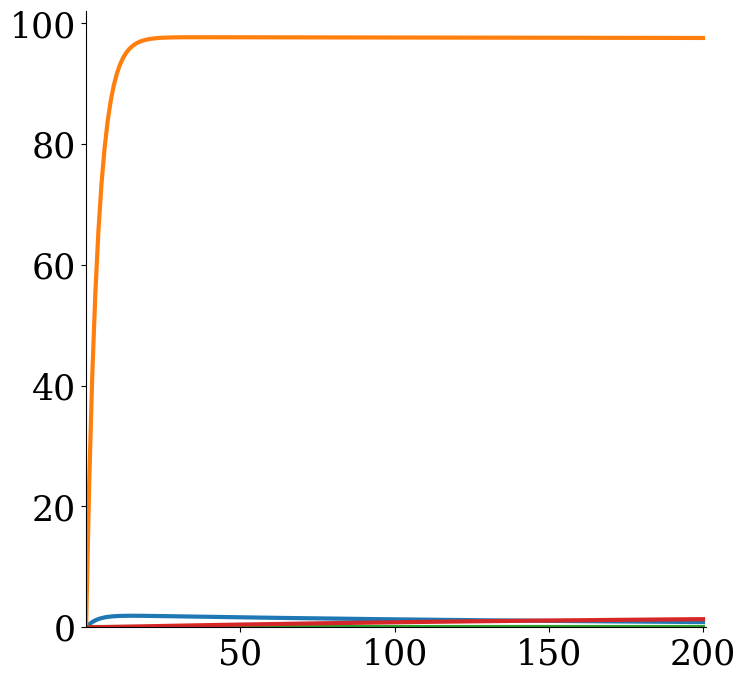

In [876]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [877]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.05]
]

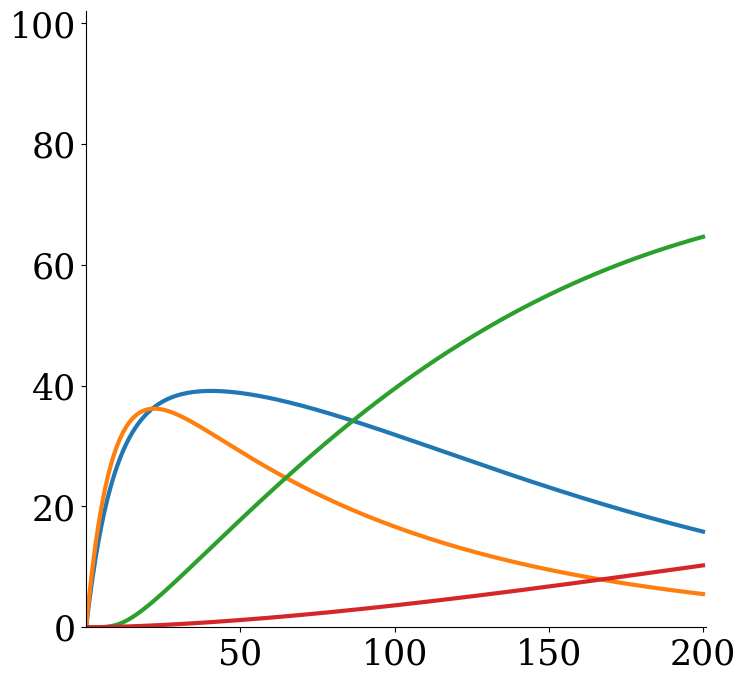

In [878]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [879]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.5]
]

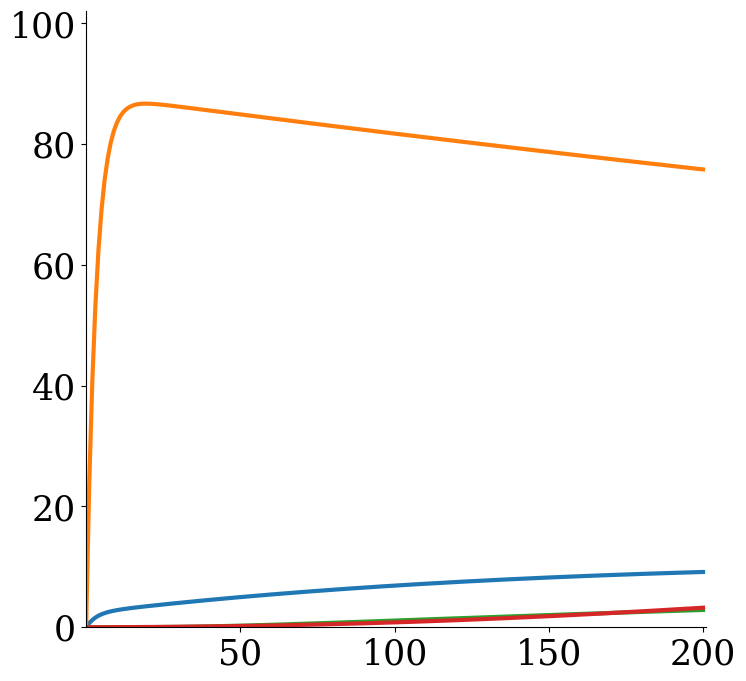

In [880]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [881]:
# Расчет данных AUC и Umax для диапазона ADP
data_raw = auc(min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, ilo_ADP, 20, 5, num_ph=6, conc_type='ADP')
data_ADP = data_raw[0]
relative_responce(data=data_ADP, conc_type='ADP', min_max=max_ADP, phenotypes_list=['auc_a2b3', 'u_a2b3'])

# Загрузка экспериментальных данных
file_path = '/content/ADP_grad.xlsx'
data_ex_ADP = pd.read_excel(file_path)
file_path = '/content/ADP_grad_calculated_range.xlsx'
data_ex_ADP_range = pd.read_excel(file_path)

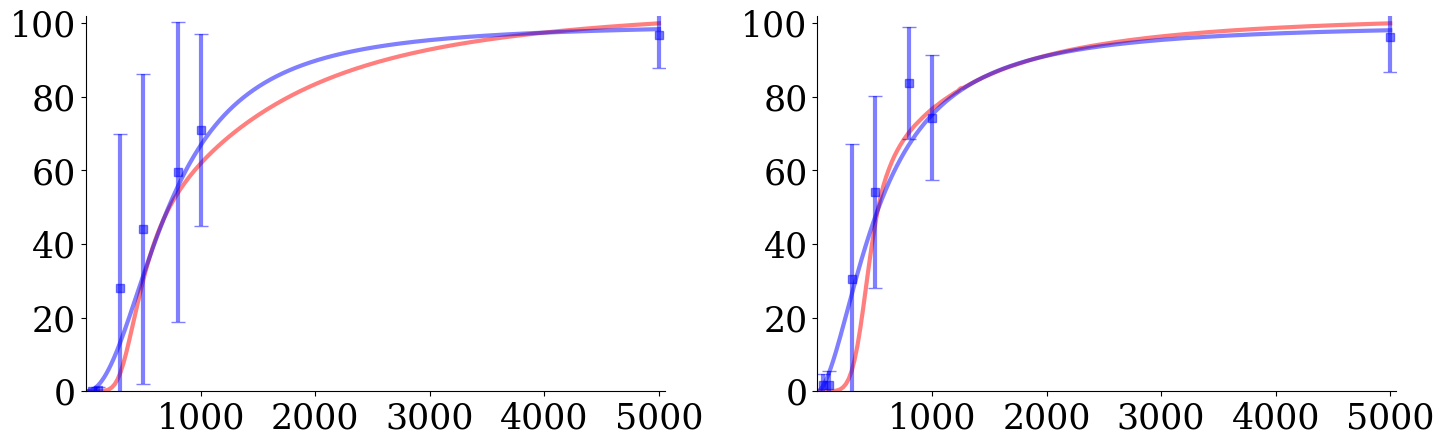

In [882]:
# Пример использования
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ADP, data_ex_ADP, data_ex_ADP_range, axs, 'ADP', phenotypes_list=['auc_a2b3', 'u_a2b3'], legend_pos='lower right')

plt.tight_layout()
plt.show()

In [883]:
# Нахождение AUC и Umax
data_raw = auc(min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, ADP_ilo, 20, 5, num_ph=6, conc_type='ilo')
data_ilo = data_raw[0]
relative_responce(data=data_ilo, conc_type='ilo', min_max=min_ilo, phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

file_path = '/content/1000_ADP_ilo_grad.xlsx'
data_ex_ilo = pd.read_excel(file_path)
file_path = '/content/Ilo_grad_calculated_range.xlsx'
data_ex_Ilo_range = pd.read_excel(file_path)

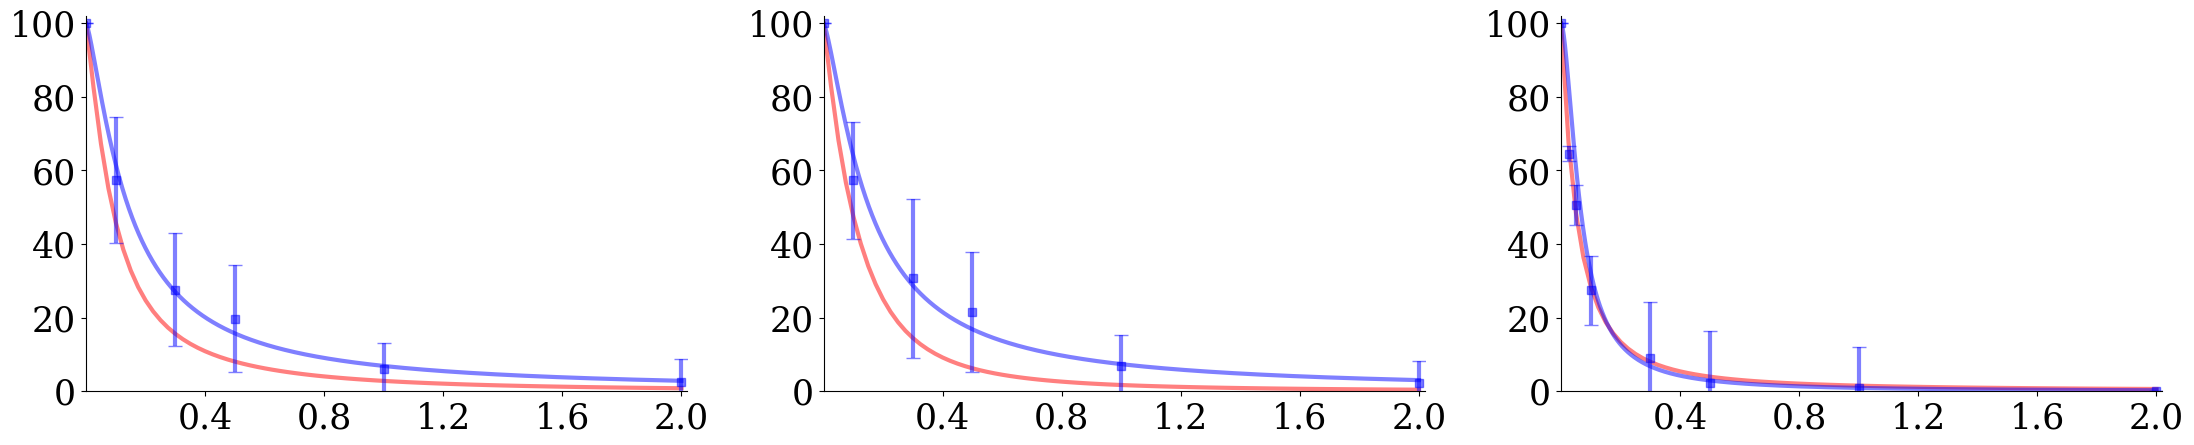

In [884]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=((15 * 1.5), 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ilo, data_ex_ilo, data_ex_Ilo_range, axs, 'ilo', phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

plt.tight_layout()
plt.show()

In [885]:
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 3

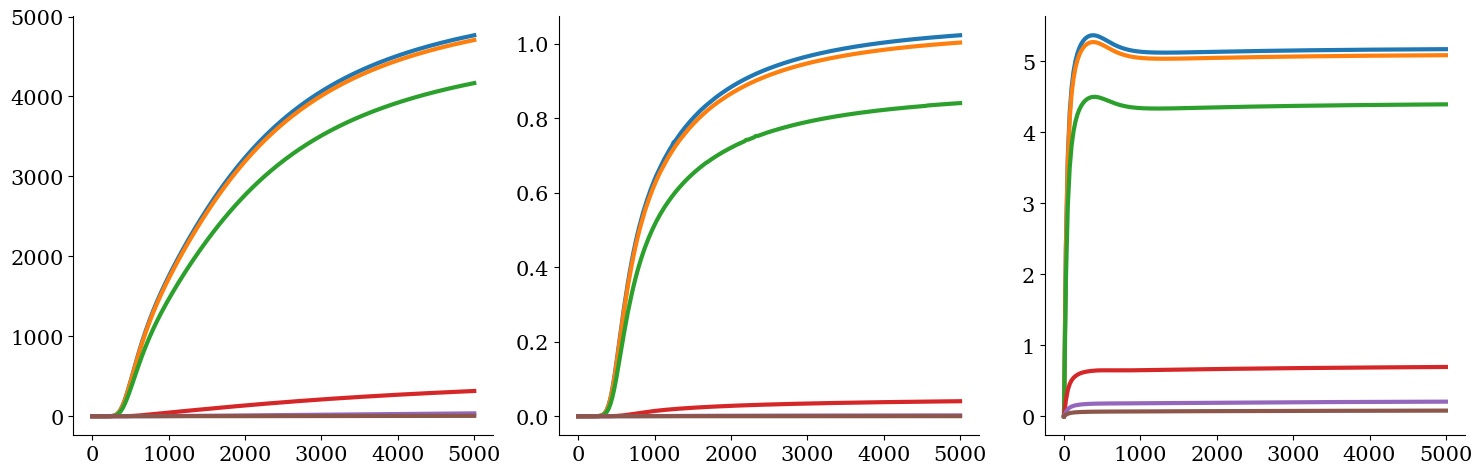

In [886]:

# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ilo_range, min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, num_ph=6, conc_type='ADP')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ADP', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ilo_range)

plt.tight_layout()
plt.show()


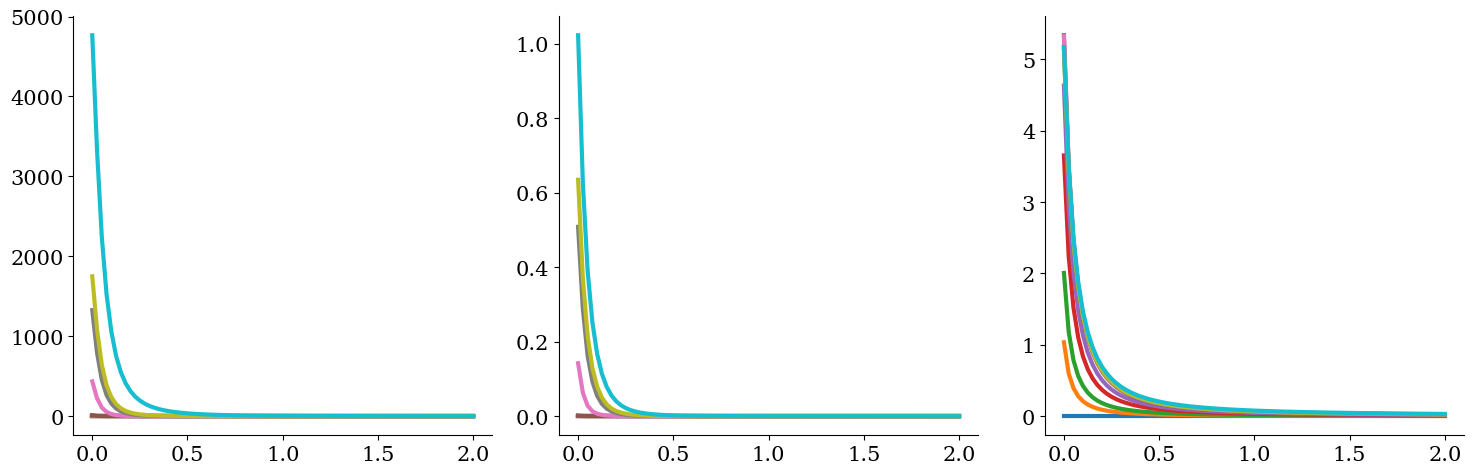

In [887]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ADP_range, min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, num_ph=6, conc_type='ilo')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ilo', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ADP_range)

plt.tight_layout()
plt.show()

# Competitive

## Basic formulas for calculating constants

In [888]:
# Обзие формулы для нахождения констант

def calculate_k_inh(IC50_ilo, h_ilo, ADP, EC50):
    return (IC50_ilo ** h_ilo) / (((ADP / EC50) ** h_ilo) + 1) # констранта ингибирования (ki)

def calculate_k_with_inh(k_max, ADP, h_k, EC50, ilo, ki):
    return k_max * (ADP ** h_k) / (ADP ** h_k + ((EC50 ** h_k) * ((1 + (ilo / ki))))) # k с учетом ki

def calculate_k_simple(k_max, concentration, h_k, EC50):
    return k_max * (concentration ** h_k) / (concentration ** h_k + EC50 ** h_k) # k без учета ki (concentration - ADP или Ilo)

def calculete_reverse(k_max, IC50, h_k, ADP):
    return k_max * (IC50 ** h_k) / (IC50 ** h_k + ADP ** h_k) # k из IC50

## **Без обратных, без ki для прямых, без ki для обратных**

In [889]:
# Система дифференциальных уравнений
def system(t, y):
    N_rest, N_sph, N_inh, N_gp, N_aggr = y
    dN_rest_dt = k21 * N_inh - k12 * N_rest - k1 * N_rest
    dN_sph_dt = k1 * N_rest - k2 * N_sph
    dN_inh_dt = k12 * N_rest - k21 * N_inh
    dN_gp_dt = k2 * N_sph - k3 * (N_gp ** 2)
    dN_aggr_dt = k3 * (N_gp ** 2)

    return [dN_rest_dt, dN_sph_dt, dN_inh_dt, dN_gp_dt, dN_aggr_dt]

In [890]:
# Решение системы дифф. уравнений
def calculate_concetrations(points, max_time, y0):

    y0 = y0

    for i in range(len(points)):

        ADP = points[i][1]
        ilo = points[i][2]

        global ki_1, ki_3, k1, k12, k21, km_2, ki_2, k2, km_3, ki_3, k3

        k1 = calculate_k_simple(k1_max, ADP, h_k1, EC50_k1)

        k2 = calculate_k_simple(k2_max, ADP, h_k2, EC50_k2)

        k3 = calculate_k_simple(k3_max, ADP, h_k3, EC50_k3)

        k12 = calculate_k_simple(k12_max, ilo, h_k12, EC50_k12)
        k21 = calculate_k_simple(k21_max, ADP, h_k21, EC50_k21)


        # Начальные условия

        start = points[i][0]

        if i < len(points) - 1:
            end = points[i + 1][0]
        else:
            end = max_time
        step = end - start + 1

        # Временной интервал
        t_span = (start, end)
        t_eval = np.linspace(*t_span, step)

        sol = solve_ivp(system, t_span, y0, t_eval=t_eval, method='BDF', events=event_negative)

        df = pd.DataFrame(sol.y.T, columns=['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr'])
        df['Time'] = sol.t

        # Сумма
        df['Summ'] = df[['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr']].sum(axis=1)

        # Перестановка столбцов для удобства
        df = df[['Time', 'Summ', 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr']]

        if i > 0:
            results = pd.concat([results, df.iloc[1:]], axis=0)
        else:
            results = df

        y0 = sol.y.T[-1]


    return results


In [891]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0]
]

In [892]:
plt.rcParams['font.size'] = 25
plt.rcParams['lines.linewidth'] = 3

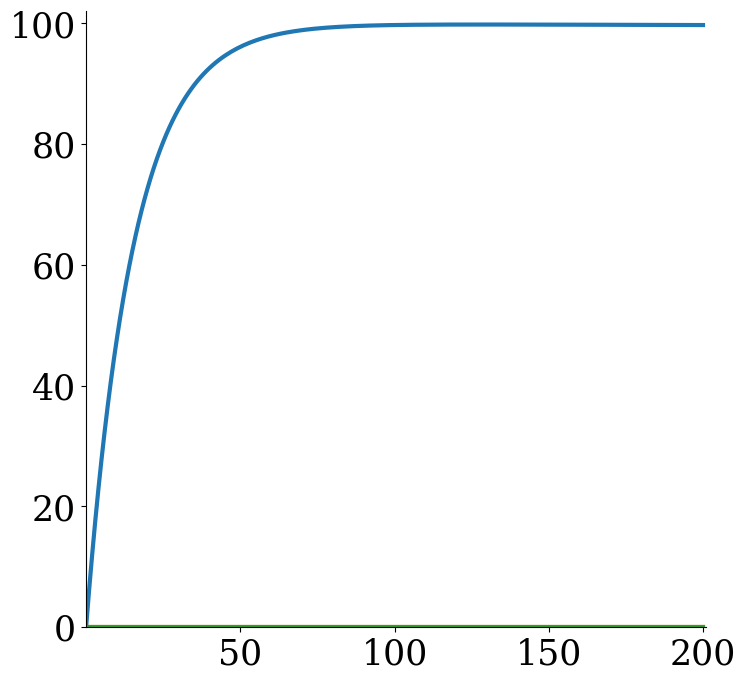

In [893]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [894]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0]
]

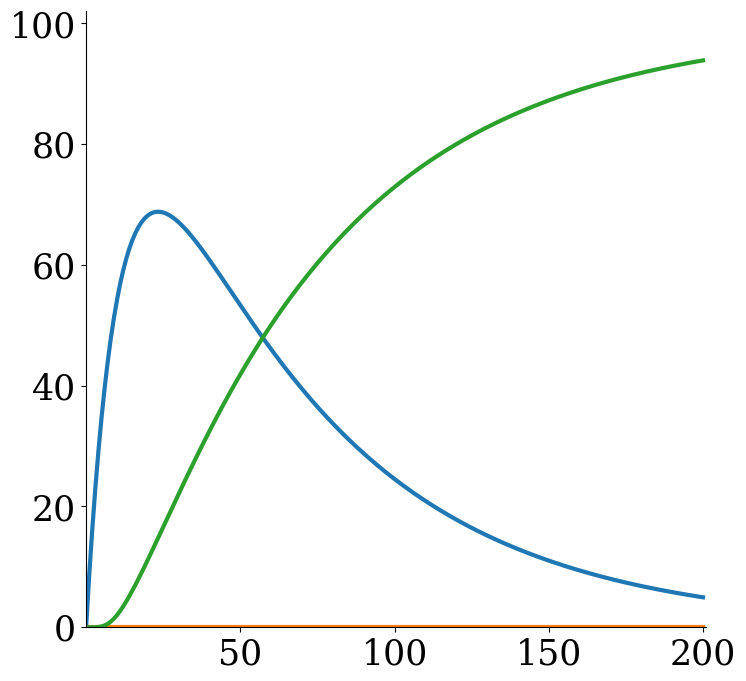

In [895]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [896]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.05]
]

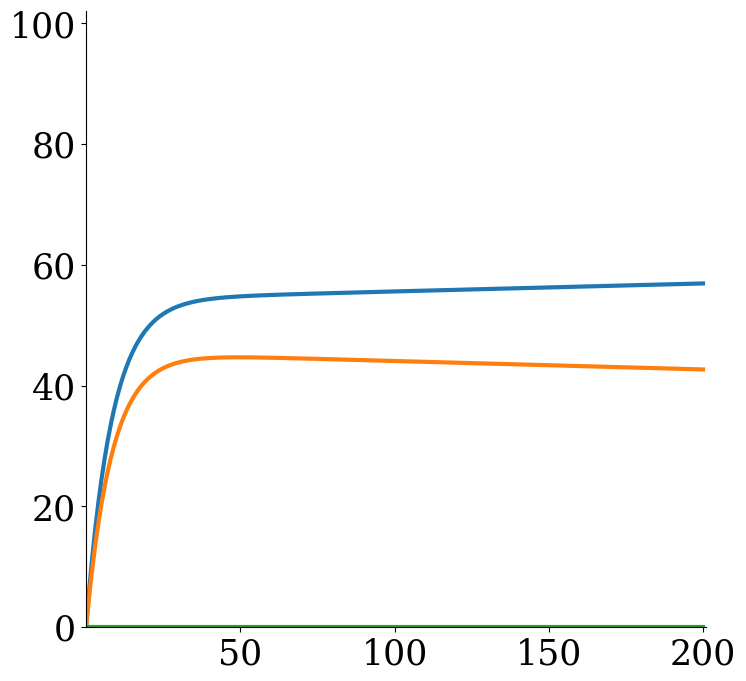

In [897]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [898]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.5]
]

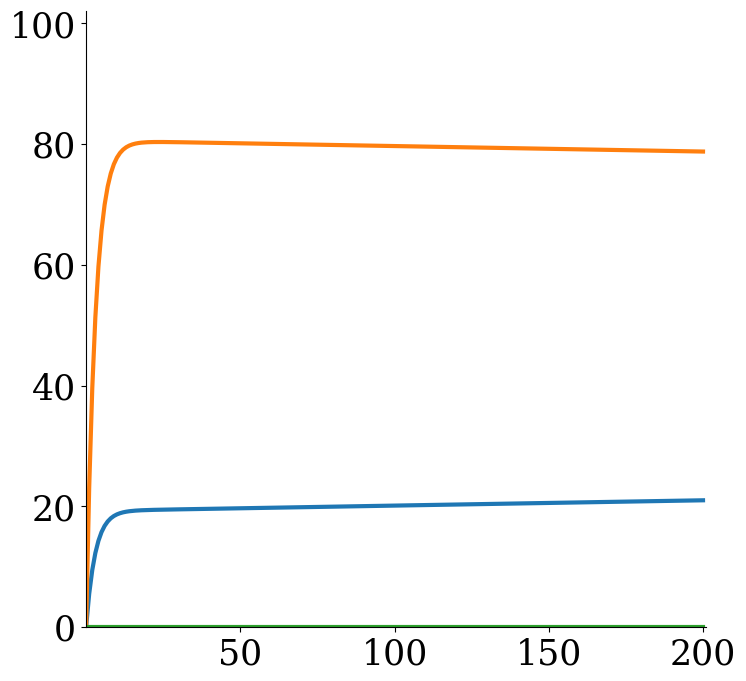

In [899]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [900]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.05]
]

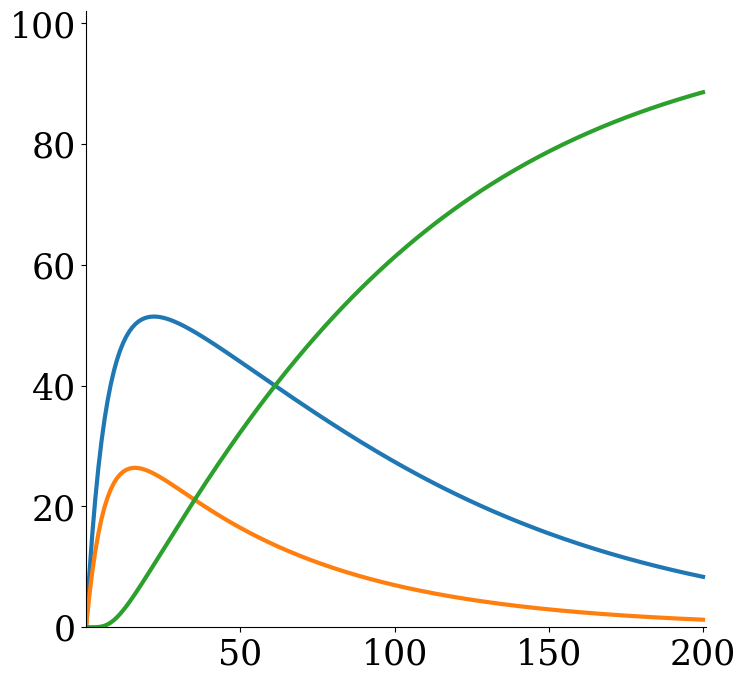

In [901]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [902]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.5]
]

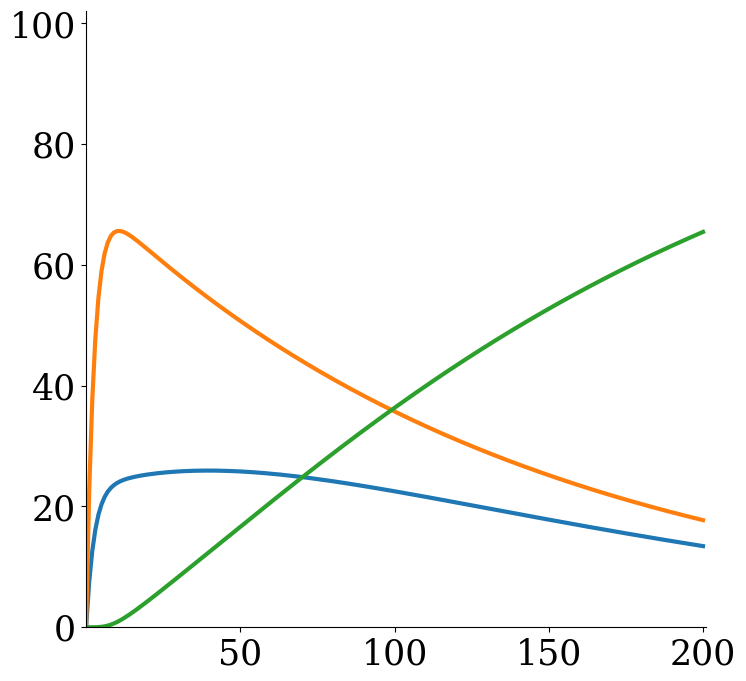

In [903]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [904]:
# Расчет данных AUC и Umax для диапазона ADP
data_raw = auc(min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, ilo_ADP, 20, 5, num_ph=5, conc_type='ADP')
data_ADP = data_raw[0]
relative_responce(data=data_ADP, conc_type='ADP', min_max=max_ADP, phenotypes_list=['auc_a2b3', 'u_a2b3'])

# Загрузка экспериментальных данных
file_path = '/content/ADP_grad.xlsx'
data_ex_ADP = pd.read_excel(file_path)
file_path = '/content/ADP_grad_calculated_range.xlsx'
data_ex_ADP_range = pd.read_excel(file_path)

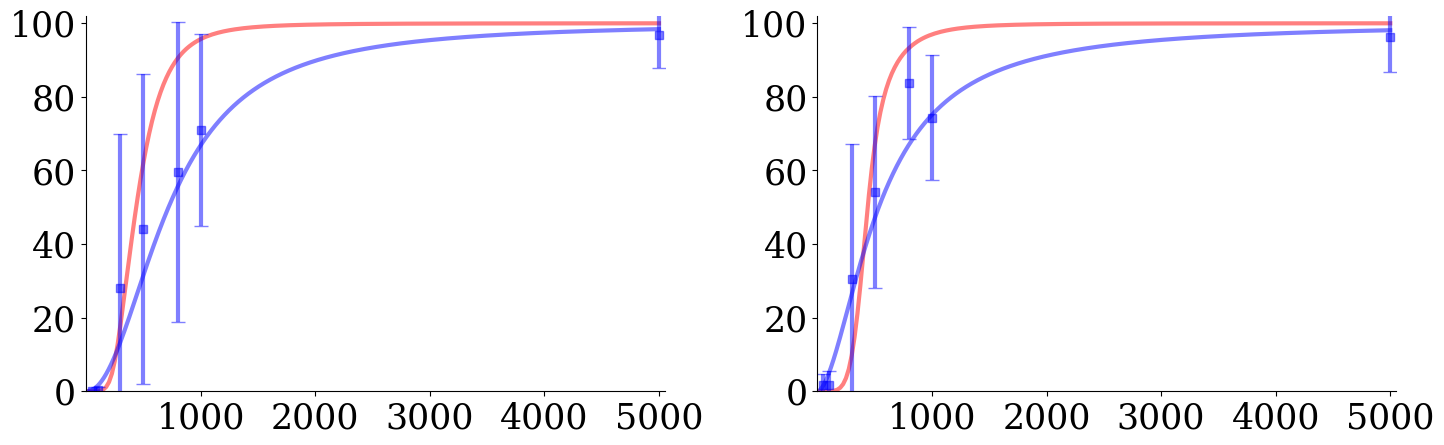

In [905]:
# Пример использования
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ADP, data_ex_ADP, data_ex_ADP_range, axs, 'ADP', phenotypes_list=['auc_a2b3', 'u_a2b3'], legend_pos='lower right')

plt.tight_layout()
plt.show()

In [906]:
# Нахождение AUC и Umax
data_raw = auc(min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, ADP_ilo, 20, 5, num_ph=5, conc_type='ilo')
data_ilo = data_raw[0]
relative_responce(data=data_ilo, conc_type='ilo', min_max=min_ilo, phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

file_path = '/content/1000_ADP_ilo_grad.xlsx'
data_ex_ilo = pd.read_excel(file_path)
file_path = '/content/Ilo_grad_calculated_range.xlsx'
data_ex_Ilo_range = pd.read_excel(file_path)

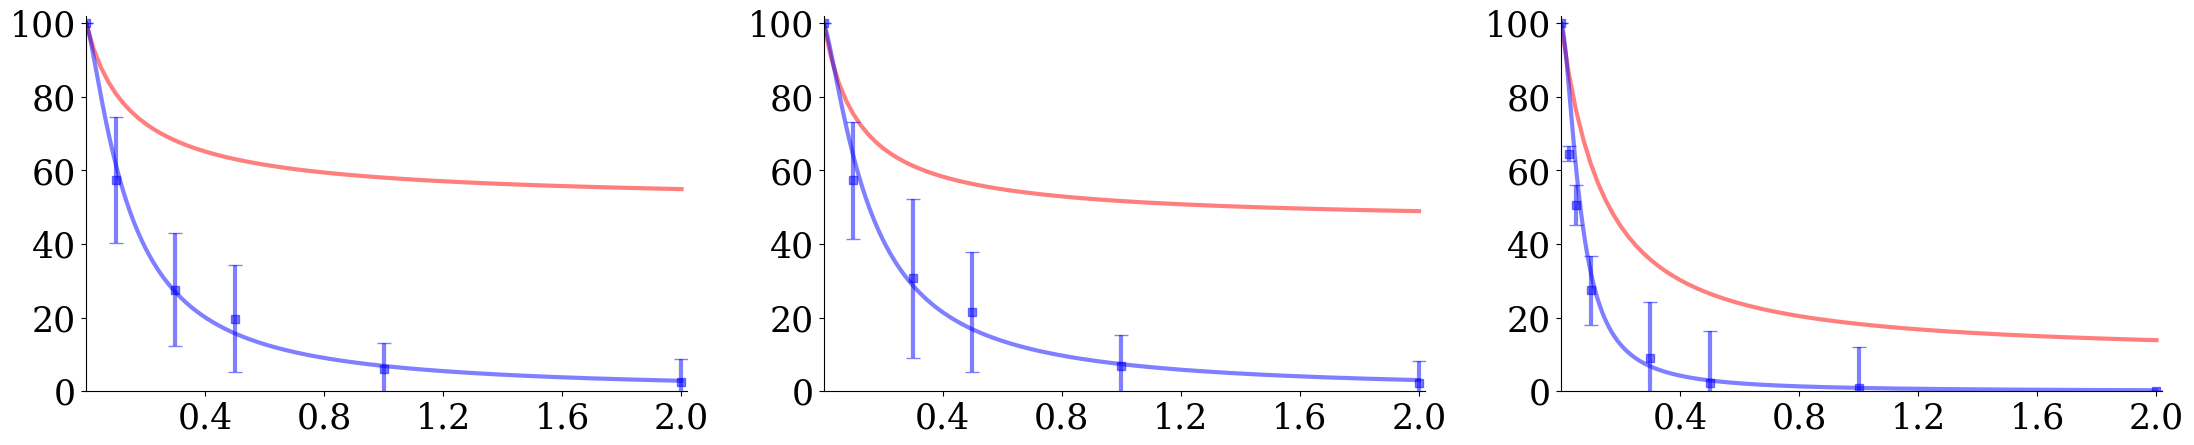

In [907]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=((15 * 1.5), 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ilo, data_ex_ilo, data_ex_Ilo_range, axs, 'ilo', phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

plt.tight_layout()
plt.show()

In [908]:
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 3

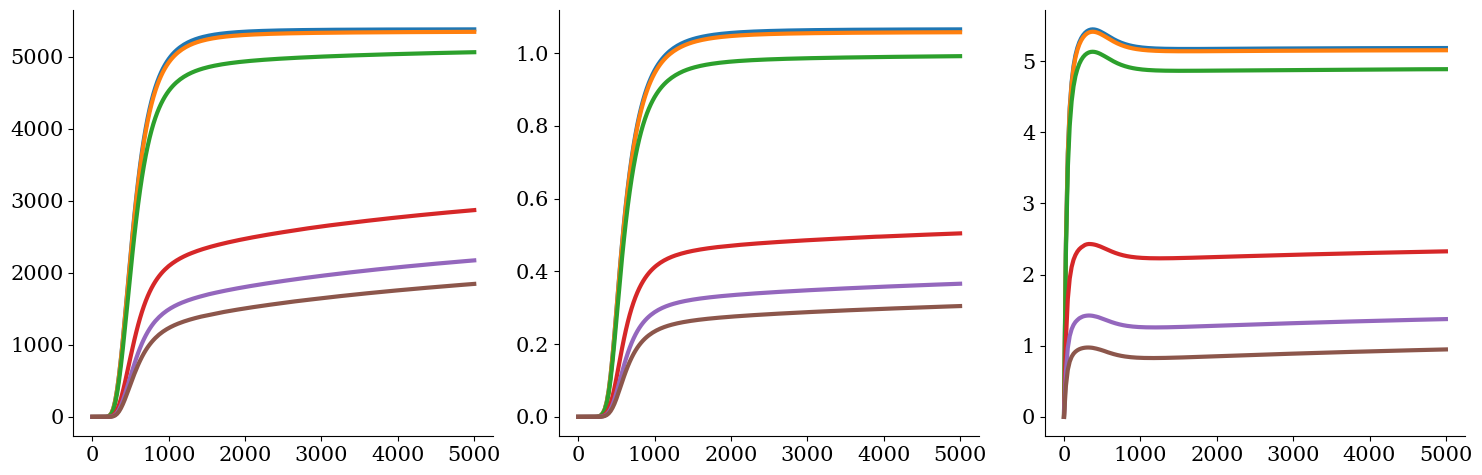

In [909]:

# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ilo_range, min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, num_ph=5, conc_type='ADP')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ADP', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ilo_range)

plt.tight_layout()
plt.show()


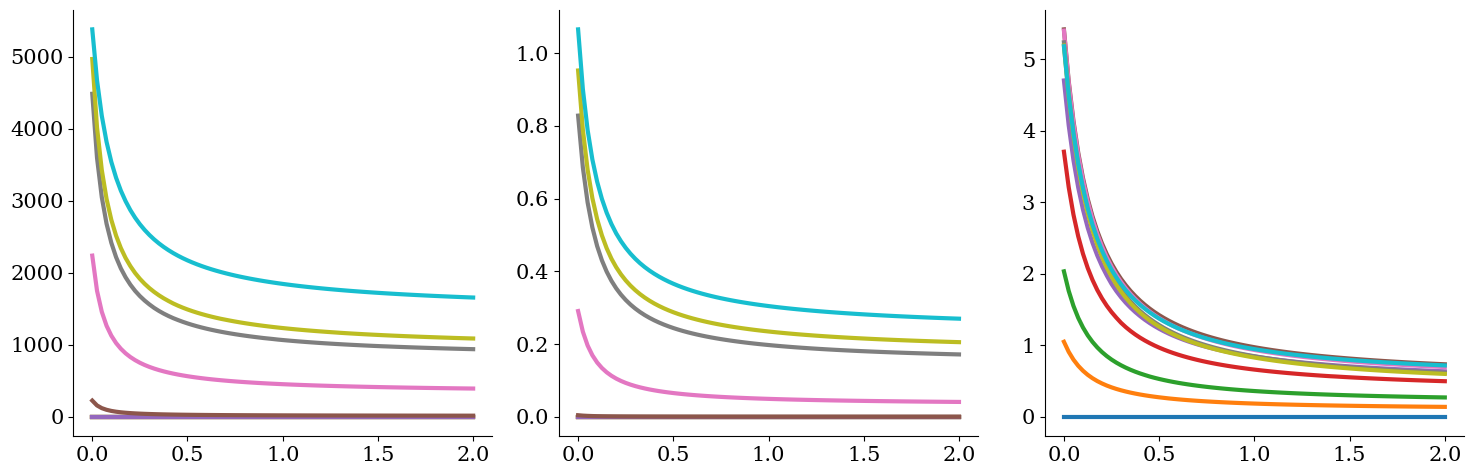

In [910]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ADP_range, min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, num_ph=5, conc_type='ilo')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ilo', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ADP_range)

plt.tight_layout()
plt.show()

##С обратными, без ki для прямых, без ki для обратных

In [911]:
# Система дифференциальных уравнений
def system(t, y):
    N_rest, N_sph, N_inh, N_gp, N_aggr, N_dsen = y
    dN_rest_dt = k21 * N_inh + k11 * N_dsen - k12 * N_rest - k1 * N_rest
    dN_sph_dt = k1 * N_rest - k2 * N_sph - k5 * N_sph
    dN_inh_dt = k12 * N_rest - k21 * N_inh
    dN_gp_dt = k2 * N_sph - k3 * (N_gp ** 2) - k6 * N_gp
    dN_aggr_dt = k3 * (N_gp ** 2) - k7 * N_aggr
    dN_dsen_dt = k5 * N_sph + k6 * N_gp + k7 * N_aggr - k11 * N_dsen

    return [dN_rest_dt, dN_sph_dt, dN_inh_dt, dN_gp_dt, dN_aggr_dt, dN_dsen_dt]

In [912]:
# Решение системы дифф. уравнений
def calculate_concetrations(points, max_time, y0):

    y0 = y0

    for i in range(len(points)):

        ADP = points[i][1]
        ilo = points[i][2]

        global ki_1, ki_3, k1, k12, k21, km_2, ki_2, k2, k5, km_3, ki_3, k3, k6, k7

        k1 = calculate_k_simple(k1_max, ADP, h_k1, EC50_k1)

        k2 = calculate_k_simple(k2_max, ADP, h_k2, EC50_k2)

        k3 = calculate_k_simple(k3_max, ADP, h_k3, EC50_k3)

        k12 = calculate_k_simple(k12_max, ilo, h_k12, EC50_k12)
        k21 = calculate_k_simple(k21_max, ADP, h_k21, EC50_k21)

        k5 = calculete_reverse(k5_max, IC50_k5, h_k5, ADP)
        k6 = calculete_reverse(k6_max, IC50_k6, h_k6, ADP)
        k7 = calculete_reverse(k7_max, IC50_k7, h_k7, ADP)


        # Начальные условия

        start = points[i][0]

        if i < len(points) - 1:
            end = points[i + 1][0]
        else:
            end = max_time
        step = end - start + 1

        # Временной интервал
        t_span = (start, end)
        t_eval = np.linspace(*t_span, step)

        sol = solve_ivp(system, t_span, y0, t_eval=t_eval, method='BDF', events=event_negative)

        df = pd.DataFrame(sol.y.T, columns=['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen'])
        df['Time'] = sol.t

        # Сумма
        df['Summ'] = df[['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen']].sum(axis=1)

        # Перестановка столбцов для удобства
        df = df[['Time', 'Summ', 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen']]

        if i > 0:
            results = pd.concat([results, df.iloc[1:]], axis=0)
        else:
            results = df

        y0 = sol.y.T[-1]

    return results

In [913]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0]
]

In [914]:
plt.rcParams['font.size'] = 25
plt.rcParams['lines.linewidth'] = 3

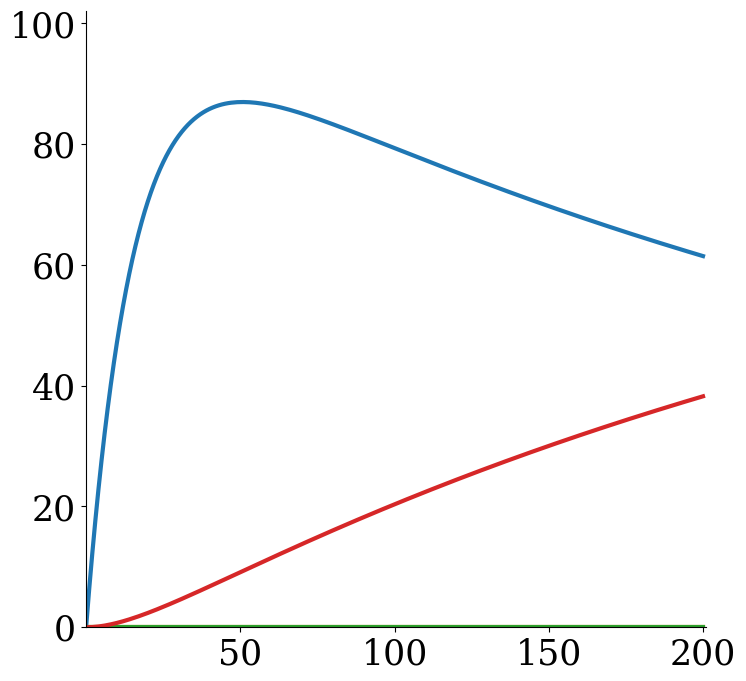

In [915]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [916]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0]
]

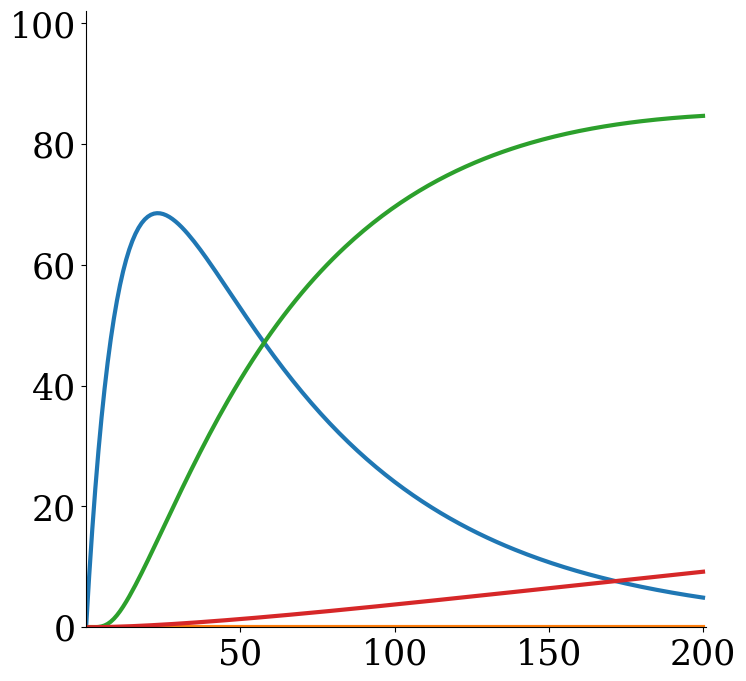

In [917]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [918]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.05]
]

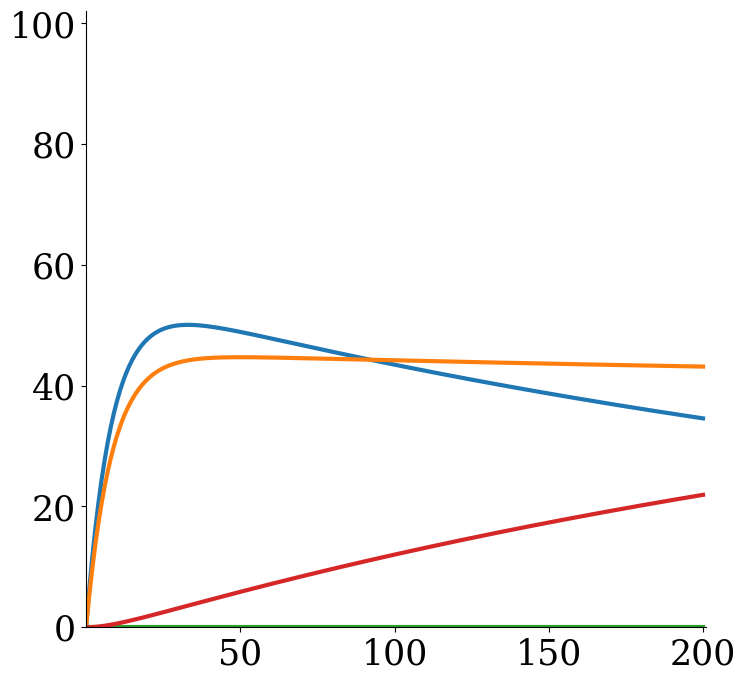

In [919]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [920]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.5]
]

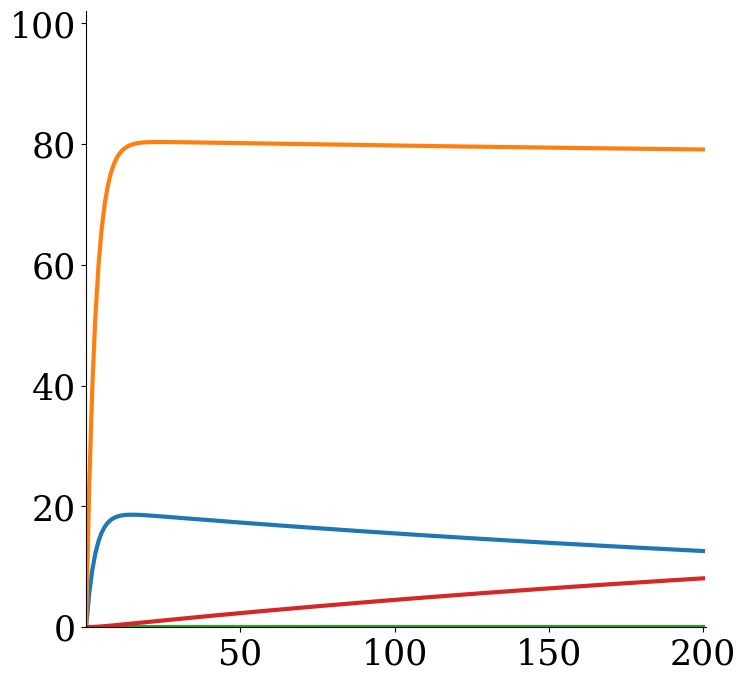

In [921]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [922]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.05]
]

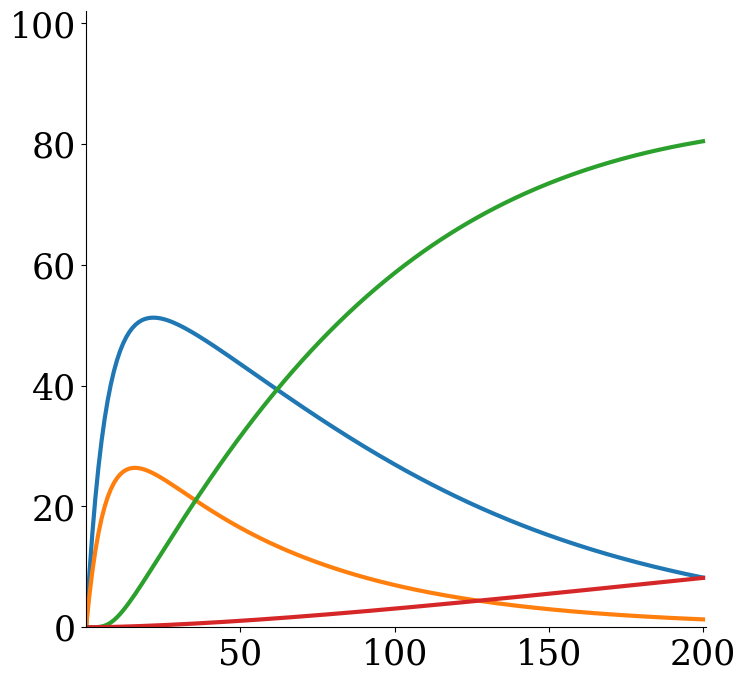

In [923]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [924]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.5]
]

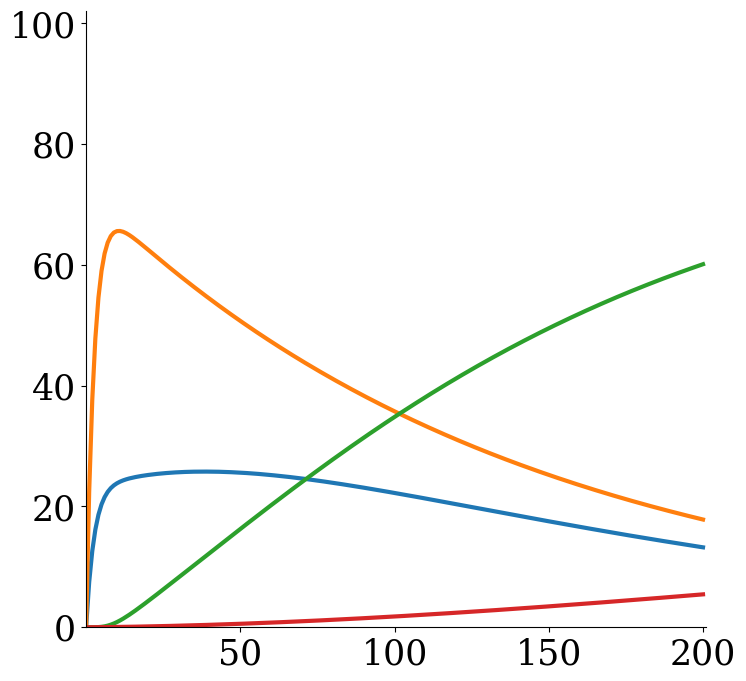

In [925]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [926]:
# Расчет данных AUC и Umax для диапазона ADP
data_raw = auc(min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, ilo_ADP, 20, 5, num_ph=6, conc_type='ADP')
data_ADP = data_raw[0]
relative_responce(data=data_ADP, conc_type='ADP', min_max=max_ADP, phenotypes_list=['auc_a2b3', 'u_a2b3'])

# Загрузка экспериментальных данных
file_path = '/content/ADP_grad.xlsx'
data_ex_ADP = pd.read_excel(file_path)
file_path = '/content/ADP_grad_calculated_range.xlsx'
data_ex_ADP_range = pd.read_excel(file_path)

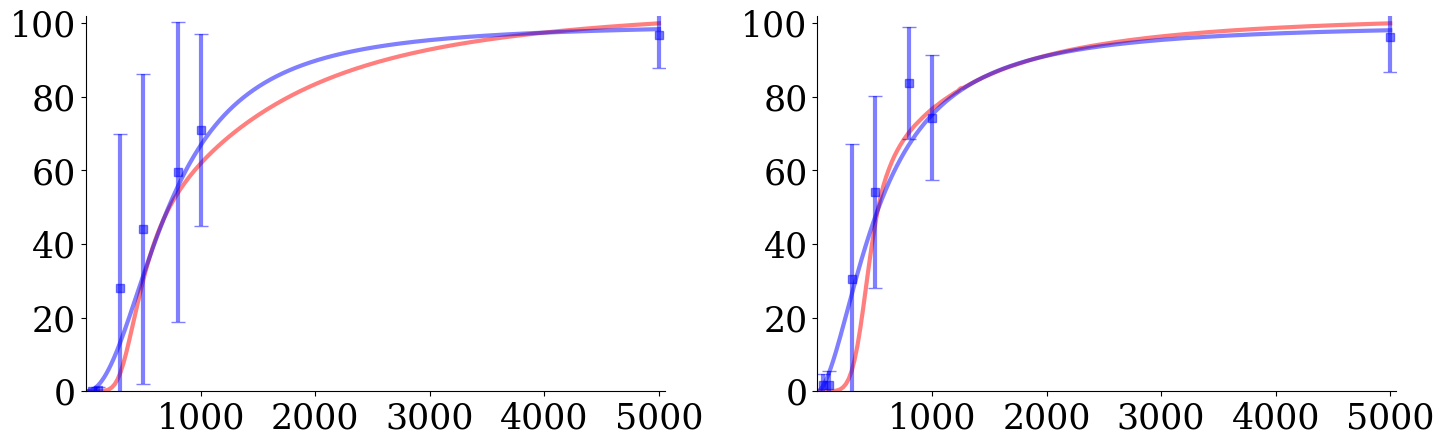

In [927]:
# Пример использования
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ADP, data_ex_ADP, data_ex_ADP_range, axs, 'ADP', phenotypes_list=['auc_a2b3', 'u_a2b3'], legend_pos='lower right')

plt.tight_layout()
plt.show()

In [928]:
# Нахождение AUC и Umax
data_raw = auc(min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, ADP_ilo, 20, 5, num_ph=6, conc_type='ilo')
data_ilo = data_raw[0]
relative_responce(data=data_ilo, conc_type='ilo', min_max=min_ilo, phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

file_path = '/content/1000_ADP_ilo_grad.xlsx'
data_ex_ilo = pd.read_excel(file_path)
file_path = '/content/Ilo_grad_calculated_range.xlsx'
data_ex_Ilo_range = pd.read_excel(file_path)

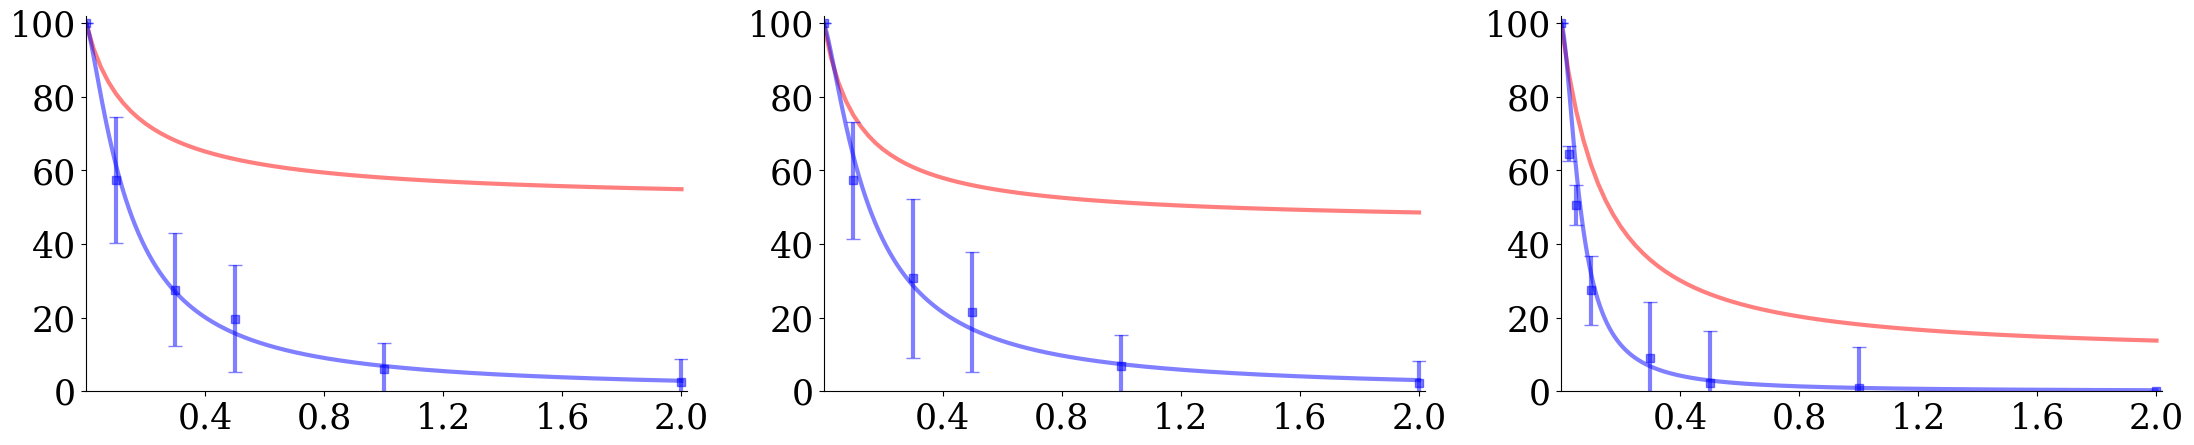

In [929]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=((15 * 1.5), 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ilo, data_ex_ilo, data_ex_Ilo_range, axs, 'ilo', phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

plt.tight_layout()
plt.show()

In [930]:
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 3

<ipython-input-770-77b623931753>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dy_dt'] = np.gradient(values, df['Time'])
<ipython-input-770-77b623931753>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['N_a2b3'] = sqrt_N_aggr
<ipython-input-770-77b623931753>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

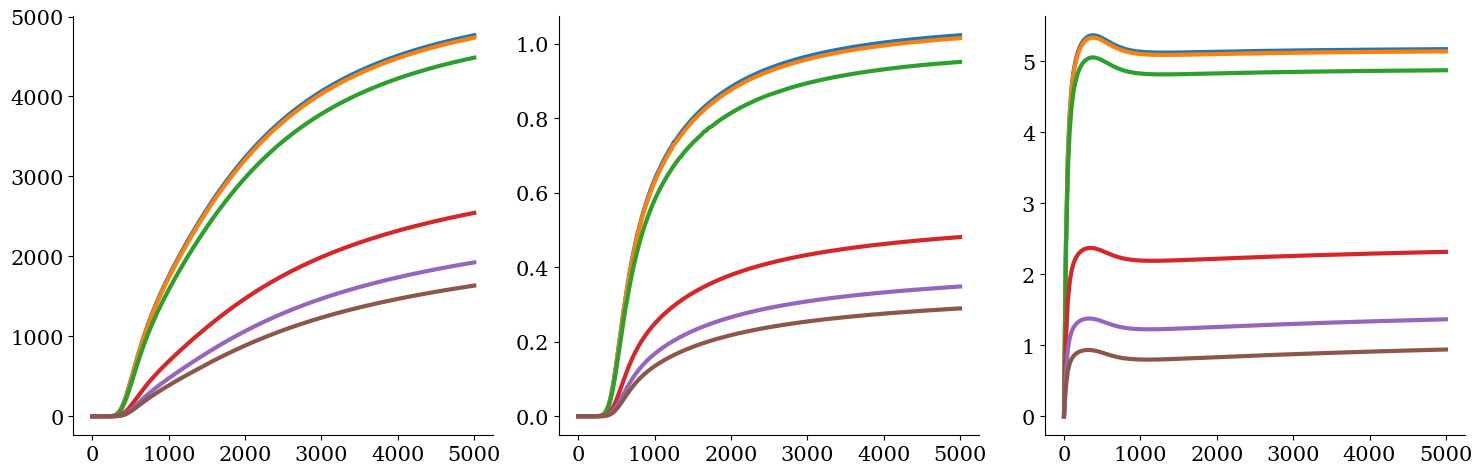

In [931]:

# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ilo_range, min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, num_ph=6, conc_type='ADP')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ADP', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ilo_range)

plt.tight_layout()
plt.show()


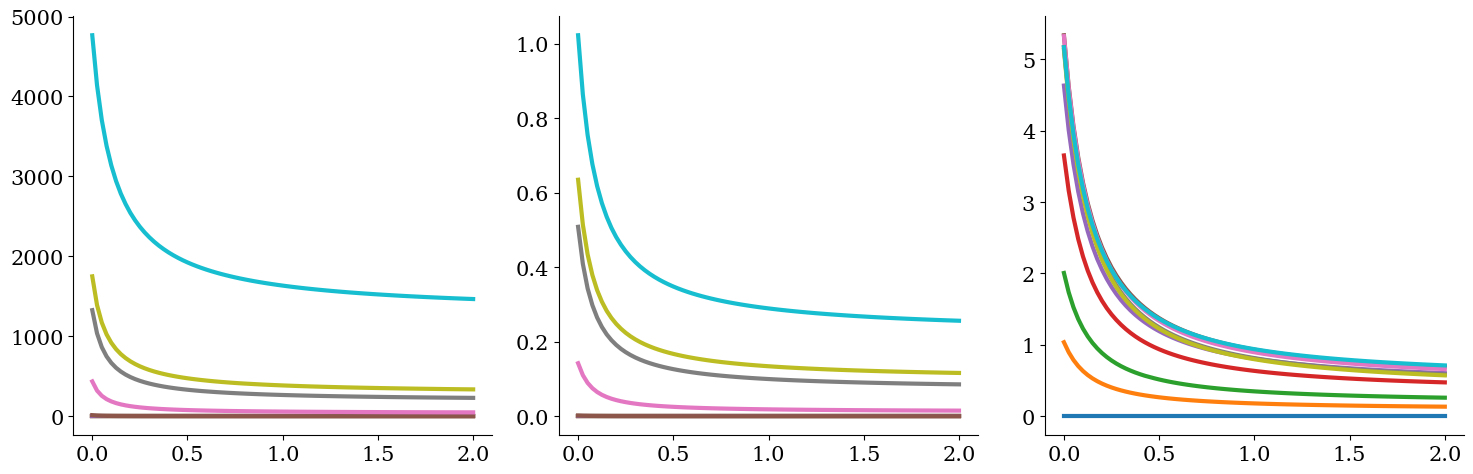

In [932]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ADP_range, min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, num_ph=6, conc_type='ilo')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ilo', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ADP_range)

plt.tight_layout()
plt.show()

## Без обратных, с ki для прямых, без ki для обратных

In [933]:
# Система дифференциальных уравнений
def system(t, y):
    N_rest, N_sph, N_inh, N_gp, N_aggr = y
    dN_rest_dt = k21 * N_inh - k12 * N_rest - k1 * N_rest
    dN_sph_dt = k1 * N_rest - k2 * N_sph
    dN_inh_dt = k12 * N_rest - k21 * N_inh
    dN_gp_dt = k2 * N_sph - k3 * (N_gp ** 2)
    dN_aggr_dt = k3 * (N_gp ** 2)

    return [dN_rest_dt, dN_sph_dt, dN_inh_dt, dN_gp_dt, dN_aggr_dt]

In [934]:
k1_list = []
ki_1_list = []
k2_list = []
ki_2_list = []
k3_list = []
k12_list = []
k21_list = []

# Решение системы дифф. уравнений
def calculate_concetrations(points, max_time, y0):

    y0 = y0

    for i in range(len(points)):

        ADP = points[i][1]
        ilo = points[i][2]

        global ki_1, ki_3, k1, k12, k21, km_2, ki_2, k2, km_3, ki_3, k3

        ki_1 = calculate_k_inh(IC50_k1_ilo, h_k1_ilo, ADP, EC50_k1)
        k1 = calculate_k_with_inh(k1_max, ADP, h_k1, EC50_k1, ilo, ki_1)

        ki_2 = calculate_k_inh(IC50_k2_ilo, h_k2_ilo, ADP, EC50_k2)
        k2 = calculate_k_with_inh(k2_max, ADP, h_k2, EC50_k2, ilo, ki_2)

        ki_3 = calculate_k_inh(IC50_k3_ilo, h_k3_ilo, ADP, EC50_k3)
        k3 = calculate_k_with_inh(k3_max, ADP, h_k3, EC50_k3, ilo, ki_3)

        k12 = calculate_k_simple(k12_max, ilo, h_k12, EC50_k12)
        k21 = calculate_k_simple(k21_max, ADP, h_k21, EC50_k21)

        ki_1_list.append(calculate_k_inh(IC50_k1_ilo, h_k1_ilo, ADP, EC50_k1))
        k1_list.append(calculate_k_with_inh(k1_max, ADP, h_k1, EC50_k1, ilo, ki_1))
        ki_2_list.append(calculate_k_inh(IC50_k2_ilo, h_k2_ilo, ADP, EC50_k2))
        k2_list.append(calculate_k_with_inh(k2_max, ADP, h_k2, EC50_k2, ilo, ki_2))
        k3_list.append(calculate_k_simple(k3_max, ADP, h_k3, EC50_k3))
        k12_list.append(calculate_k_simple(k12_max, ilo, h_k12, EC50_k12))
        k21_list.append(calculate_k_simple(k21_max, ADP, h_k21, EC50_k21))


        # Начальные условия

        start = points[i][0]

        if i < len(points) - 1:
            end = points[i + 1][0]
        else:
            end = max_time
        step = end - start + 1

        # Временной интервал
        t_span = (start, end)
        t_eval = np.linspace(*t_span, step)

        sol = solve_ivp(system, t_span, y0, t_eval=t_eval, method='BDF', events=event_negative)

        df = pd.DataFrame(sol.y.T, columns=['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr'])
        df['Time'] = sol.t

        # Сумма
        df['Summ'] = df[['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr']].sum(axis=1)

        # Перестановка столбцов для удобства
        df = df[['Time', 'Summ', 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr']]

        if i > 0:
            results = pd.concat([results, df.iloc[1:]], axis=0)
        else:
            results = df

        y0 = sol.y.T[-1]

    return results

In [935]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0]
]

In [936]:
plt.rcParams['font.size'] = 25
plt.rcParams['lines.linewidth'] = 3

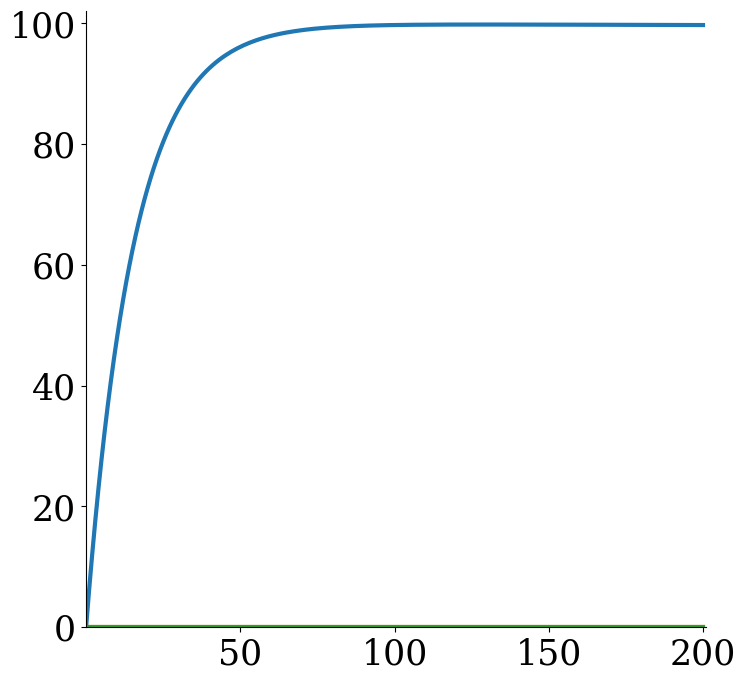

In [937]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [938]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0]
]

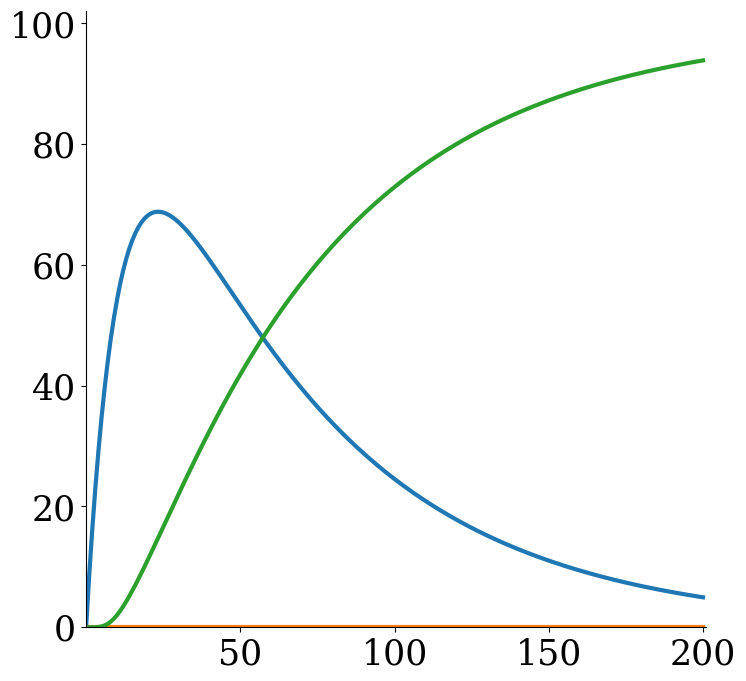

In [939]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [940]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.05]
]

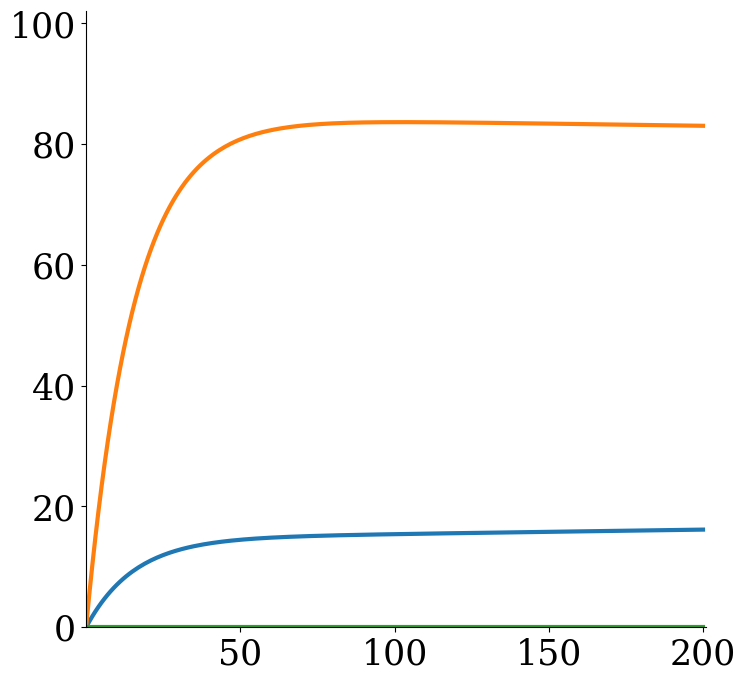

In [941]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [942]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.5]
]

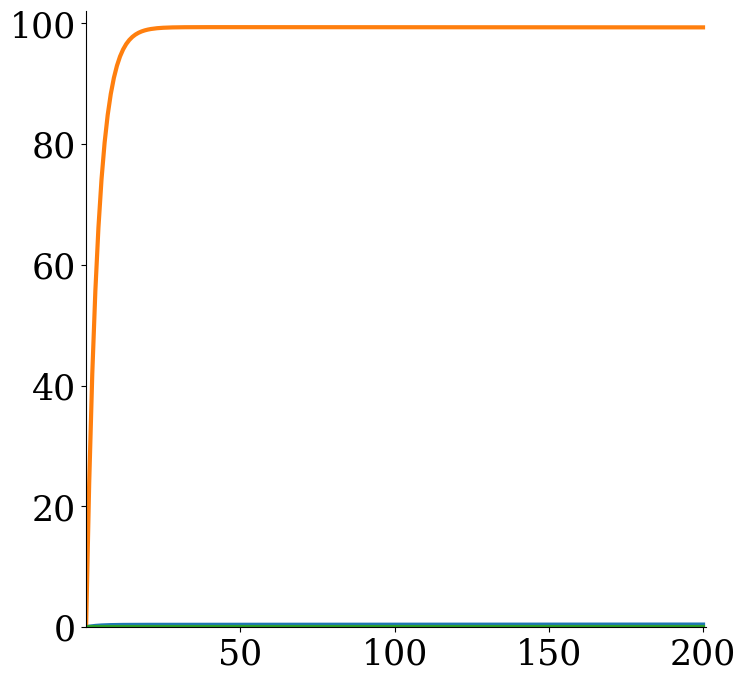

In [943]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [944]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.05]
]

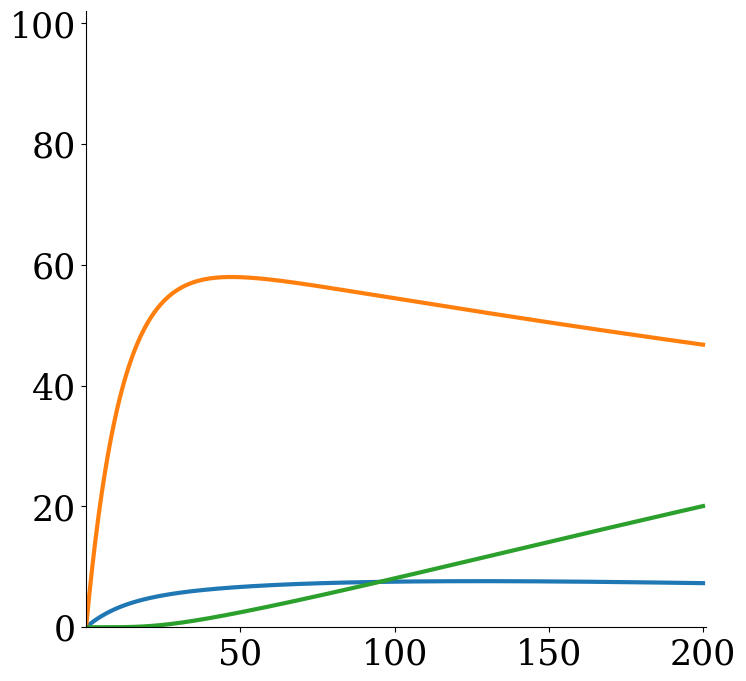

In [945]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [946]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.5]
]

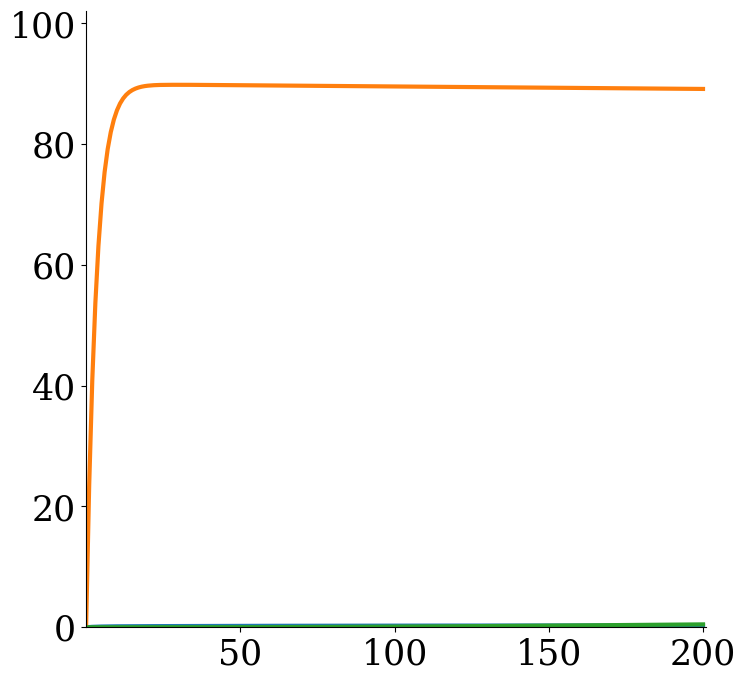

In [947]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [948]:
# Расчет данных AUC и Umax для диапазона ADP
data_raw = auc(min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, ilo_ADP, 20, 5, num_ph=5, conc_type='ADP')
data_ADP = data_raw[0]
relative_responce(data=data_ADP, conc_type='ADP', min_max=max_ADP, phenotypes_list=['auc_a2b3', 'u_a2b3'])

# Загрузка экспериментальных данных
file_path = '/content/ADP_grad.xlsx'
data_ex_ADP = pd.read_excel(file_path)
file_path = '/content/ADP_grad_calculated_range.xlsx'
data_ex_ADP_range = pd.read_excel(file_path)

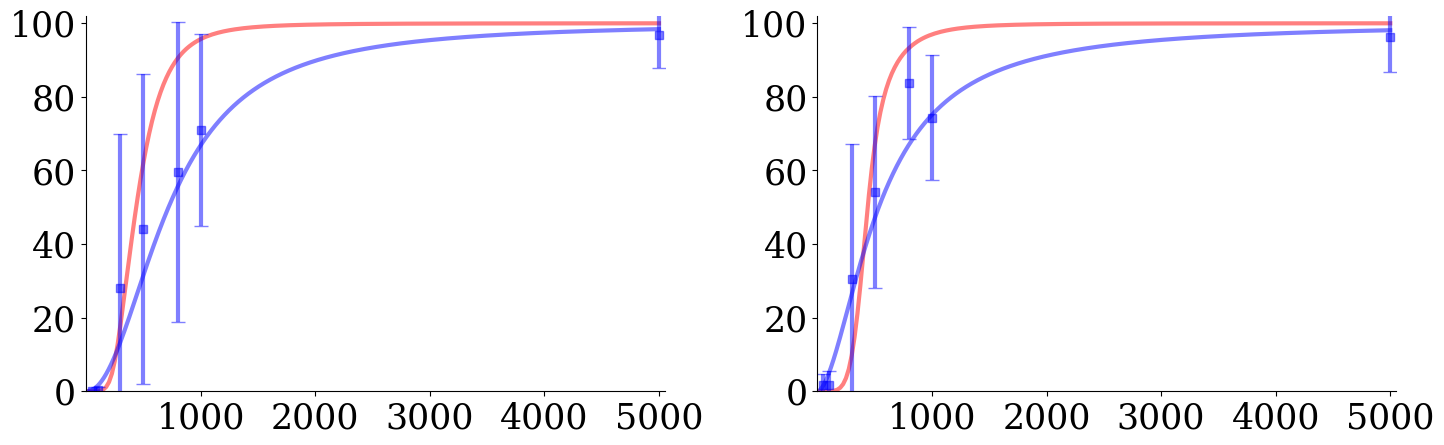

In [949]:
# Пример использования
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ADP, data_ex_ADP, data_ex_ADP_range, axs, 'ADP', phenotypes_list=['auc_a2b3', 'u_a2b3'], legend_pos='lower right')

plt.tight_layout()
plt.show()

In [950]:
# Нахождение AUC и Umax
data_raw = auc(min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, ADP_ilo, 20, 5, num_ph=5, conc_type='ilo')
data_ilo = data_raw[0]
relative_responce(data=data_ilo, conc_type='ilo', min_max=min_ilo, phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

file_path = '/content/1000_ADP_ilo_grad.xlsx'
data_ex_ilo = pd.read_excel(file_path)
file_path = '/content/Ilo_grad_calculated_range.xlsx'
data_ex_Ilo_range = pd.read_excel(file_path)

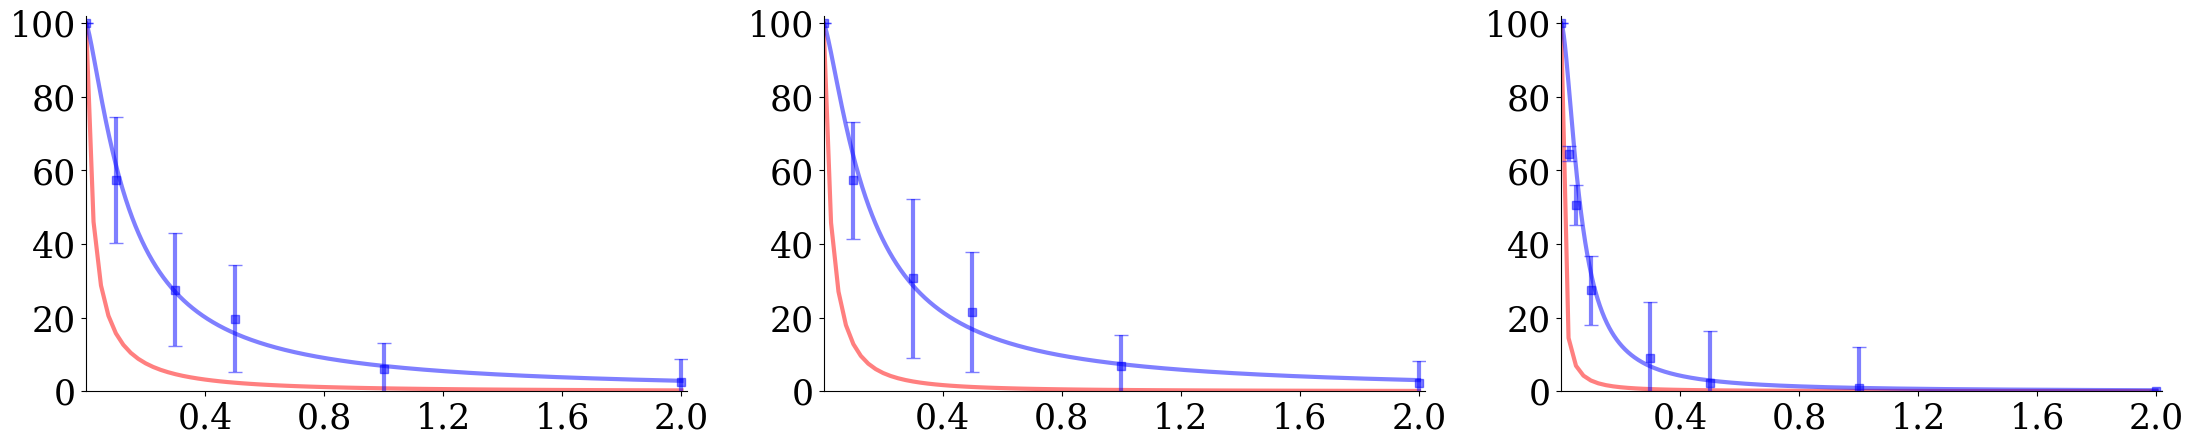

In [951]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=((15 * 1.5), 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ilo, data_ex_ilo, data_ex_Ilo_range, axs, 'ilo', phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

plt.tight_layout()
plt.show()

In [952]:
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 3

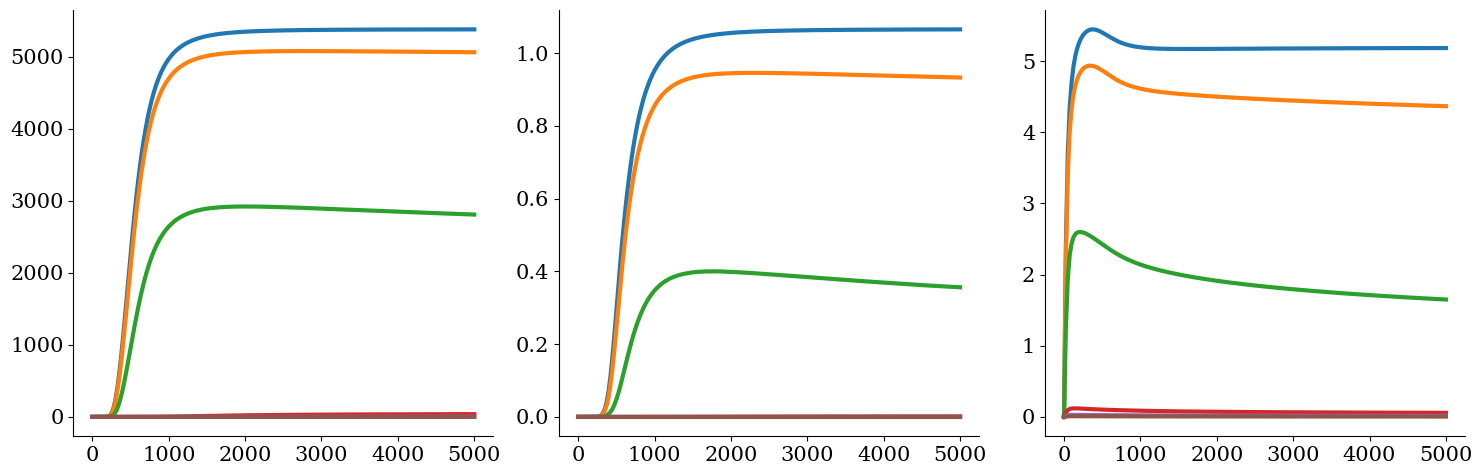

In [953]:

# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ilo_range, min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, num_ph=5, conc_type='ADP')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ADP', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ilo_range)

plt.tight_layout()
plt.show()


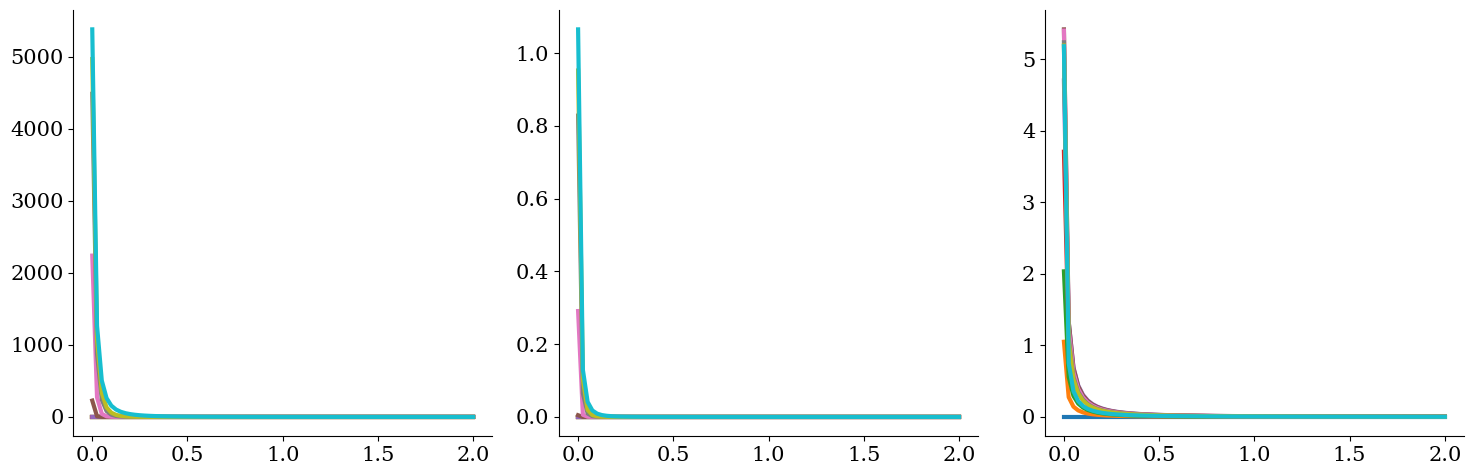

In [954]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ADP_range, min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, num_ph=5, conc_type='ilo')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ilo', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ADP_range)

plt.tight_layout()
plt.show()

##C обратными, с ki для прямых, без ki для обратных

In [955]:
# Система дифференциальных уравнений
def system(t, y):
    N_rest, N_sph, N_inh, N_gp, N_aggr, N_dsen, = y
    dN_rest_dt = k21 * N_inh + k11 * N_dsen - k12 * N_rest - k1 * N_rest
    dN_sph_dt = k1 * N_rest - k2 * N_sph - k5 * N_sph
    dN_inh_dt = k12 * N_rest - k21 * N_inh
    dN_gp_dt = k2 * N_sph - k3 * (N_gp ** 2) - k6 * N_gp
    dN_aggr_dt = k3 * (N_gp ** 2) - k7 * N_aggr
    dN_dsen_dt = k5 * N_sph + k6 * N_gp + k7 * N_aggr - k11 * N_dsen

    return [dN_rest_dt, dN_sph_dt, dN_inh_dt, dN_gp_dt, dN_aggr_dt, dN_dsen_dt]

In [956]:
k1_list = []
ki_1_list = []
k2_list = []
ki_2_list = []
k3_list = []
k5_list = []
k6_list = []
k7_list = []
k12_list = []
k21_list = []



# Решение системы дифф. уравнений
def calculate_concetrations(points, max_time, y0):

    y0 = y0

    for i in range(len(points)):

        ADP = points[i][1]
        ilo = points[i][2]

        global ki_1, ki_3, k1, k12, k21, km_2, ki_2, k2, k5, km_3, ki_3, k3, k6, k7 # при добавлении новых реакций, все константы должны быть перечислены здесь

        # нахождение констант (по формулам выше)

        ki_1 = calculate_k_inh(IC50_k1_ilo, h_k1_ilo, ADP, EC50_k1)
        k1 = calculate_k_with_inh(k1_max, ADP, h_k1, EC50_k1, ilo, ki_1)

        ki_2 = calculate_k_inh(IC50_k2_ilo, h_k2_ilo, ADP, EC50_k2)
        k2 = calculate_k_with_inh(k2_max, ADP, h_k2, EC50_k2, ilo, ki_2)

        k3 = calculate_k_simple(k3_max, ADP, h_k3, EC50_k3)

        k12 = calculate_k_simple(k12_max, ilo, h_k12, EC50_k12)
        k21 = calculate_k_simple(k21_max, ADP, h_k21, EC50_k21)

        k5 = calculete_reverse(k5_max, IC50_k5, h_k5, ADP)
        k6 = calculete_reverse(k6_max, IC50_k6, h_k6, ADP)
        k7 = calculete_reverse(k7_max, IC50_k7, h_k7, ADP)


        ki_1_list.append(calculate_k_inh(IC50_k1_ilo, h_k1_ilo, ADP, EC50_k1))
        k1_list.append(calculate_k_with_inh(k1_max, ADP, h_k1, EC50_k1, ilo, ki_1))
        ki_2_list.append(calculate_k_inh(IC50_k2_ilo, h_k2_ilo, ADP, EC50_k2))
        k2_list.append(calculate_k_with_inh(k2_max, ADP, h_k2, EC50_k2, ilo, ki_2))
        k3_list.append(calculate_k_simple(k3_max, ADP, h_k3, EC50_k3))
        k5_list.append(calculete_reverse(k5_max, IC50_k5, h_k5, ADP))
        k6_list.append(calculete_reverse(k6_max, IC50_k6, h_k6, ADP))
        k7_list.append(calculete_reverse(k7_max, IC50_k7, h_k7, ADP))
        k12_list.append(calculate_k_simple(k12_max, ilo, h_k12, EC50_k12))
        k21_list.append(calculate_k_simple(k21_max, ADP, h_k21, EC50_k21))

        # Начальные условия

        start = points[i][0]

        if i < len(points) - 1:
            end = points[i + 1][0]
        else:
            end = max_time
        step = end - start + 1

        # Временной интервал
        t_span = (start, end)
        t_eval = np.linspace(*t_span, step)

        sol = solve_ivp(system, t_span, y0, t_eval=t_eval, method='BDF', events=event_negative)

        df = pd.DataFrame(np.array(sol.y).T, columns=['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen'])
        df['Time'] = sol.t

        # Сумма
        df['Summ'] = df[['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen']].sum(axis=1)

        # Перестановка столбцов для удобства
        df = df[['Time', 'Summ', 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen']]

        if i > 0:
            results = pd.concat([results, df.iloc[1:]], axis=0)
        else:
            results = df

        y0 = sol.y.T[-1]

    return results

In [957]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0]
]

In [958]:
plt.rcParams['font.size'] = 25
plt.rcParams['lines.linewidth'] = 3

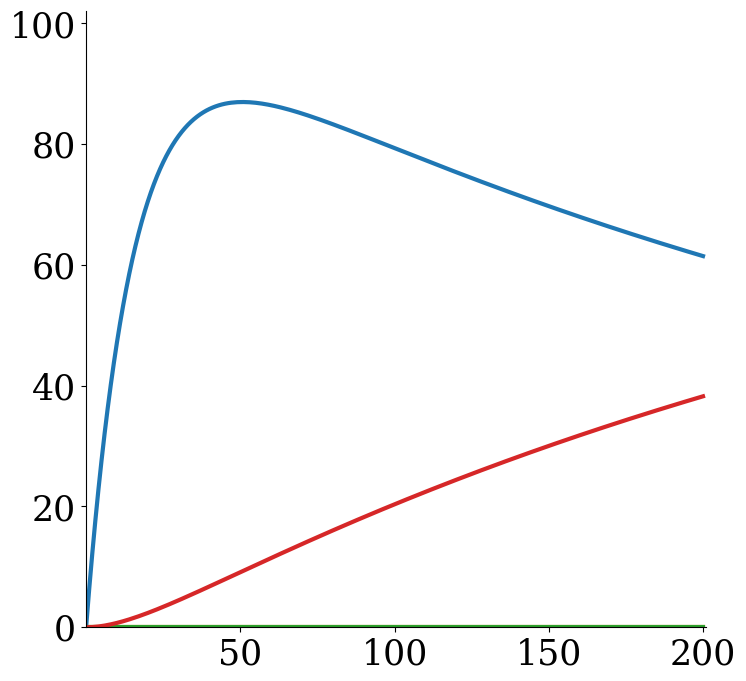

In [959]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [960]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0]
]

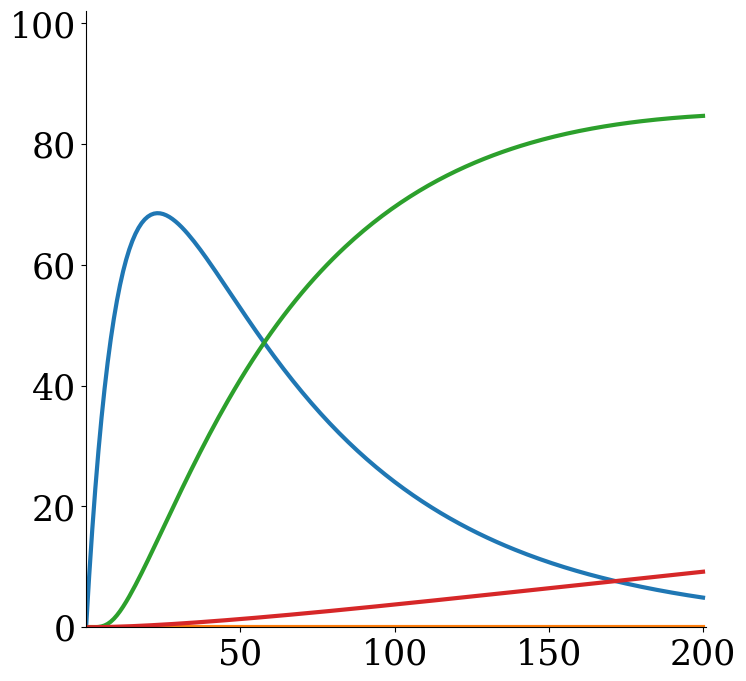

In [961]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [962]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.05]
]

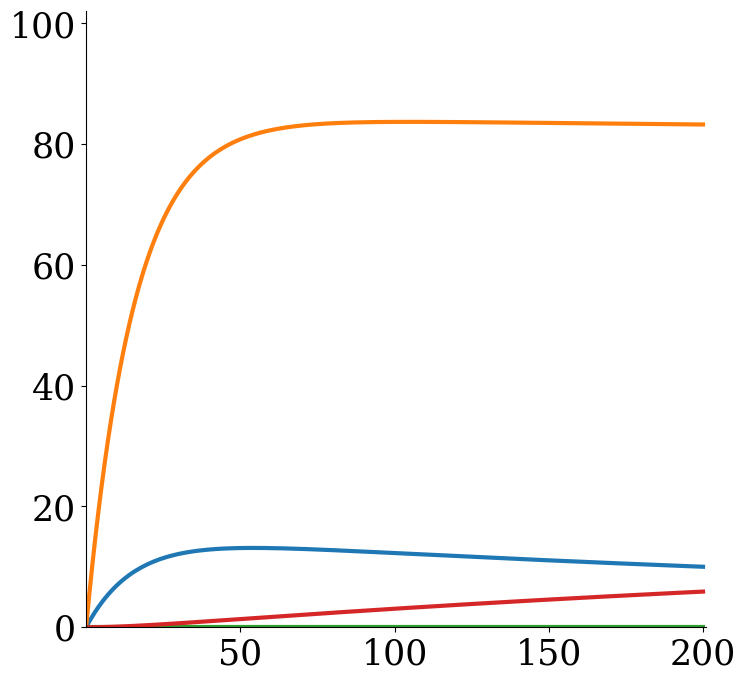

In [963]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [964]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.5]
]

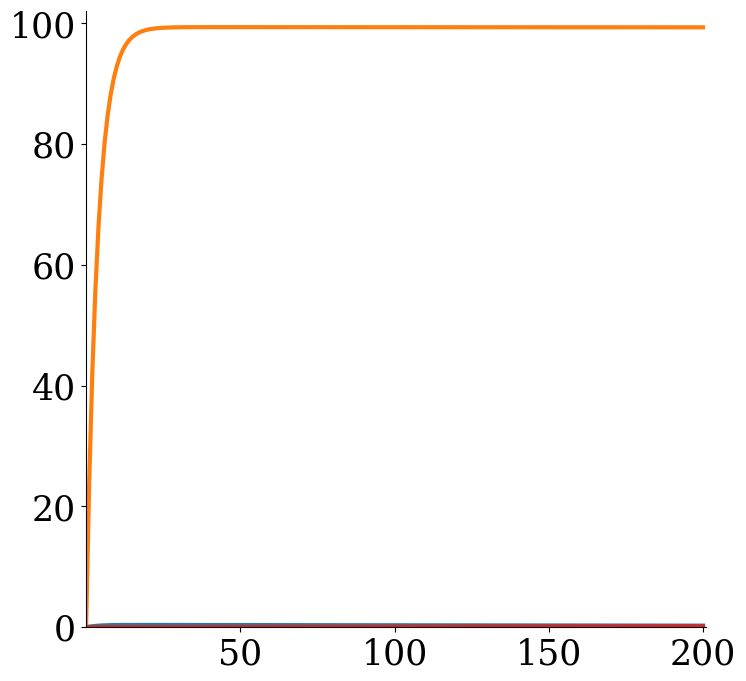

In [965]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [966]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.05]
]

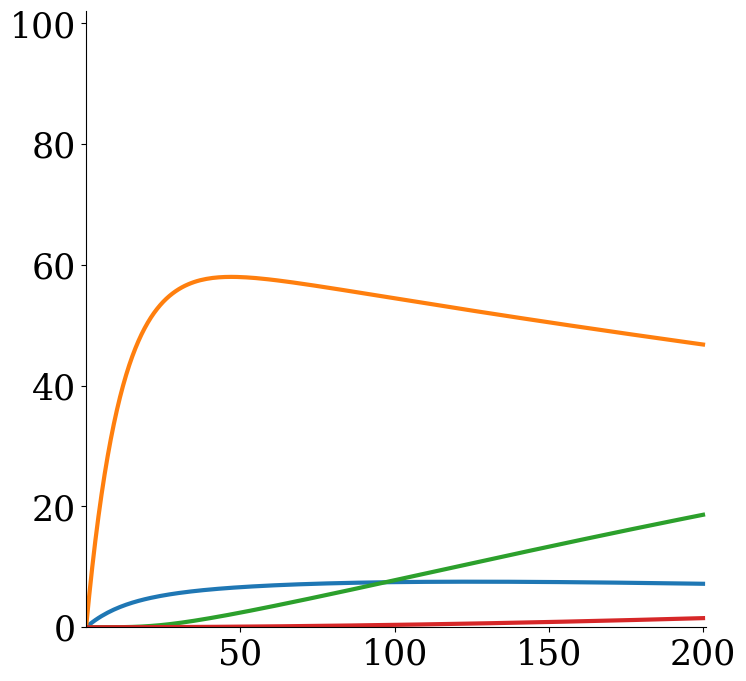

In [967]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [968]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.5]
]

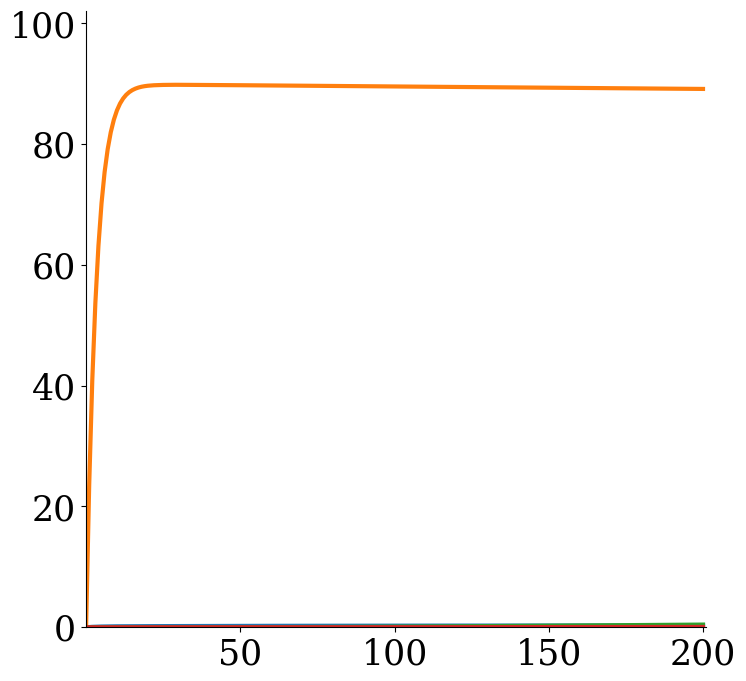

In [969]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [970]:
# Расчет данных AUC и Umax для диапазона ADP
data_raw = auc(min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, ilo_ADP, 20, 5, num_ph=6, conc_type='ADP')
data_ADP = data_raw[0]
relative_responce(data=data_ADP, conc_type='ADP', min_max=max_ADP, phenotypes_list=['auc_a2b3', 'u_a2b3'])

# Загрузка экспериментальных данных
file_path = '/content/ADP_grad.xlsx'
data_ex_ADP = pd.read_excel(file_path)
file_path = '/content/ADP_grad_calculated_range.xlsx'
data_ex_ADP_range = pd.read_excel(file_path)

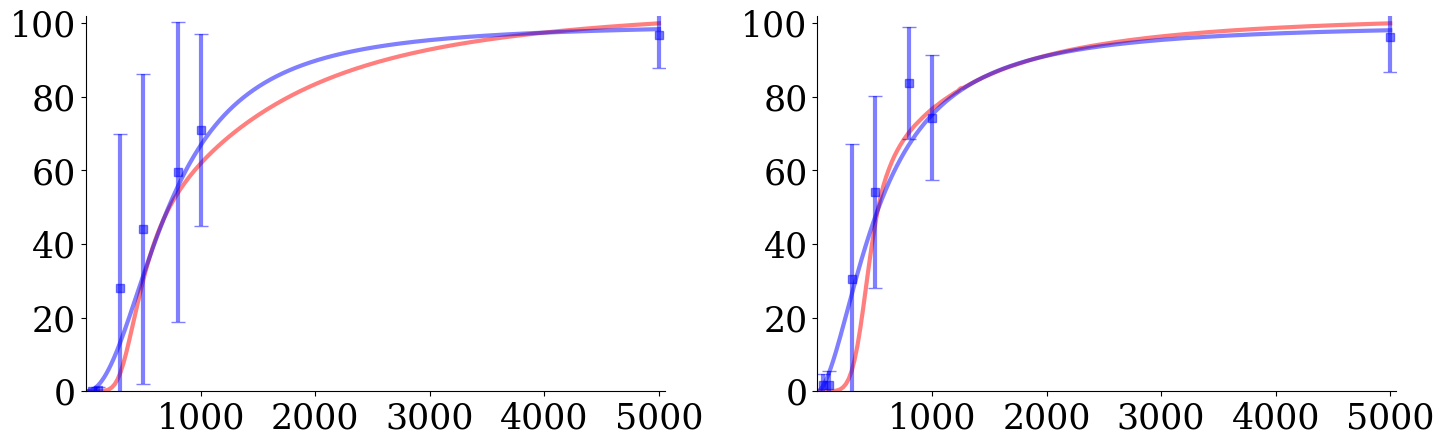

In [971]:
# Пример использования
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ADP, data_ex_ADP, data_ex_ADP_range, axs, 'ADP', phenotypes_list=['auc_a2b3', 'u_a2b3'], legend_pos='lower right')

plt.tight_layout()
plt.show()

In [972]:
# Нахождение AUC и Umax
data_raw = auc(min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, ADP_ilo, 20, 5, num_ph=6, conc_type='ilo')
data_ilo = data_raw[0]
relative_responce(data=data_ilo, conc_type='ilo', min_max=min_ilo, phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

file_path = '/content/1000_ADP_ilo_grad.xlsx'
data_ex_ilo = pd.read_excel(file_path)
file_path = '/content/Ilo_grad_calculated_range.xlsx'
data_ex_Ilo_range = pd.read_excel(file_path)

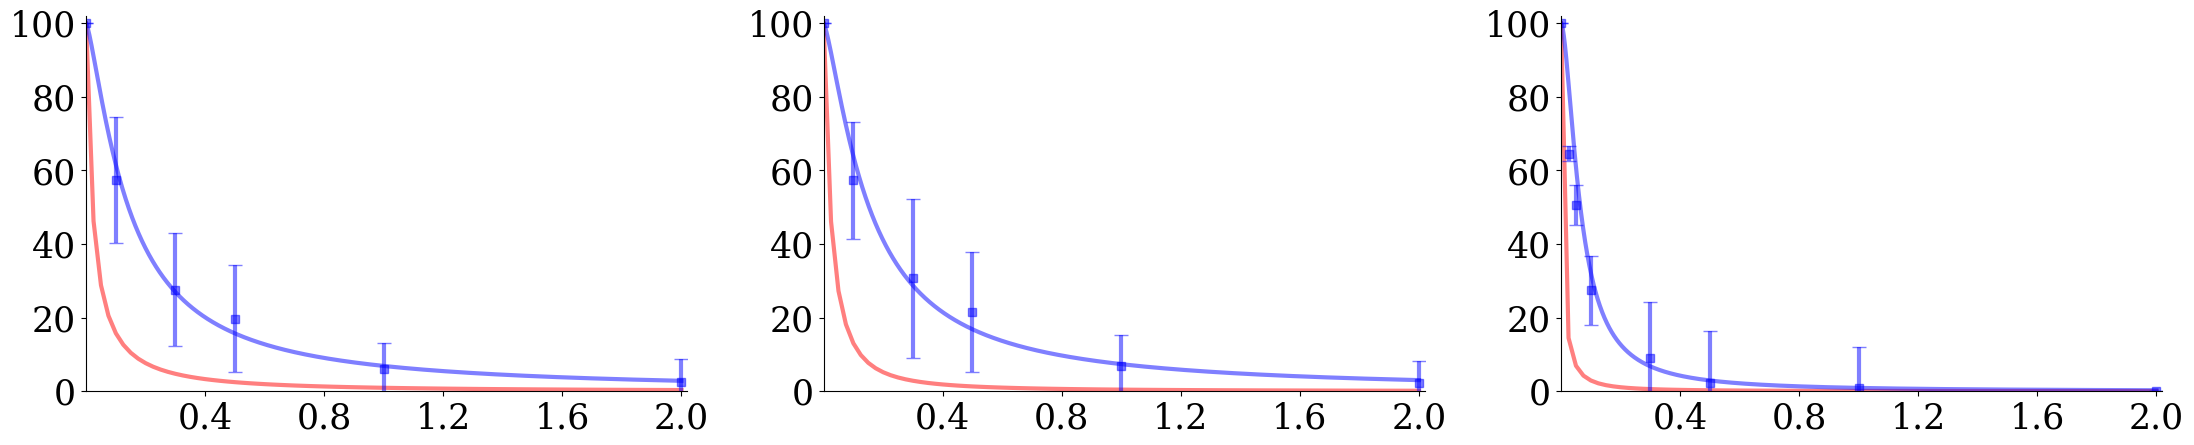

In [973]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=((15 * 1.5), 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ilo, data_ex_ilo, data_ex_Ilo_range, axs, 'ilo', phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

plt.tight_layout()
plt.show()

In [974]:
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 3

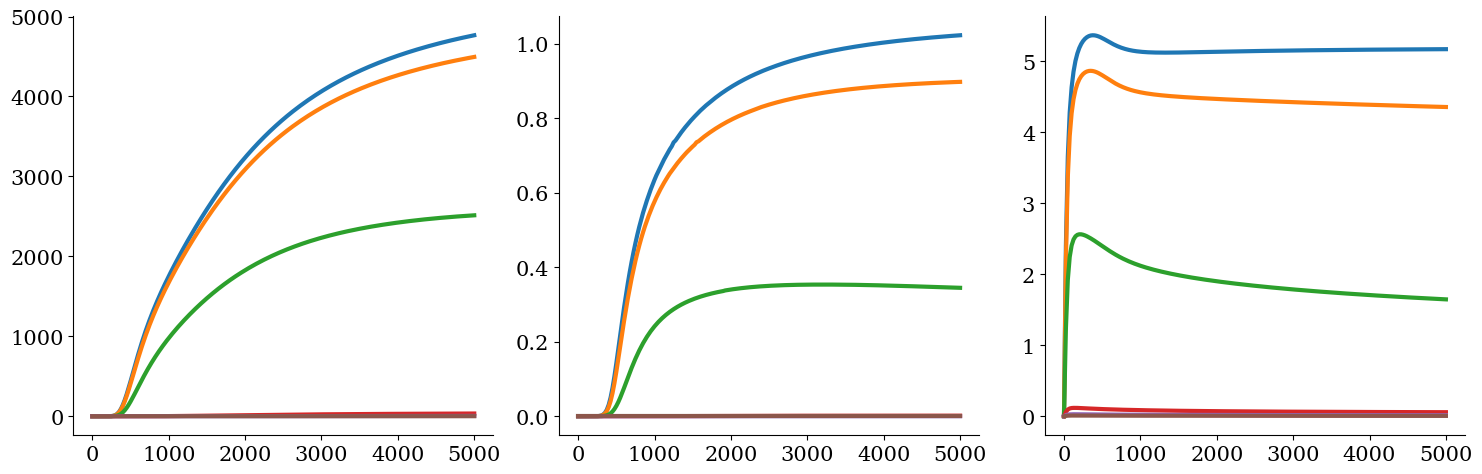

In [975]:

# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ilo_range, min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, num_ph=6, conc_type='ADP')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ADP', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ilo_range)

plt.tight_layout()
plt.show()


<ipython-input-770-77b623931753>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dy_dt'] = np.gradient(values, df['Time'])
<ipython-input-770-77b623931753>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['N_a2b3'] = sqrt_N_aggr
<ipython-input-770-77b623931753>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

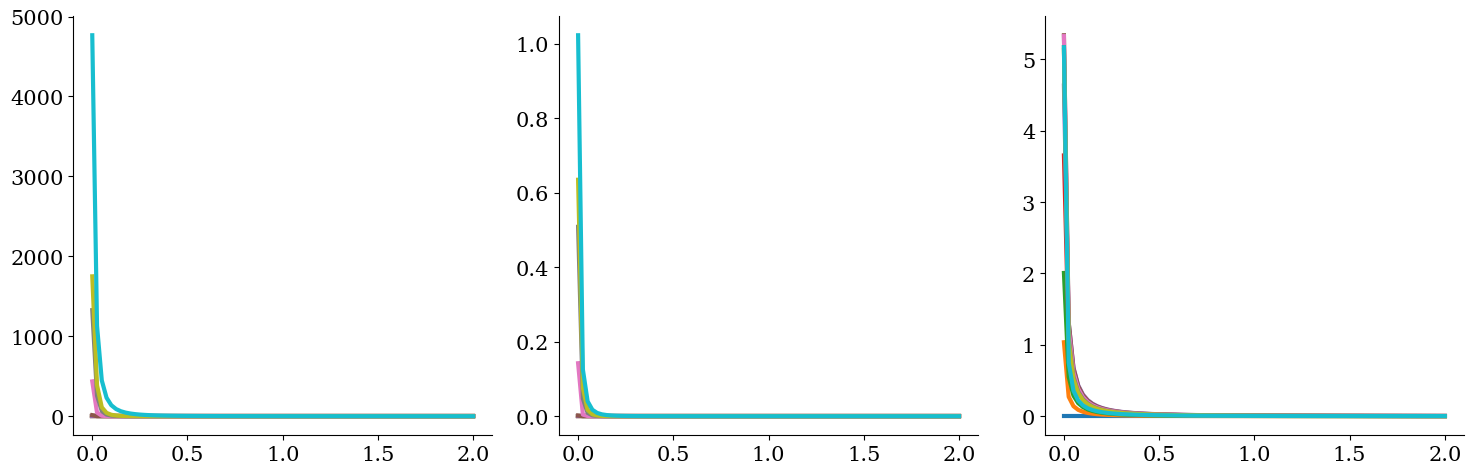

In [976]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ADP_range, min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, num_ph=6, conc_type='ilo')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ilo', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ADP_range)

plt.tight_layout()
plt.show()

##С обратными, с ki для прямых, c ki для обратных

In [977]:
# Система дифференциальных уравнений
def system(t, y):
    N_rest, N_sph, N_inh, N_gp, N_aggr, N_dsen, = y
    dN_rest_dt = k21 * N_inh + k11 * N_dsen - k12 * N_rest - k1 * N_rest
    dN_sph_dt = k1 * N_rest - k2 * N_sph - k5 * N_sph
    dN_inh_dt = k12 * N_rest - k21 * N_inh
    dN_gp_dt = k2 * N_sph - k3 * (N_gp ** 2) - k6 * N_gp
    dN_aggr_dt = k3 * (N_gp ** 2) - k7 * N_aggr
    dN_dsen_dt = k5 * N_sph + k6 * N_gp + k7 * N_aggr - k11 * N_dsen

    return [dN_rest_dt, dN_sph_dt, dN_inh_dt, dN_gp_dt, dN_aggr_dt, dN_dsen_dt]

In [978]:
ki_list = []

# Решение системы дифф. уравнений
def calculate_concetrations(points, max_time, y0):

    y0 = y0

    for i in range(len(points)):

        ADP = points[i][1]
        ilo = points[i][2]

        global ki_1, ki_3, k1, k12, k21, km_2, ki_2, k2, k5, km_3, ki_3, k3, k6, k7 # при добавлении новых реакций, все константы должны быть перечислены здесь

        # нахождение констант (по формулам выше)

        ki_1 = calculate_k_inh(IC50_k1_ilo, h_k1_ilo, ADP, EC50_k1)
        k1 = calculate_k_with_inh(k1_max, ADP, h_k1, EC50_k1, ilo, ki_1)

        ki_2 = calculate_k_inh(IC50_k2_ilo, h_k2_ilo, ADP, EC50_k2)
        k2 = calculate_k_with_inh(k2_max, ADP, h_k2, EC50_k2, ilo, ki_2)

        k3 = calculate_k_simple(k3_max, ADP, h_k3, EC50_k3)

        k12 = calculate_k_simple(k12_max, ilo, h_k12, EC50_k12)
        k21 = calculate_k_simple(k21_max, ADP, h_k21, EC50_k21)

        ki_5 = calculate_k_inh(IC50_k5_ADP, h_k5_ADP, ilo, EC50_k5_ilo)
        k5 = calculate_k_with_inh(k5_max, ilo, h_k5_ilo, EC50_k5_ilo, ADP, ki_5) + calculete_reverse(k5_max, IC50_k5, h_k5, ADP)

        ki_6 = calculate_k_inh(IC50_k6_ADP, h_k6_ADP, ilo, EC50_k6_ilo)
        k6 = calculate_k_with_inh(k6_max, ilo, h_k6_ilo, EC50_k6_ilo, ADP, ki_6) + calculete_reverse(k6_max, IC50_k6, h_k6, ADP)

        ki_7 = calculate_k_inh(IC50_k5_ADP, h_k5_ADP, ilo, EC50_k5_ilo)
        k7 = calculate_k_with_inh(k7_max, ilo, h_k7_ilo, EC50_k7_ilo, ADP, ki_7) + calculete_reverse(k7_max, IC50_k7, h_k7, ADP)

        #print(ki_1)
        #print(ki_2)

        # Начальные условия

        start = points[i][0]

        if i < len(points) - 1:
            end = points[i + 1][0]
        else:
            end = max_time
        step = end - start + 1

        # Временной интервал
        t_span = (start, end)
        t_eval = np.linspace(*t_span, step)

        sol = solve_ivp(system, t_span, y0, t_eval=t_eval, method='BDF', events=event_negative)

        df = pd.DataFrame(sol.y.T, columns=['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen'])
        df['Time'] = sol.t

        # Сумма
        df['Summ'] = df[['N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen']].sum(axis=1)

        # Перестановка столбцов для удобства
        df = df[['Time', 'Summ', 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen']]

        if i > 0:
            results = pd.concat([results, df.iloc[1:]], axis=0)
        else:
            results = df

        y0 = sol.y.T[-1]

    return results

In [979]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0]
]

In [980]:
plt.rcParams['font.size'] = 25
plt.rcParams['lines.linewidth'] = 3

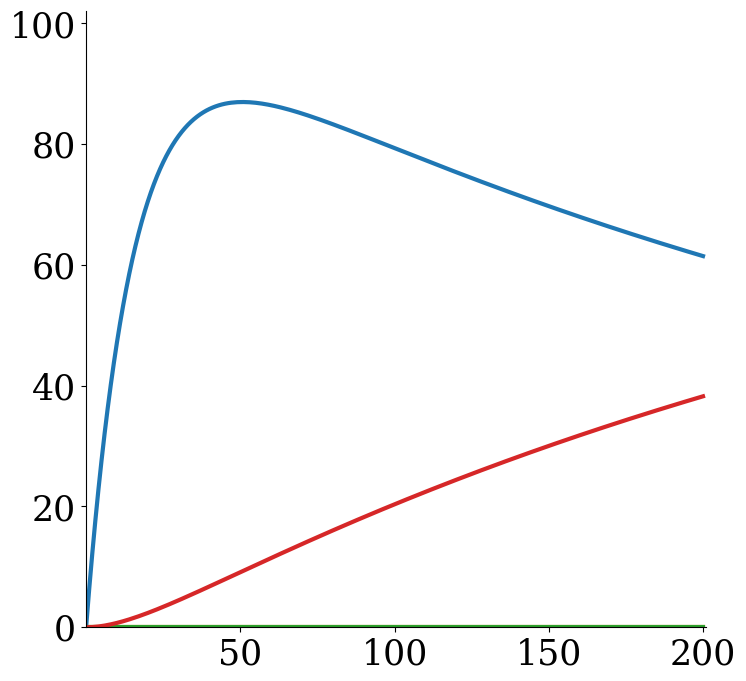

In [981]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [982]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0]
]

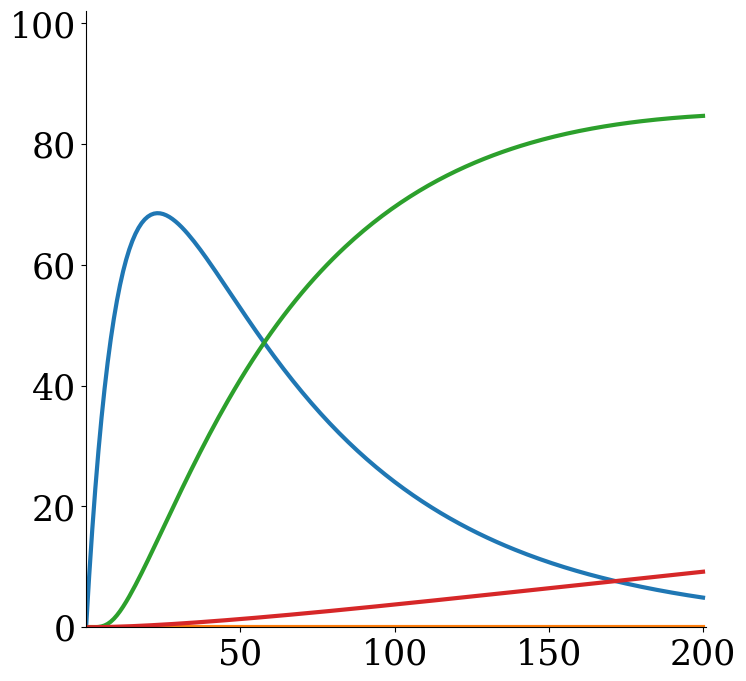

In [983]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [984]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.05]
]

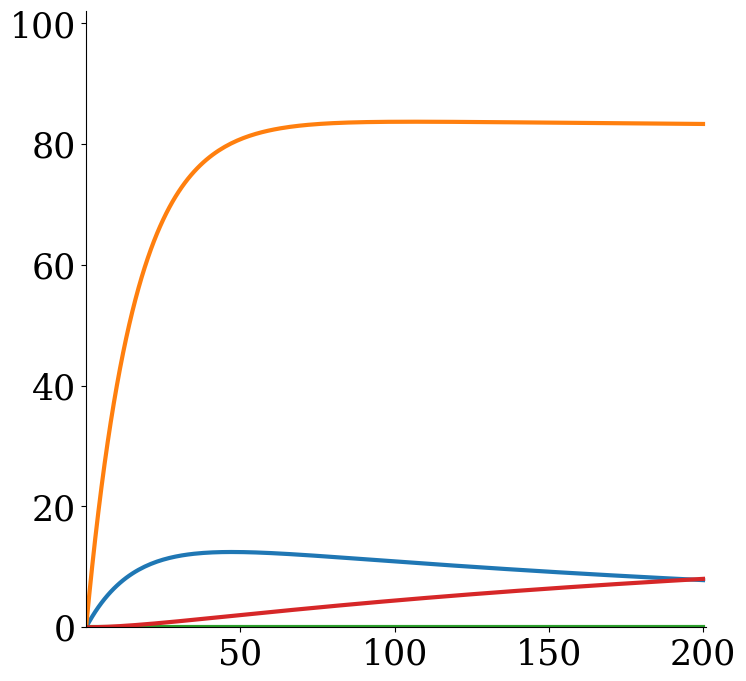

In [985]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [986]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 100, 0.5]
]

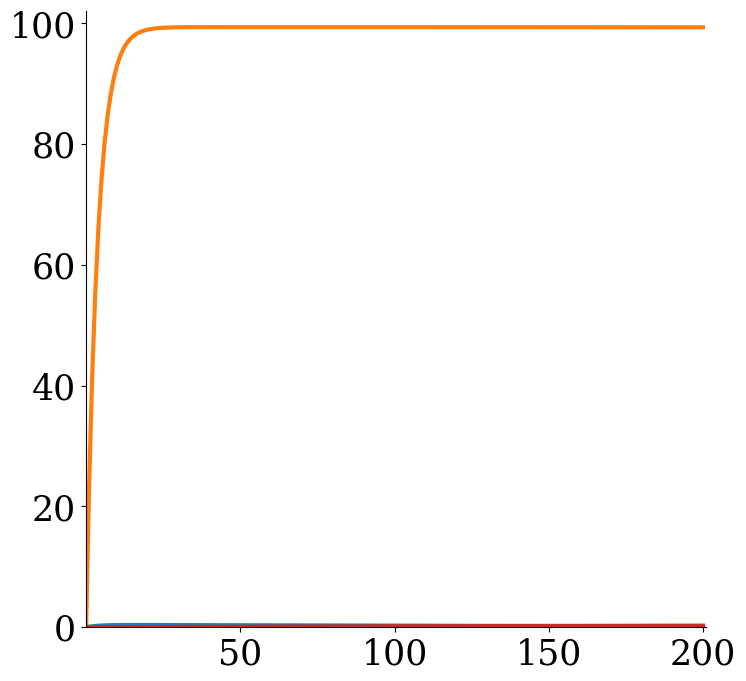

In [987]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [988]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.05]
]

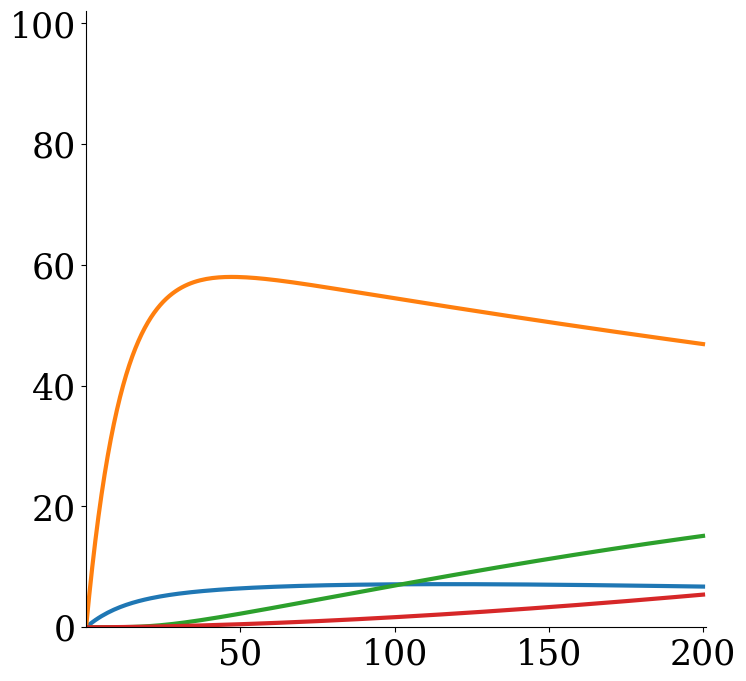

In [989]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [990]:
# Начальные концентрации фенотипов в процентах
# 'N_rest', 'N_sph', 'N_inh', 'N_gp', 'N_aggr', 'N_dsen', 'N_clot', 'N_coag', 'N_mp'
y0 = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Общее время проведения эксперимента в секундах
max_time = 200
xtick = 50
# Начальные условия и точки с добавками реагентов
# Время, Концентрация ADP, Концентрация ilo
# Пример (добавляем 1 ilo и только через 60 секунд вносим 1000 ADP): [0, 0, 1], [60, 1000, 1]
points = [
    [0, 10000, 0.5]
]

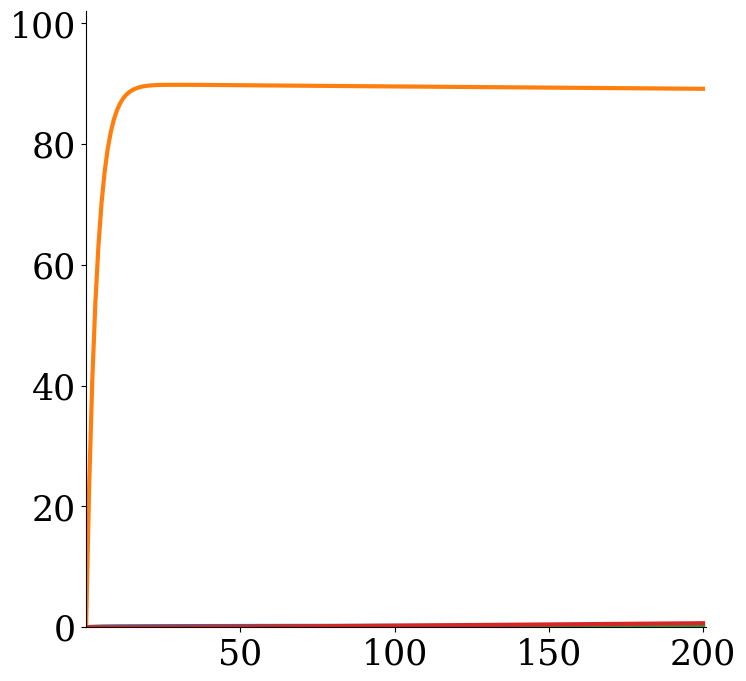

In [991]:
df_1 = calculate_concetrations(points, max_time, y0)

allowed_columns = ['N_aggr', 'N_dsen', 'N_inh', 'N_sph']
plot_selected_columns(df_1, allowed_columns, max_time, xtick, save_path='plot.png')

In [992]:
# Расчет данных AUC и Umax для диапазона ADP
data_raw = auc(min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, ilo_ADP, 20, 5, num_ph=6, conc_type='ADP')
data_ADP = data_raw[0]
relative_responce(data=data_ADP, conc_type='ADP', min_max=max_ADP, phenotypes_list=['auc_a2b3', 'u_a2b3'])

# Загрузка экспериментальных данных
file_path = '/content/ADP_grad.xlsx'
data_ex_ADP = pd.read_excel(file_path)
file_path = '/content/ADP_grad_calculated_range.xlsx'
data_ex_ADP_range = pd.read_excel(file_path)

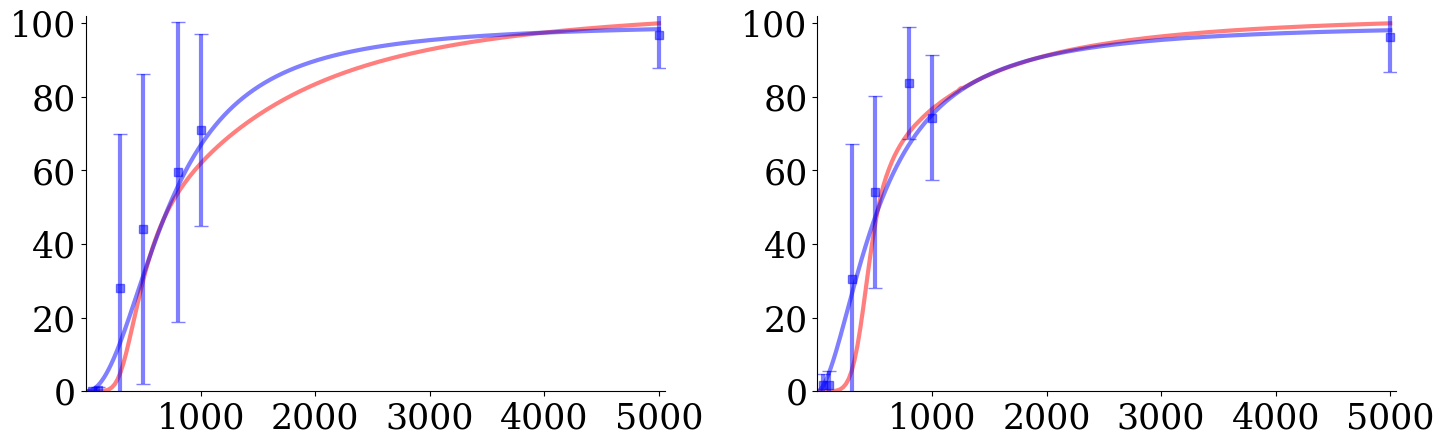

In [993]:
# Пример использования
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ADP, data_ex_ADP, data_ex_ADP_range, axs, 'ADP', phenotypes_list=['auc_a2b3', 'u_a2b3'], legend_pos='lower right')

plt.tight_layout()
plt.show()

In [994]:
# Нахождение AUC и Umax
data_raw = auc(min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, ADP_ilo, 20, 5, num_ph=6, conc_type='ilo')
data_ilo = data_raw[0]
relative_responce(data=data_ilo, conc_type='ilo', min_max=min_ilo, phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

file_path = '/content/1000_ADP_ilo_grad.xlsx'
data_ex_ilo = pd.read_excel(file_path)
file_path = '/content/Ilo_grad_calculated_range.xlsx'
data_ex_Ilo_range = pd.read_excel(file_path)

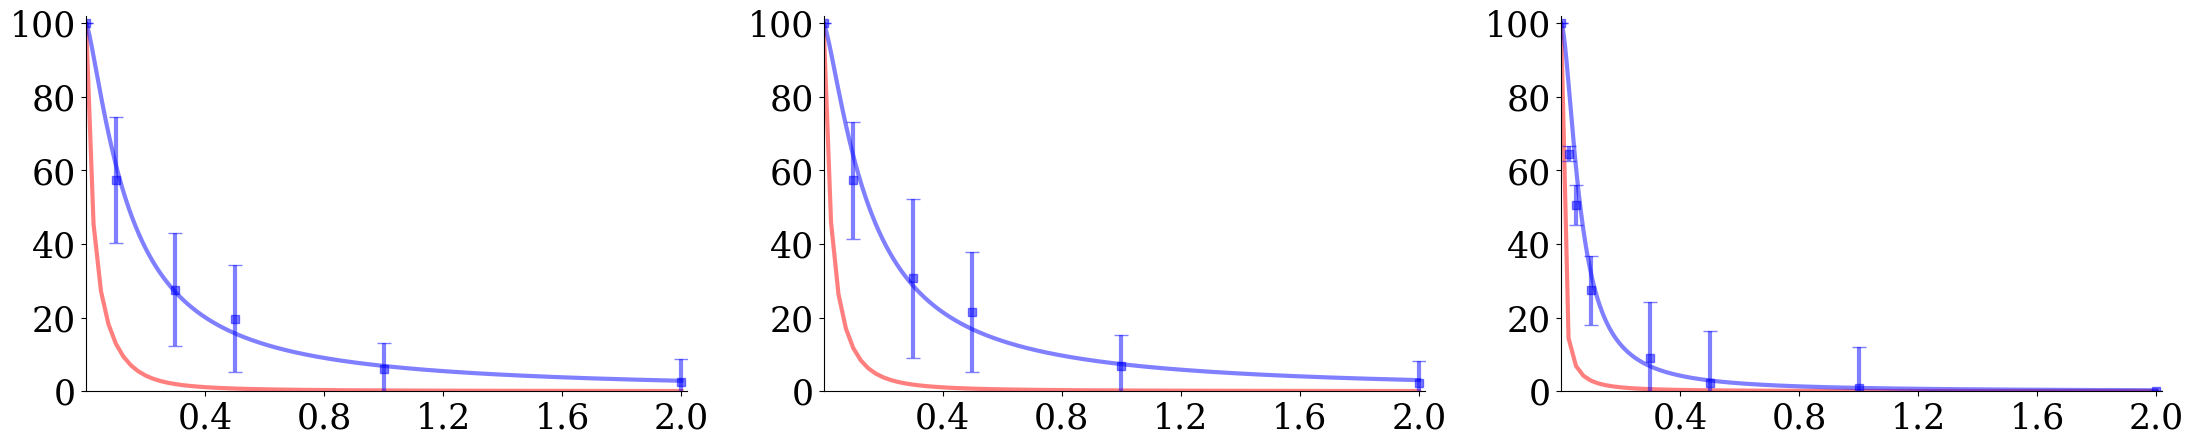

In [995]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=((15 * 1.5), 5))  # 1 строка, 3 столбца

# Отображаем графики на сабплотах
create_plots_on_subplots(data_ilo, data_ex_ilo, data_ex_Ilo_range, axs, 'ilo', phenotypes_list=['auc_a2b3', 'u_a2b3', 'u_sph'])

plt.tight_layout()
plt.show()

In [996]:
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 3

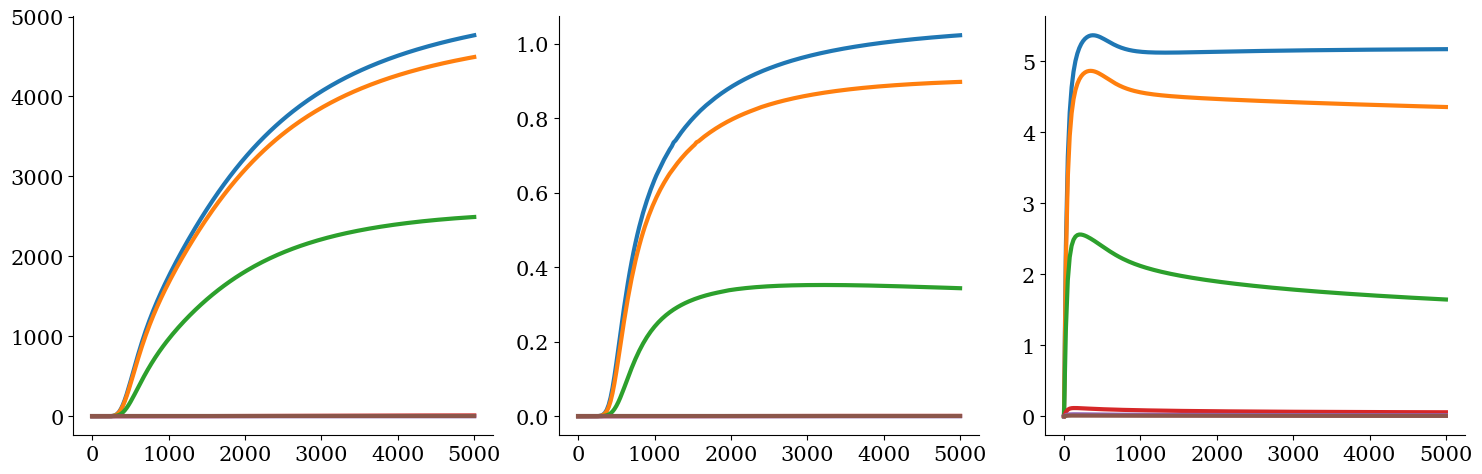

In [997]:

# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ilo_range, min_time_ADP, max_time_ADP, step_ADP, min_ADP, max_ADP, num_ph=6, conc_type='ADP')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ADP', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ilo_range)

plt.tight_layout()
plt.show()


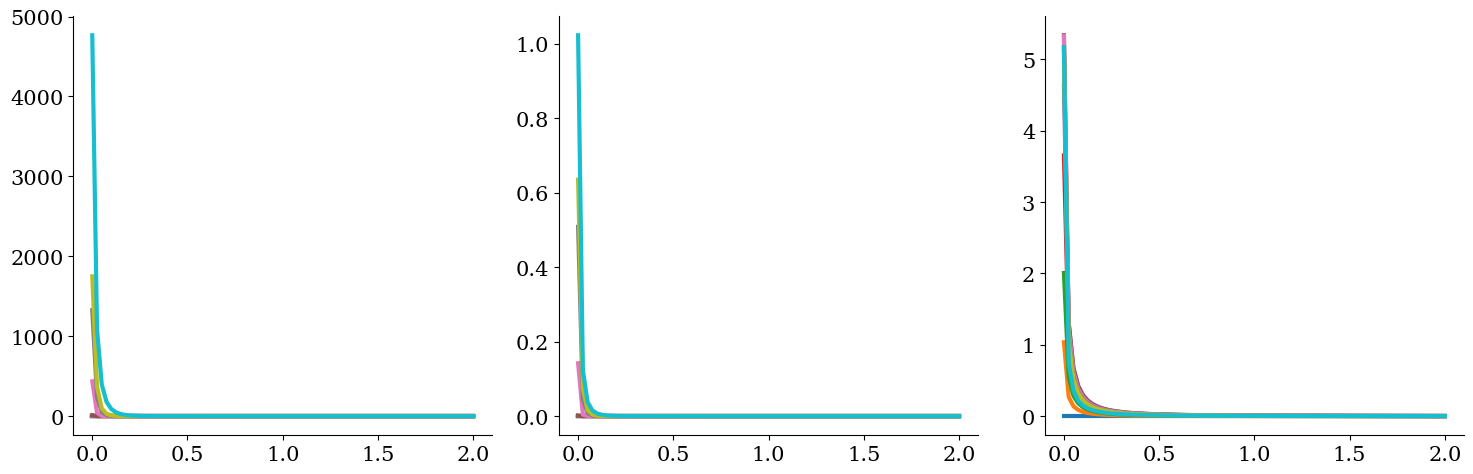

In [998]:
# Пример использования
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Вычисляем данные для всех концентраций один раз
data_dict = calculate_all_auc(ADP_range, min_time_ilo, max_time_ilo, step_ilo, min_ilo, max_ilo, num_ph=6, conc_type='ilo')

# Отображаем графики на сабплотах
create_plots_on_subplots_2(axs, 'ilo', phenotypes_list=['auc_aggr', 'u_aggr', 'u_sph'], data_dict=data_dict, conc_grad=ADP_range)

plt.tight_layout()
plt.show()